## Data flow : from raw lightcurves to merged metrics 

A notebook to plot : 

    1) color - magnitude (Hess) diagrams 
    
    2) color - color diagrams 
   
We use the Stripe 82 reprocessed FP data, from two processing centers : NCSA and IN2P3. Each got a half of the S82 coverage, with a narrow overlapping region of 0.5 degrees. 

On typhoon,  I ssh'd to magneto ,  and used the lightcurves in 
    
    /astro/store/pogo4/s13_stripe82/forced_phot_lt_23/NCSA/
    /astro/store/pogo4/s13_stripe82/forced_phot_lt_23/IN2P3/
   
to reprocess them using code LC_processing.py  , stored in : 
    
    mac : /Users/chris/GradResearch/SDSS_S82_FP_research/code/
    typhoon: /astro/users/suberlak/SDSS_S82_FP_research/code/
    
which uses processPatch.py package, stored in :

    mac : /Users/chris/GradResearch/SDSS_S82_FP_research/packages/
    typhoon: /astro/users/suberlak/SDSS_S82_FP_research/packages/
    
    
The output are metrics calculated per lightcurve per band, stored in:

    /astro/store/scratch/tmp/suberlak/s13_S82_2017/NCSA/
    /astro/store/scratch/tmp/suberlak/s13_S82_2017/IN2P3/
    
Then using code VarStat_merge_ugriz.py, from 
    mac : /Users/chris/GradResearch/SDSS_S82_FP_research/code/
    typhoon: /astro/users/suberlak/SDSS_S82_FP_research/code/
  
all metrics are  merged on 'objectId' ,  correctiong for extinction with  
    typhoon : /astro/users/suberlak/Desktop/deep_source/ebv_NCSA_lt235.dat
    
with information on  ra, dec, extendedness,from DeepSource files:

    typhoon : /astro/users/suberlak/Desktop/deep_source/DeepSourceIN2P3_i_lt235_extendedness.csv.gz
                                                        DeepSourceIN2P3_i_lt235_narrow.csv.gz

and removing from the combined files objects that have parents brighter than 17th mag ( in coadd i-band) from NCSA_source_without_bright_parent.npy , which was made using 

    source : DeepSourceNCSA_i_lt235_narrow.csv.gz and
    parent : DeepSourceNCSA_i_lt235_narrow_not_primary.csv.gz
    (analogous for IN2P3) 
 

To make output files smaller, we save only  N, chi2dof, chi2R, mu_full, psfMeanErr, psfMean_corr, ebv, pathch, objectId, ra,dec, extendedness in the final combined files ('narrow files'), stored in : 

    /astro/store/scratch/tmp/suberlak/s13_S82_2017/NCSA/varMetricsMerged/
    /astro/store/scratch/tmp/suberlak/s13_S82_2017/IN2P3/varMetricsMerged/
    
with a local copy of NCSA merged file at 

    /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/varMetricsMerged/
    

**README** (originally from  /astro/store/pogo4/s13_stripe82/deep_source/) : 
    
"Sources detected and measured on the i-band coadds with i-band psfMag < 23.5.

All reported row counts do not include the header.

The two data release productions (DRPs) overlap by 2.5 x 5 sq. deg. for validation purposes.
1) NCSA (-40  < RA < 10): 5,474,350 primary rows with psfMag < 23.5
2) IN2P3 (5 < RA < 55):   4,998,901 primary rows with psfMag < 23.5

Note that the imaging processed at the two datacenters was completed independently.
Therefore, DEEPSOURCEIDs ARE UNIQUE TO A DRP!
WITHIN a DRP, the i-band deepSourceId is the key across files as it was the SEED for forced photometry.


Files in this directory:
* DeepSourceNCSA_i_lt235.csv:        "Primary" sources. 60 columns x 5474350 rows
* DeepSourceNCSA_i_lt235_narrow.csv: "Primary" sources with subset of 10 columns x 5474350 rows
* DeepSourceNCSA_i_lt235_narrow_not_primary.csv: "Not-Primary" sources. 1957486 rows
        These are deblender parents and secondary detections in overlap regions.


* DeepSourceIN2P3_i_lt235.csv:        "Primary" sources. 60 columns x 4998901 rows
* DeepSourceIN2P3_i_lt235_narrow.csv: "Primary" sources with subset of 10 columns x 4998901 rows
* DeepSourceIN2P3_i_lt235_narrow_not_primary.csv: "Not-Primary" sources. 1882303 rows
        These are deblender parents and secondary detections in overlap regions. 


* ebv_IN2P3_lt235.dat: deepSourceId and ebv for primary IN2P3 sources 4998901 rows
* ebv_NCSA_lt235.dat:  deepSourceId and ebv for primary NCSA sources 5474350 rows

File notes:
If parentDeepSourceId == -1, it is null and the deep source did not have a parent.
BEWARE: sources with parents with i < 17 have unreliable lightcurves and morphologies. 
I recommend removing from survey like:
######## EXAMPLE #######
import pandas as pd
source = pd.read_csv('DeepSourceNCSA_i_lt235_narrow.csv.gz', compression='gzip', index_col=0)
parent = pd.read_csv('DeepSourceNCSA_i_lt235_narrow_not_primary.csv.gz', compression='gzip', index_col=0)
parent_bright = parent.loc[parent.psfMag < 17.0]
parent_source_joined = pd.merge(source, parent_bright[['psfMag', 'psfMagSigma', 'ra', 'decl']],
                         how='left', suffixes=['', '_parent'],
                         left_on='parentDeepSourceId', right_index=True)
source_without_bright_parent = parent_source_joined.loc[parent_source_joined.psfMag_parent.isnull()]
###############################

Questions? email yusra@uw.edu"

## Imports 

In [368]:
import pandas as pd
pd.options.display.max_columns = 999

import numpy as np
import os 
import sys
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib import rcParams

from scipy.stats import binned_statistic_2d
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column

import datetime

## Read-in the ugriz variability metrics

In [2]:
# NCSA 
# using astropy Table : discussion about speed 
# https://github.com/astropy/astropy/issues/3334 

# In the last resort : line-by-line ascii approach
# http://hea-www.harvard.edu/~aldcroft/tmp/p4a/hamogu/html/files/asciifiles.html
    
DirIn = '../data_products/varMetricsMerged/'
fname =  'Var_ugriz_11_patches_NCSA_narrow.csv' 
data1 = Table.read(DirIn+fname, format='csv')

In [3]:
# IN2P3
DirIn = '../data_products/varMetricsMerged/'
fname =  'Var_ugriz_11_patches_IN2P3_narrow.csv.gz' 
data2 = Table.read(DirIn+fname, format='csv')

In [390]:
# add a column saying which site is the data from ... 
new_col = Column(name='site',data= np.zeros_like(data1['patch']))
new_col[:] = 'NCSA'
data1.add_column(new_col)

In [391]:
# add a column saying which site is the data from ... 
new_col = Column(name='site',data= np.zeros_like(data2['patch']))
new_col[:] = 'IN2P3'
data2.add_column(new_col)

In [396]:
# Identical columns :
assert np.sum(np.in1d(data1.colnames, data2.colnames)) == len(data1.colnames)

In [397]:
# stack the two vertically ( rows over rows,  since the columns ARE IDENTICAL )
# this is even faster than any other merge, etc. 
data = vstack([data1, data2])

In [66]:
#data

In [64]:
# Read in the single patch combined across filters...
# Pandas hangs up if I try anything > 1 mln rows ....

#DirIn = '../data_products/varMetricsMerged/'
#fname =  'Var_ugriz_11_patches_NCSA_narrow.csv' #'Var_ugriz_1_patches_NCSA.csv.gz'
#data = pd.read_csv( DirIn + fname,low_memory=False, nrows=2e6)

## Plotting ...

### Sesar 2007 , Fig.3 : variable are  those where $\chi^{2}_{DOF}(g,r) > 1 + 3 \sigma$ 

In [43]:
figDir = 'Fig_Sesar2007'
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+figDir,
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)

We will save this figure in  /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/


In [22]:
# Select objects with chi2DOF > 3 ,  and plot  g vs u-g  ,  g-r  vs u-g 
# also plot chi2DOF  vs chi2R ...

# code needed for that is already present in 
# VarStat_exploratory_ugriz_results.ipynb   


In [532]:
import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 13

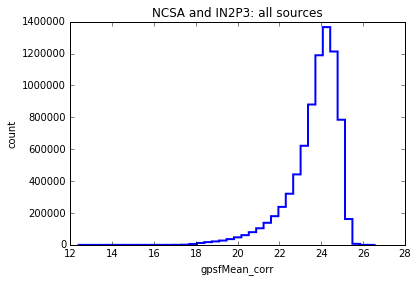

In [68]:
# show how magnitude cuts affect our numbers... 
plt.hist(data['gpsfMean_corr'], bins=40, histtype='step', lw=2)
plt.title('NCSA and IN2P3: all sources')
plt.xlabel('gpsfMean_corr')
plt.ylabel('count')

In [265]:
outDir = '/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-17/'

Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_chi2_space/2017-03-20/Fig3_test_ext-0_and_1.png 


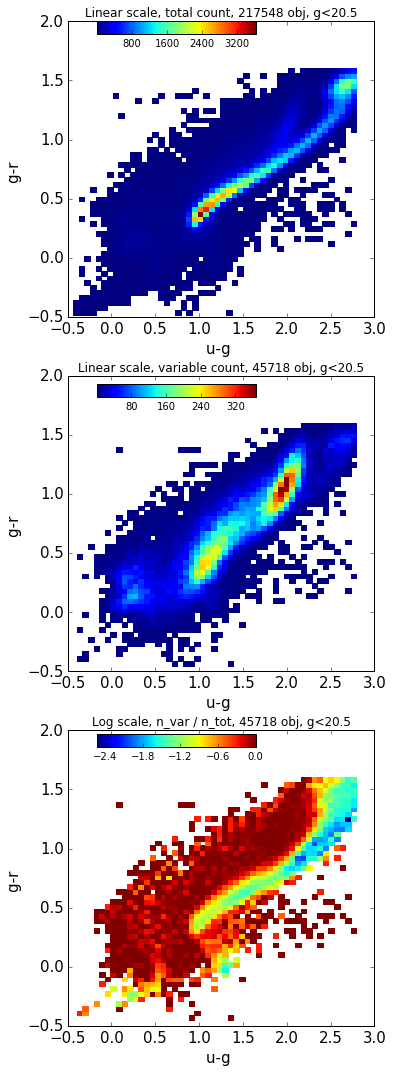

In [316]:
%matplotlib inline

# Note : 
# when using astropy, instead of .values
# need to call .data.data .... 
# If need to use pandas,  make sure you do Edit --> Find and Replace ! 

u = data['upsfMean_corr'].data.data
g = data['gpsfMean_corr'].data.data
r = data['rpsfMean_corr'].data.data
ug = u - g
gr = g - r

gmax = 20.5
ext = 0 # take only stars and QSO ... 

mask_ext = data['extendedness'].data.data == ext 
mask_brightness = g < gmax
mask_ug = ((u-g)<2.8) & ((u-g)>-0.5)
mask_gr = ((g-r)<1.6) & ((g-r)>-0.5)
#mask_n_points_g = (data['gN'].data.data > 60) & (data['gN'].data.data < 160)
#mask_n_points_r = (data['rN'].data.data > 60) & (data['rN'].data.data < 160)
#mask_n_points_u = (data['uN'].data.data > 60) & (data['uN'].data.data < 160)
#mask_n_points = mask_n_points_u & mask_n_points_g & mask_n_points_r

mask_total = mask_ug & mask_gr & mask_brightness # & mask_ext

fig, ax = plt.subplots(3,1, figsize=(5.5,18))

############################
# TOP PANEL :  TOTAL COUNT #
############################

nObj = len(u[mask_total])
stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax[0].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
ax[0].set_xlabel('u-g ', fontsize=15)
ax[0].set_ylabel('g-r ', fontsize=15)
ax[0].set_title('Linear scale, total count, %d obj, g<%.1f'%(nObj,gmax))
ax[0].tick_params(axis='both', which='major', labelsize=15) 

colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
colorbar.locator = tick_locator
colorbar.update_ticks()

####################################
# MIDDLE PANEL :  VARIABLE COUNT   #
####################################

# select variable objects... 

#mask_chi2_g = data['gchi2DOF'].data.data > 2#1 + 3*np.sqrt(2.0/data['gN'].data.data)
#mask_chi2_r = data['rchi2DOF'].data.data > 2 #1 + 3*np.sqrt(2.0/data['rN'].data.data)

#mask_combined = ( data['gchi2DOF'].data.data > 2 ) & 

# use sample 1 : better selects variability 
chi_boundary = 1.5
mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data > chi_boundary)

mask_variable = mask_total & mask_sample
nObj = len(u[mask_variable])

# Calculate the count of variable sources...
stats = binned_statistic_2d(x=ug[mask_variable], y=gr[mask_variable], values=ug[mask_variable], 
                            statistic='count', bins=50)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_var = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax[1].pcolormesh(x_edges,y_edges,z_masked_var, cmap='jet')
ax[1].set_xlabel('u-g ', fontsize=15)
ax[1].set_ylabel('g-r ', fontsize=15)
ax[1].set_title('Linear scale, variable count, %d obj, g<%.1f'%(nObj,gmax))
ax[1].tick_params(axis='both', which='major', labelsize=15) 
colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
colorbar.locator = tick_locator
colorbar.update_ticks()

###################################################
# BOTTOM PANEL :  VARIABLE COUNT / TOTAL COUNT    #
###################################################

z_masked_ratio = z_masked_var / z_masked
# Mask pixels with a value of zero

# Plot 2D histogram using pcolor
Z =  np.log10(z_masked_ratio)
image = ax[2].pcolormesh(x_edges,y_edges, Z, cmap='jet', vmax = 0)
ax[2].set_xlabel('u-g ', fontsize=15)
ax[2].set_ylabel('g-r ', fontsize=15)
ax[2].set_title('Log scale, n_var / n_tot, %d obj, g<%.1f'%(nObj,gmax))
ax[2].tick_params(axis='both', which='major', labelsize=15) 

colorbar_ax = fig.add_axes([0.2, 0.34, 0.4, 0.01])
colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
colorbar.locator = tick_locator
colorbar.update_ticks()

# Saving the colorbar from being messed by the tight_layout()
# http://matplotlib.org/users/tight_layout_guide.html

fname = outDir+'Fig3_test_ext-0_and_1_S1.png'
plt.savefig(fname, bbox_inches='tight')
print('Saved as %s '%fname)


Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-17/Fig3_test_ext-1_contour_0.png 


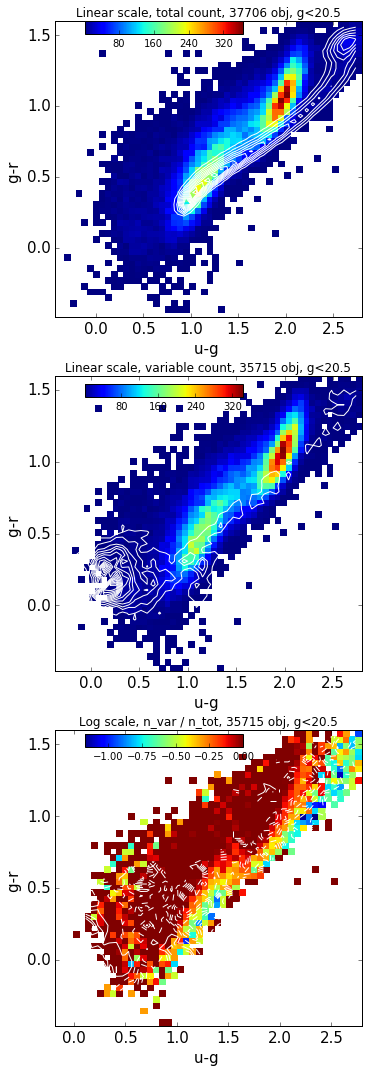

In [281]:
# Plot galaxies and stellar contours in the background ....


%matplotlib inline

# Note : 
# when using astropy, instead of .values
# need to call .data.data .... 
# If need to use pandas,  make sure you do Edit --> Find and Replace ! 

u = data['upsfMean_corr'].data.data
g = data['gpsfMean_corr'].data.data
r = data['rpsfMean_corr'].data.data
ug = u - g
gr = g - r

gmax = 20.5
 
mask_brightness = g < gmax
mask_ug = ((u-g)<2.8) & ((u-g)>-0.5)
mask_gr = ((g-r)<1.6) & ((g-r)>-0.5)
#mask_n_points_g = (data['gN'].data.data > 60) & (data['gN'].data.data < 160)
#mask_n_points_r = (data['rN'].data.data > 60) & (data['rN'].data.data < 160)
#mask_n_points_u = (data['uN'].data.data > 60) & (data['uN'].data.data < 160)
#mask_n_points = mask_n_points_u & mask_n_points_g & mask_n_points_r



fig, ax = plt.subplots(3,1, figsize=(5.5,18))

############################
# TOP PANEL :  TOTAL COUNT #
############################

# 1) Contours of stellar distribution
ext = 0 # take only stars and QSO ... 
mask_ext = data['extendedness'].data.data == ext
mask_total = mask_ug & mask_gr & mask_brightness & mask_ext

nObj = len(u[mask_total])
stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_0 = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
contours = ax[0].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, 15, colors='white')

# 2) pcolor  of galaxies distribution
ext = 1 
mask_ext = data['extendedness'].data.data == ext
mask_total = mask_ug & mask_gr & mask_brightness & mask_ext

nObj = len(u[mask_total])
stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_1 = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
image = ax[0].pcolormesh(x_edges,y_edges,z_masked_1, cmap='jet')
ax[0].set_xlabel('u-g ', fontsize=15)
ax[0].set_ylabel('g-r ', fontsize=15)
ax[0].set_title('Linear scale, total count, %d obj, g<%.1f'%(nObj,gmax))
ax[0].tick_params(axis='both', which='major', labelsize=15) 

colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
colorbar.locator = tick_locator
colorbar.update_ticks()


####################################
# MIDDLE PANEL :  VARIABLE COUNT   #
####################################

# use sample 1 : better selects variability 
chi_boundary = 2 
mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data > chi_boundary)


# 1) Contours for stellar distribution

ext = 0 # take only stars and QSO ... 
mask_ext = data['extendedness'].data.data == ext
mask_total = mask_ug & mask_gr & mask_brightness & mask_ext

mask_variable = mask_total & mask_sample
nObj = len(u[mask_variable])

# Calculate the count of variable sources...
stats = binned_statistic_2d(x=ug[mask_variable], y=gr[mask_variable], values=ug[mask_variable], 
                            statistic='count', bins=50)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_var_0 = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
contours = ax[1].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, 15, colors='white')

# 2) pcolor  of galaxies distribution
ext =1 
mask_ext = data['extendedness'].data.data == ext
mask_total = mask_ug & mask_gr & mask_brightness & mask_ext

mask_variable = mask_total & mask_sample
nObj = len(u[mask_variable])

# Calculate the count of variable sources...
stats = binned_statistic_2d(x=ug[mask_variable], y=gr[mask_variable], values=ug[mask_variable], 
                            statistic='count', bins=50)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_var_1 = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 
image = ax[1].pcolormesh(x_edges,y_edges,z_masked_var_1, cmap='jet')
ax[1].set_xlabel('u-g ', fontsize=15)
ax[1].set_ylabel('g-r ', fontsize=15)
ax[1].set_title('Linear scale, variable count, %d obj, g<%.1f'%(nObj,gmax))
ax[1].tick_params(axis='both', which='major', labelsize=15) 
colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
colorbar.locator = tick_locator
colorbar.update_ticks()

###################################################
# BOTTOM PANEL :  VARIABLE COUNT / TOTAL COUNT    #
###################################################

#1) Contours for stellar distribution

z_masked_ratio_0 = z_masked_var_0 / z_masked_0
Z =  np.log10(z_masked_ratio_0)
contours = ax[2].contour(x_edges[:-1], y_edges[:-1], Z, 15, colors='white')

#2) Pcolormesh  for galactic distr 

z_masked_ratio_1 = z_masked_var_1 / z_masked_1
Z =  np.log10(z_masked_ratio_1)

image = ax[2].pcolormesh(x_edges,y_edges, Z, cmap='jet', vmax = 0)
ax[2].set_xlabel('u-g ', fontsize=15)
ax[2].set_ylabel('g-r ', fontsize=15)
ax[2].set_title('Log scale, n_var / n_tot, %d obj, g<%.1f'%(nObj,gmax))
ax[2].tick_params(axis='both', which='major', labelsize=15) 

colorbar_ax = fig.add_axes([0.2, 0.34, 0.4, 0.01])
colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
colorbar.locator = tick_locator
colorbar.update_ticks()

# Saving the colorbar from being messed by the tight_layout()
# http://matplotlib.org/users/tight_layout_guide.html

fname = outDir+'Fig3_test_ext-1_contour_0.png'
plt.savefig(fname, bbox_inches='tight')
print('Saved as %s '%fname)



### Sesar 2007, Fig 3.,  variable:  s1: $\chi^{2}_{dof,R}(g) > 2 $ or $>1.5 $,   s2: less strict

In [114]:
# Testing out : iterate over a cartesian product
# http://stackoverflow.com/questions/12237283/how-to-iterate-in-a-cartesian-product-of-lists 

gmax_ = [20.5,21.5, 22.5]
sample_ = [1,2]  
chi_ = [1.5,2] 

from itertools import product
for gmax, sample, chi in product(gmax_, sample_,chi_ ):
    print(gmax,sample, chi)
            

20.5 1 1.5
20.5 1 2
20.5 2 1.5
20.5 2 2
21.5 1 1.5
21.5 1 2
21.5 2 1.5
21.5 2 2
22.5 1 1.5
22.5 1 2
22.5 2 1.5
22.5 2 2


Using gmax=20.5,sample=1, chi_boundary=1.5
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_test_sample1_chi_bound-1.5_gmax-20.5.png 
Using gmax=20.5,sample=1, chi_boundary=2.0
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_test_sample1_chi_bound-2_gmax-20.5.png 
Using gmax=20.5,sample=2, chi_boundary=1.5
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_test_sample2_chi_bound-1.5_gmax-20.5.png 
Using gmax=20.5,sample=2, chi_boundary=2.0
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_test_sample2_chi_bound-2_gmax-20.5.png 
Using gmax=21.5,sample=1, chi_boundary=1.5
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_test_sample1_chi_bound-1.5_gmax-21.5.png 
Using gmax=21.5,sample=1, chi_boundary=2.0
Saved as /Users/chris/GradResearch/S

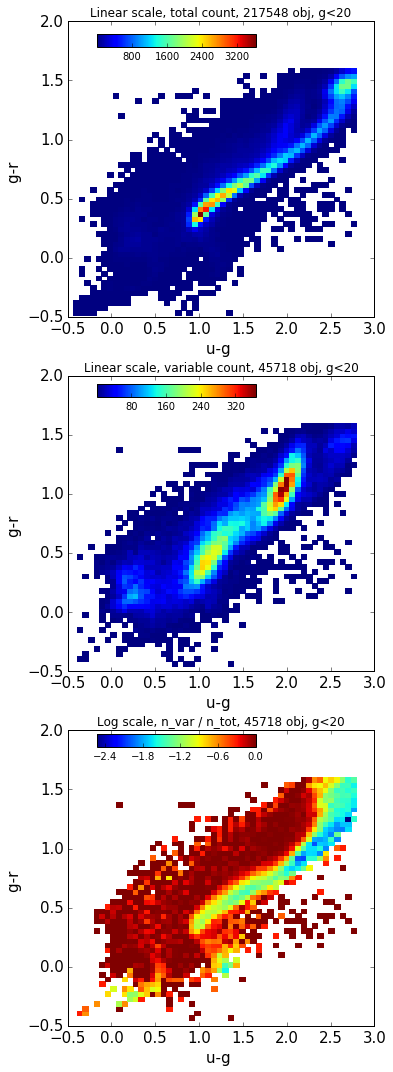

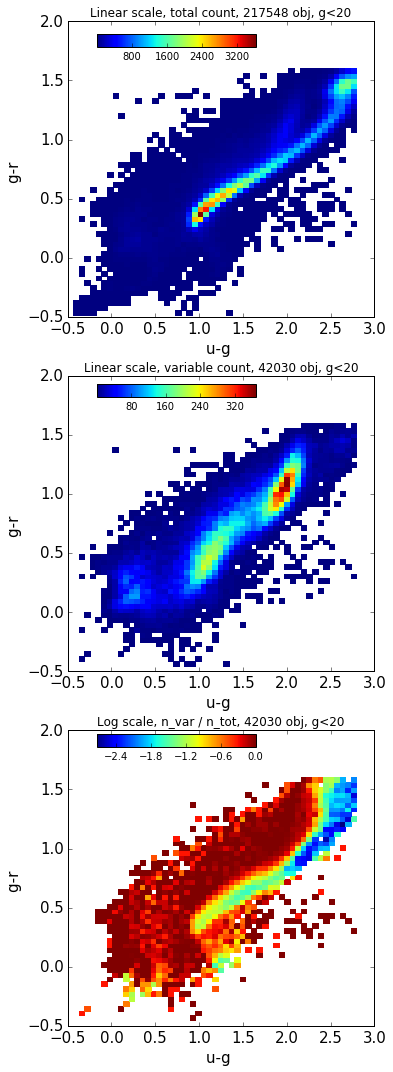

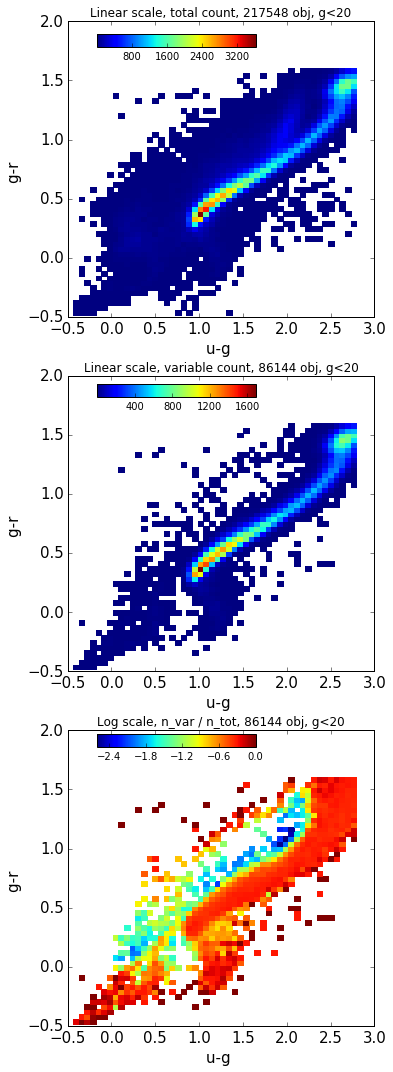

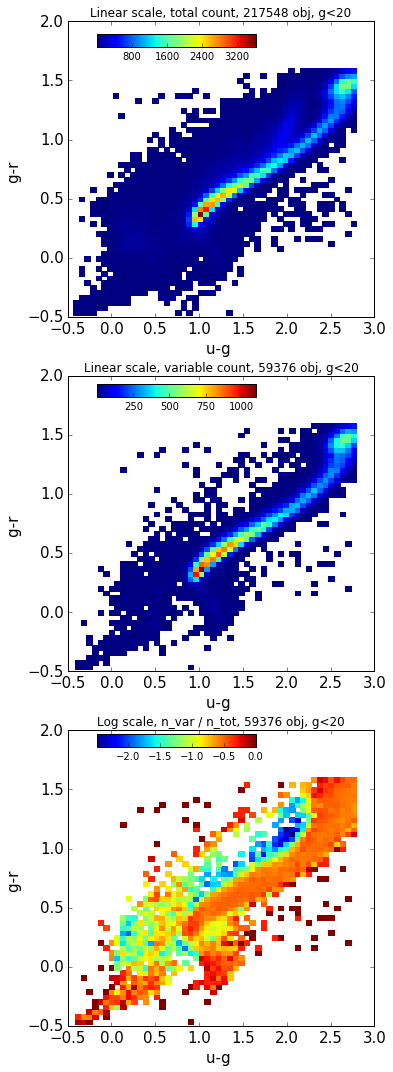

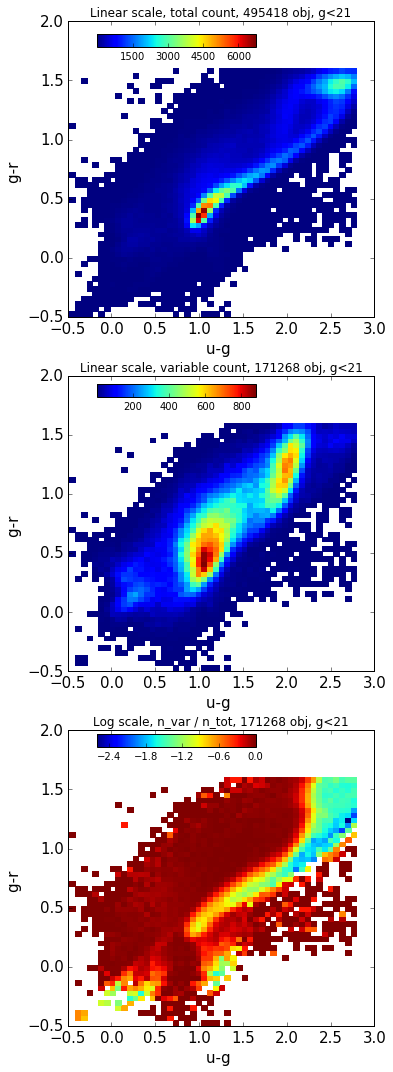

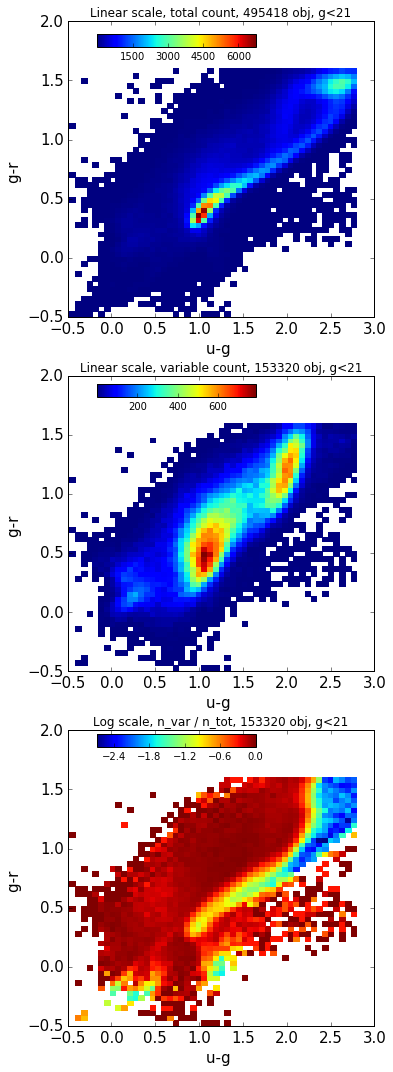

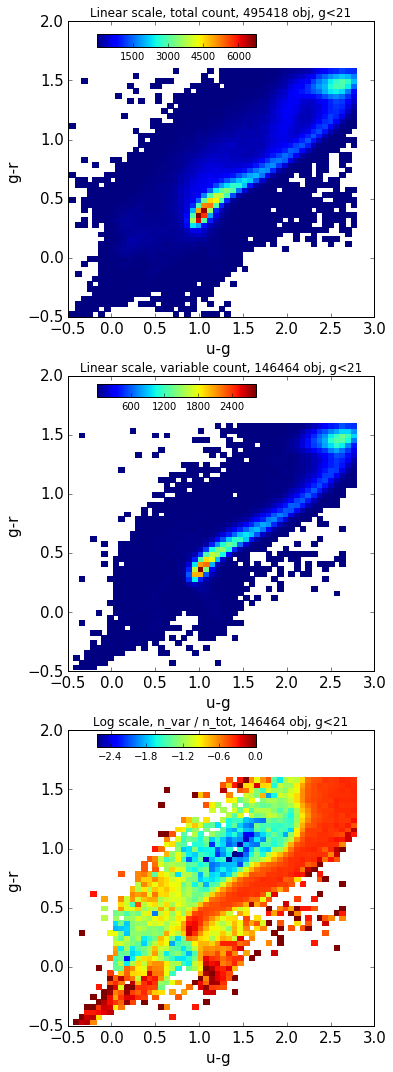

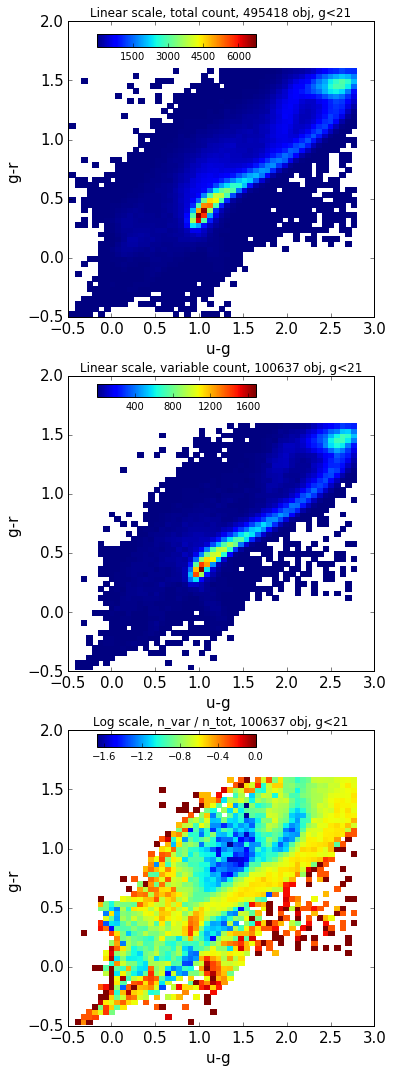

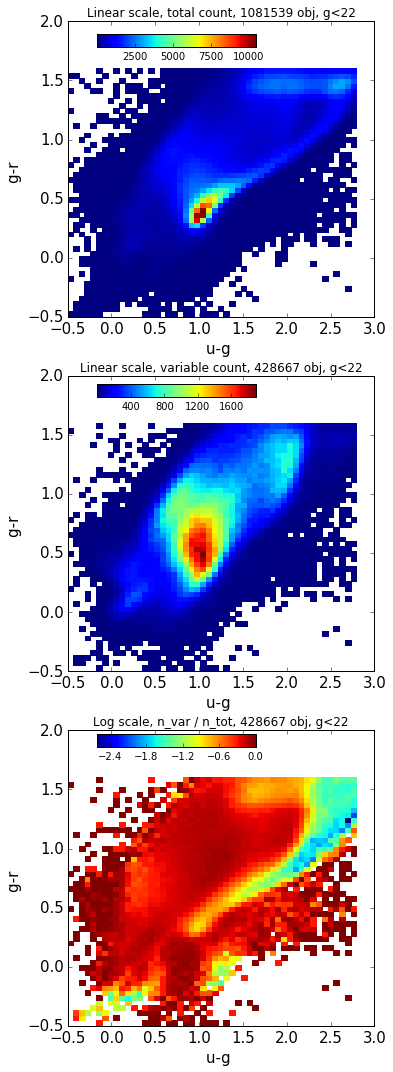

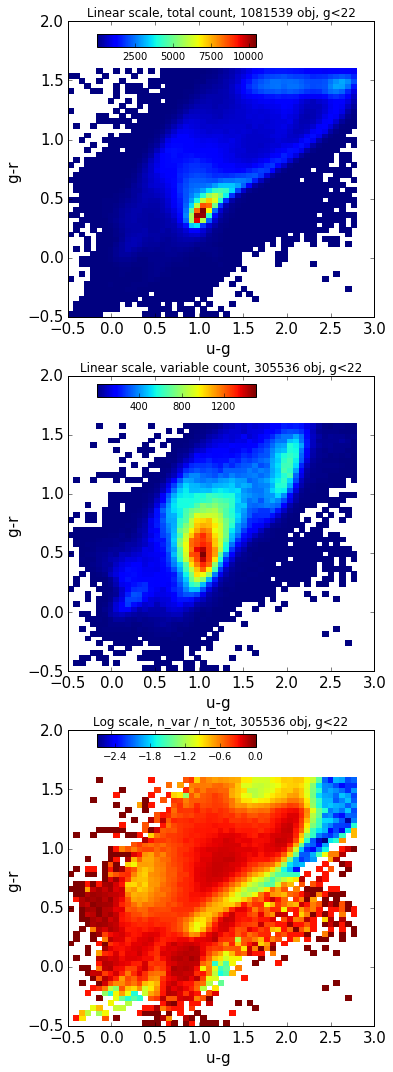

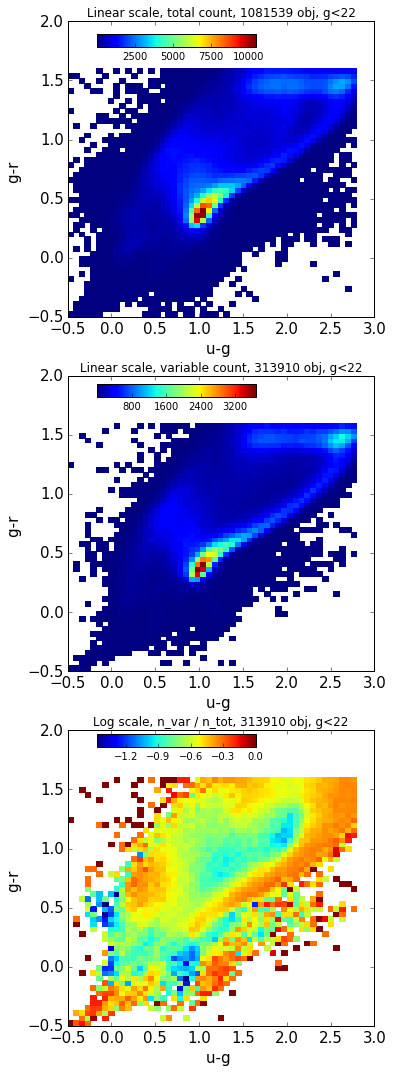

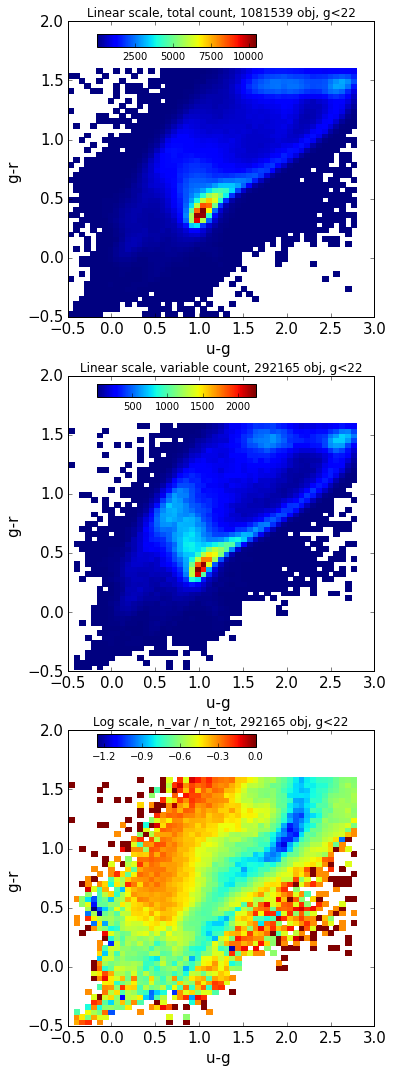

In [115]:
            
from itertools import product

%matplotlib inline

# Note : 
# when using astropy, instead of .values
# need to call .data.data .... 
# If need to use pandas,  make sure you do Edit --> Find and Replace ! 

u = data['upsfMean_corr'].data.data
g = data['gpsfMean_corr'].data.data
r = data['rpsfMean_corr'].data.data
ug = u - g
gr = g - r

gmax = 22.5
sample = 2
chi_boundary = 1.5

gmax_ = [20.5,21.5, 22.5]
sample_ = [1,2] 
chi_boundary_ = [1.5,2]

for gmax, sample, chi_boundary in product(gmax_, sample_,chi_ ):
    print('Using gmax=%.1f,sample=%d, chi_boundary=%.1f'%(gmax, sample,chi_boundary))            
            
    mask_brightness = g < gmax
    mask_ug = ((u-g)<2.8) & ((u-g)>-0.5)
    mask_gr = ((g-r)<1.6) & ((g-r)>-0.5)
    #mask_n_points_g = (data['gN'].data.data > 60) & (data['gN'].data.data < 160)
    #mask_n_points_r = (data['rN'].data.data > 60) & (data['rN'].data.data < 160)
    #mask_n_points_u = (data['uN'].data.data > 60) & (data['uN'].data.data < 160)
    #mask_n_points = mask_n_points_u & mask_n_points_g & mask_n_points_r
    mask_total = mask_ug & mask_gr & mask_brightness #& mask_n_points

    fig, ax = plt.subplots(3,1, figsize=(5.5,18))

    ############################
    # TOP PANEL :  TOTAL COUNT #
    ############################

    nObj = len(u[mask_total])
    stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                                values=ug[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

    # Plot 2D histogram using pcolor
    image = ax[0].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
    ax[0].set_xlabel('u-g ', fontsize=15)
    ax[0].set_ylabel('g-r ', fontsize=15)
    ax[0].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
    ax[0].tick_params(axis='both', which='major', labelsize=15) 

    colorbar_ax = fig.add_axes([0.2, 0.88, 0.4, 0.01])
    colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()


    ####################################
    # MIDDLE PANEL :  VARIABLE COUNT   #
    ####################################

    # select variable objects... 

    if sample == 1 : 
        mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data > chi_boundary)
    if sample == 2 :
        mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data < chi_boundary)


    mask_variable = mask_total & mask_sample

    nObj = len(u[mask_variable])

    # Calculate the count of variable sources...
    stats = binned_statistic_2d(x=ug[mask_variable], y=gr[mask_variable], values=ug[mask_variable], 
                                statistic='count', bins=50)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    # replace all nan's by 0 ...
    z_sigma[np.isnan(z_sigma)] =0 
    z_reduce  =  z_sigma 
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked_var = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

    # Plot 2D histogram using pcolor
    image = ax[1].pcolormesh(x_edges,y_edges,z_masked_var, cmap='jet')
    ax[1].set_xlabel('u-g ', fontsize=15)
    ax[1].set_ylabel('g-r ', fontsize=15)
    ax[1].set_title('Linear scale, variable count, %d obj, g<%d'%(nObj,gmax))
    ax[1].tick_params(axis='both', which='major', labelsize=15) 
    colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
    colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()

    ###################################################
    # BOTTOM PANEL :  VARIABLE COUNT / TOTAL COUNT    #
    ###################################################

    z_masked_ratio = z_masked_var / z_masked
    # Mask pixels with a value of zero

    # Plot 2D histogram using pcolor
    Z =  np.log10(z_masked_ratio)
    image = ax[2].pcolormesh(x_edges,y_edges, Z, cmap='jet', vmax = 0)
    ax[2].set_xlabel('u-g ', fontsize=15)
    ax[2].set_ylabel('g-r ', fontsize=15)
    ax[2].set_title('Log scale, n_var / n_tot, %d obj, g<%d'%(nObj,gmax))
    ax[2].tick_params(axis='both', which='major', labelsize=15) 

    colorbar_ax = fig.add_axes([0.2, 0.34, 0.4, 0.01])
    colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()

    #plt.tight_layout()

    # Saving the colorbar from being messed by the tight_layout()
    # http://matplotlib.org/users/tight_layout_guide.html

    fig.subplots_adjust(wspace=0.2)
    fname = outDir+'Fig3_test_sample'+str(sample)+'_chi_bound-'+str(chi_boundary)+'_gmax-'+str(gmax)+'.png'
    plt.savefig(fname,bbox_inches='tight')
    print('Saved as %s '%fname)



In [96]:
outDir

'/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/'

### Fig.3 test case : isolate the bridge .... 

Using gmax=20.5,sample=1, chi_boundary=1.5
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_bridge_sample1_chi_bound-1.5_gmax-20.5.png 
Using gmax=20.5,sample=1, chi_boundary=2.0
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_bridge_sample1_chi_bound-2_gmax-20.5.png 
Using gmax=20.5,sample=2, chi_boundary=1.5
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_bridge_sample2_chi_bound-1.5_gmax-20.5.png 
Using gmax=20.5,sample=2, chi_boundary=2.0
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_bridge_sample2_chi_bound-2_gmax-20.5.png 
Using gmax=21.5,sample=1, chi_boundary=1.5
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_bridge_sample1_chi_bound-1.5_gmax-21.5.png 
Using gmax=21.5,sample=1, chi_boundary=2.0
Saved as /Users/chris/Grad

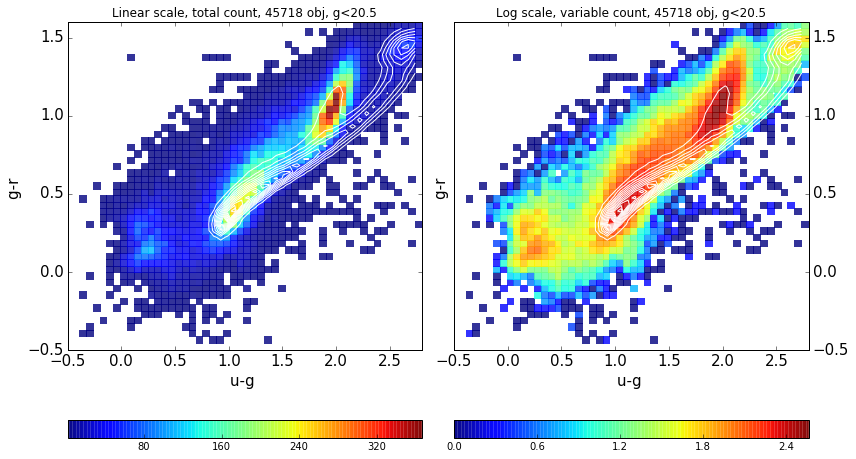

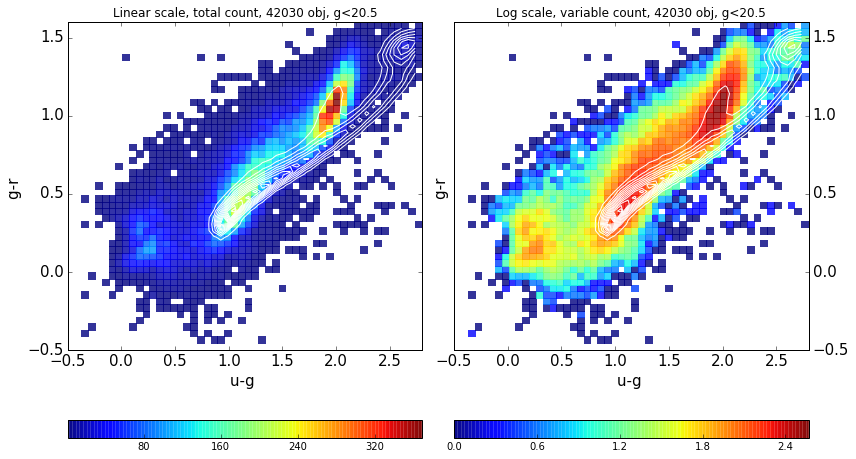

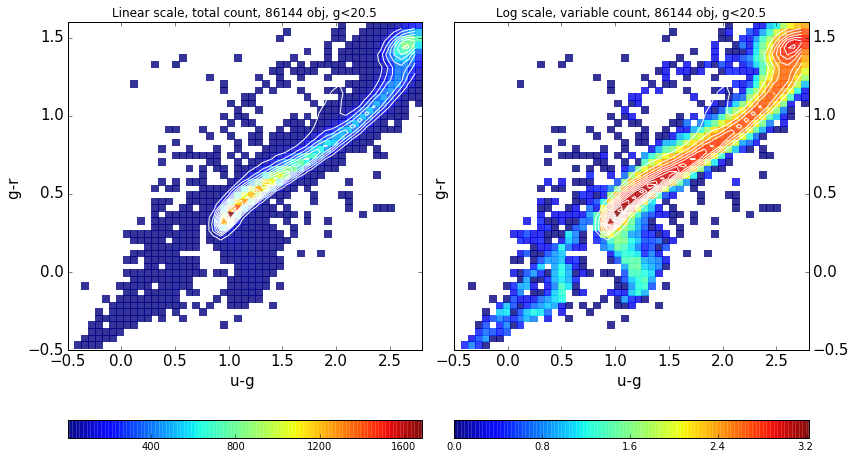

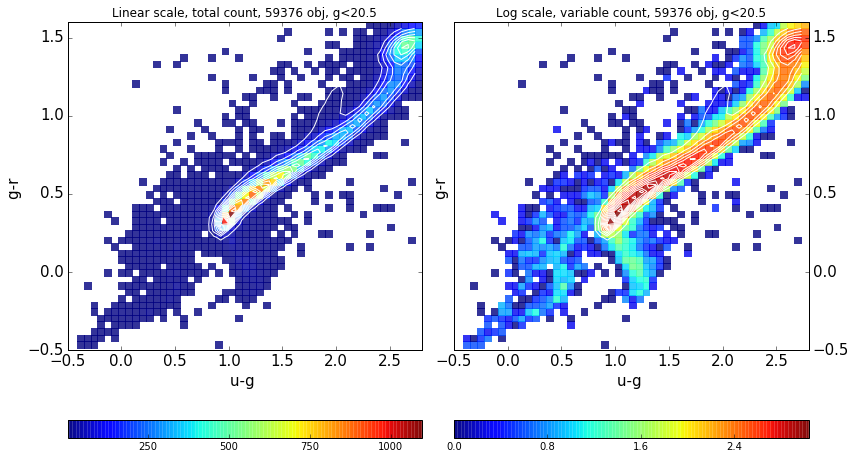

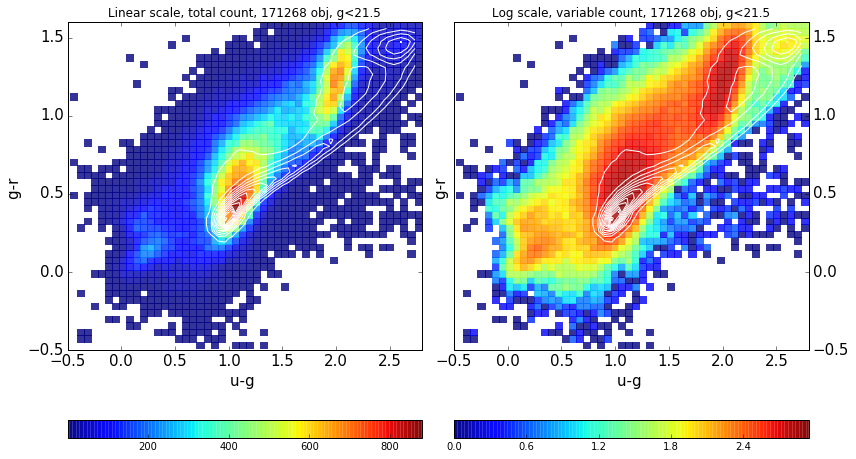

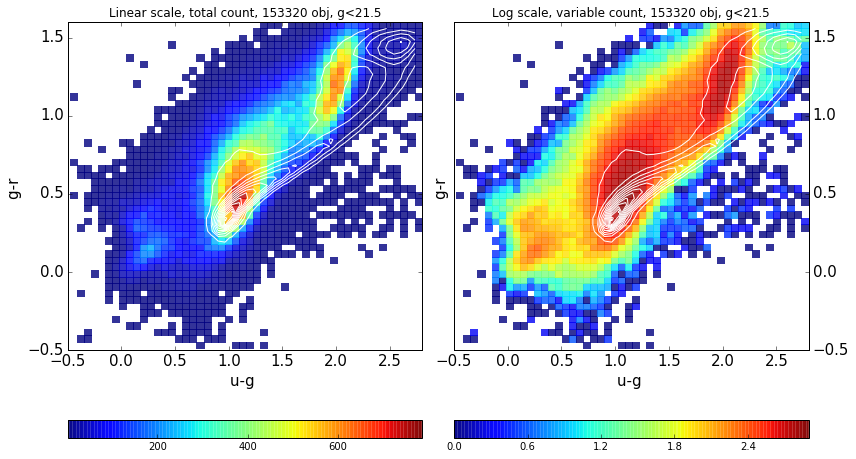

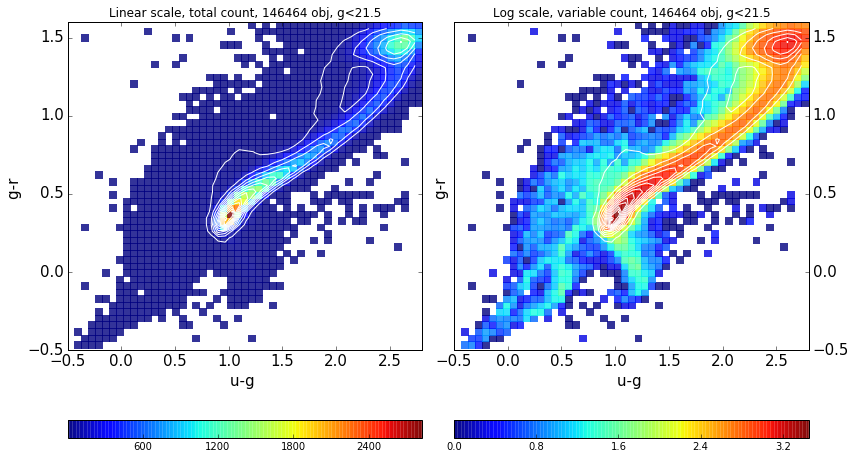

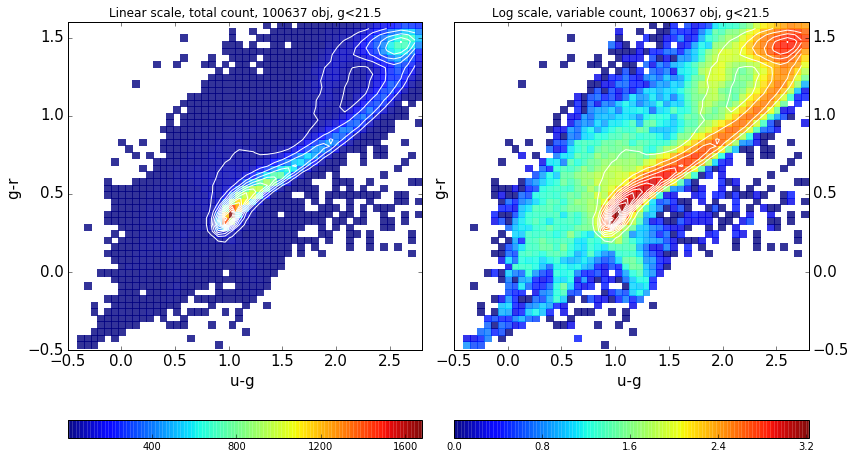

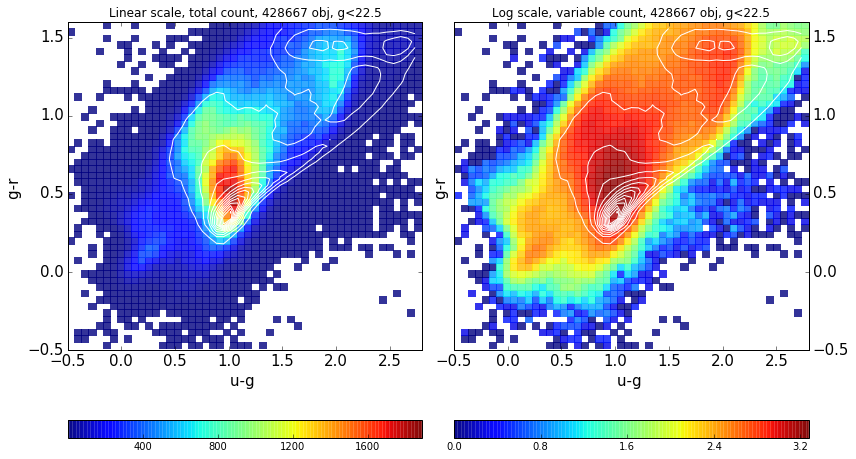

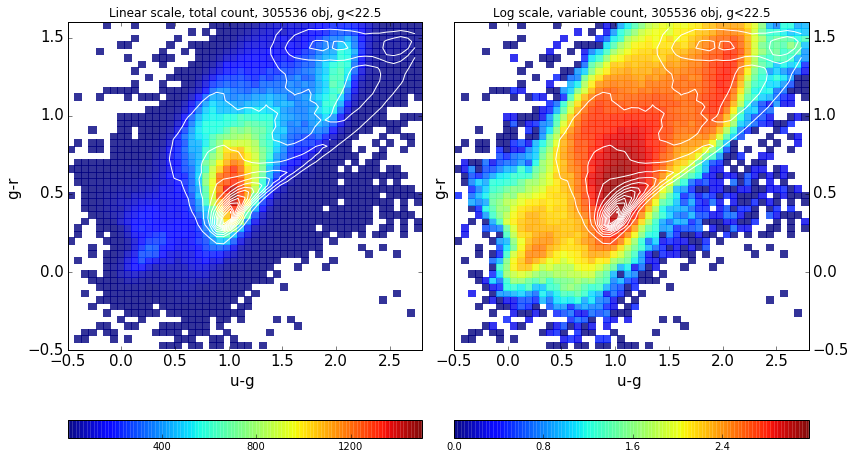

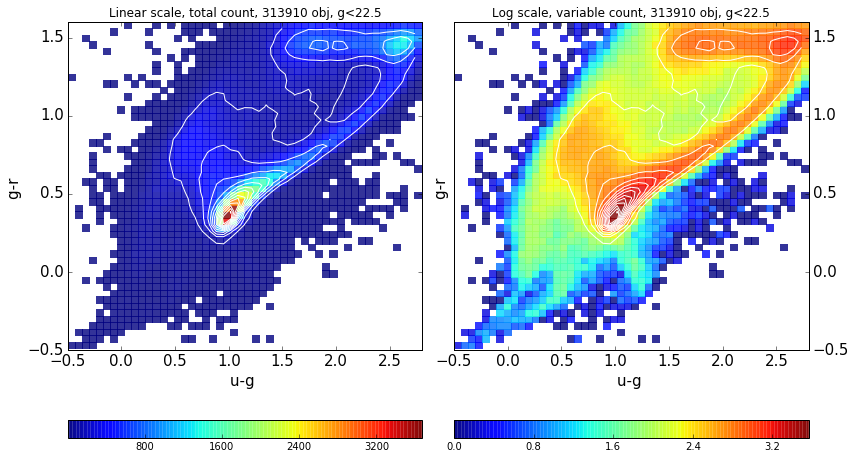

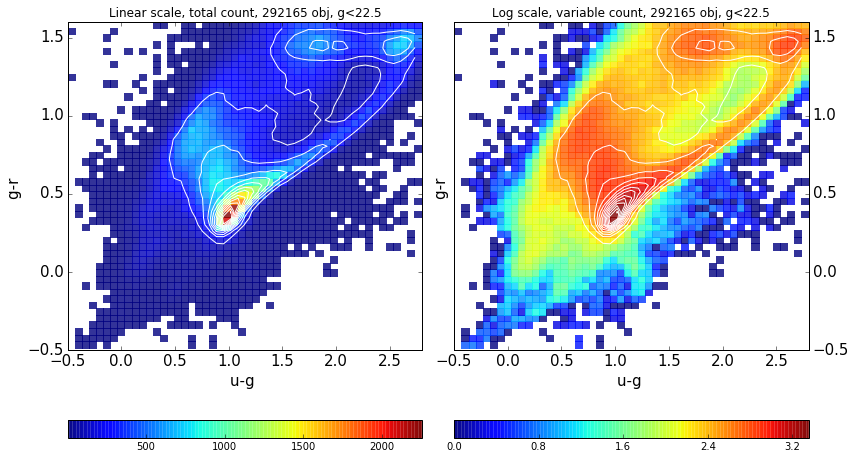

In [213]:
from matplotlib import ticker

gmax_ = [20.5,21.5, 22.5]
sample_ = [1,2] 
chi_boundary_ = [1.5,2]

for gmax, sample, chi_boundary in product(gmax_, sample_,chi_ ):
    print('Using gmax=%.1f,sample=%d, chi_boundary=%.1f'%(gmax, sample,chi_boundary))  
    
    mask_brightness = g < gmax
    xmin,xmax = -0.5, 2.8
    ymin,ymax = -0.5, 1.6 
    mask_ug = (xmin < (u-g)) & ((u-g) < xmax)
    mask_gr = (ymin < (g-r)) & ((g-r) < ymax)

    if sample == 1 : 
        mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data > chi_boundary)
    if sample == 2 :
        mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data < chi_boundary)

    # initialize the figure
    fig,axs = plt.subplots(1,2,figsize=(12,7))
    ax = np.ravel(axs)

    ################################
    # LEFT PANEL : LINEAR COUNTS 
    ################################
  

    # 1) plot contours of the full sample 

    mask_total = mask_ug & mask_gr & mask_brightness
    stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                                values=ug[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    contours = ax[0].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, 15, colors='white')


    # 2) overplot  variable count ... 

    mask_total = mask_ug & mask_gr & mask_brightness & mask_sample
    nObj = np.sum(mask_total)

    stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                                values=ug[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip <1  , z_rot_flip)

    # Plot 2D histogram using pcolor
    image = ax[0].pcolormesh(x_edges,y_edges,z_masked,  cmap='jet', alpha=0.8)

    # try using imshow.... 
    #image = ax.imshow(z_masked, alpha=0.6, origin='lower')
    ax[0].set_xlabel('u-g ', fontsize=15)
    ax[0].set_ylabel('g-r ', fontsize=15)
    ax[0].set_title('Linear scale, total count, %d obj, g<%.1f'%(nObj,gmax))
    ax[0].tick_params(axis='both', which='major', labelsize=15) 

    #colorbar_ax = fig.add_axes([0.2, 0.82, 0.4, 0.05])
    colorbar = fig.colorbar(image,  ax=ax[0], orientation='horizontal')
    #colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()



    ################################
    # RIGHT PANEL : LOG COUNTS 
    ################################


    # plot contours of total 
    mask_total = mask_ug & mask_gr & mask_brightness # & mask_sample


    stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                                values=ug[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    contours = ax[1].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, 15, colors='white')


    # plot colormesh of variable ... 
    mask_total = mask_ug & mask_gr & mask_brightness  & mask_sample
    nObj = np.sum(mask_total)

    stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                                values=ug[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip <1  , z_rot_flip)

    # Plot 2D histogram using pcolor
    image = ax[1].pcolormesh(x_edges,y_edges,np.log10(z_masked),  cmap='jet', alpha=0.8)


    # try using imshow.... 
    #image = ax.imshow(z_masked, alpha=0.6, origin='lower')
    ax[1].set_xlabel('u-g ', fontsize=15)
    ax[1].set_ylabel('g-r ', fontsize=15)
    ax[1].set_title('Log scale, variable count, %d obj, g<%.1f'%(nObj,gmax))
    ax[1].tick_params(axis='both', which='major', labelsize=15) 
    ax[1].yaxis.set_ticks_position('right')

    #colorbar_ax = fig.add_axes([0.2, 0.82, 0.4, 0.05])
    colorbar = fig.colorbar(image,  ax=ax[1], orientation='horizontal')
    #colorbar = fig.colorbar(image, use_gridspec=True,orientation='horizontal')

    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()

    for i in range(len(ax)):
        ax[i].set_xlim(xmin,xmax)
        ax[i].set_ylim(ymin,ymax)

    #fig.subplots_adjust(hspace=0.8)

    plt.tight_layout()

    fname = outDir+'Fig3_bridge_sample'+str(sample)+'_chi_bound-'+str(chi_boundary)+'_gmax-'+str(gmax)+'.png'
    plt.savefig(fname)
    print('Saved as %s '%fname)

In [223]:
glim

array([ 17. ,  17.5,  18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,
        21.5,  22. ,  22.5])

Using gmax=21.5,sample=2, chi_boundary=2.0
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_slices_sample2_chi_bound-2_g-17.0_17.5.png 
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_slices_sample2_chi_bound-2_g-17.5_18.0.png 
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_slices_sample2_chi_bound-2_g-18.0_18.5.png 
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_slices_sample2_chi_bound-2_g-18.5_19.0.png 
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_slices_sample2_chi_bound-2_g-19.0_19.5.png 
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_slices_sample2_chi_bound-2_g-19.5_20.0.png 
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-1

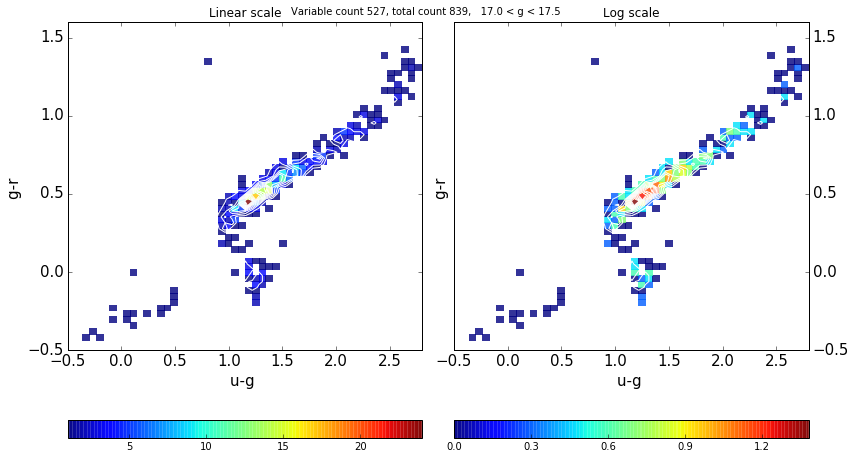

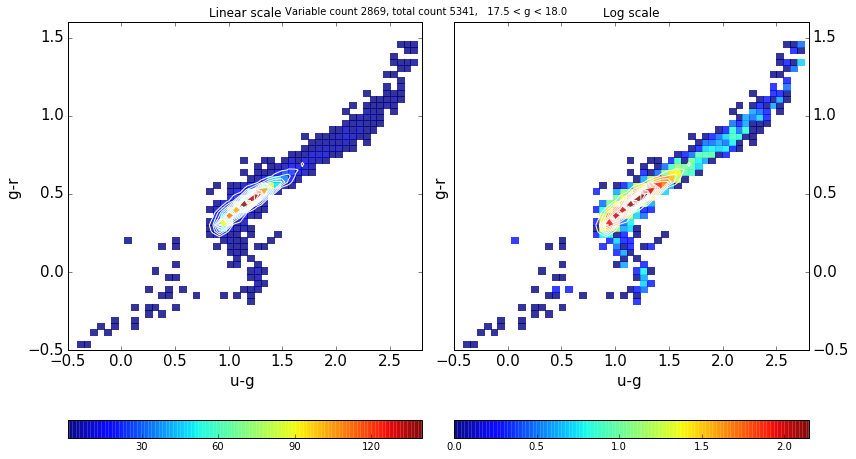

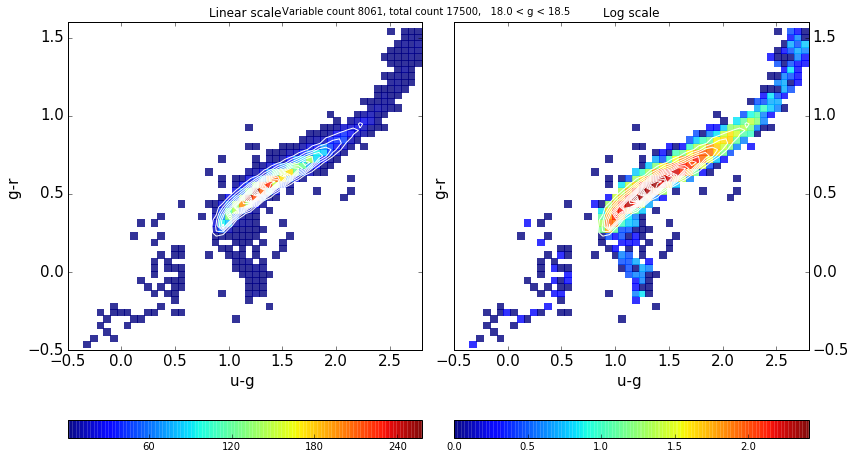

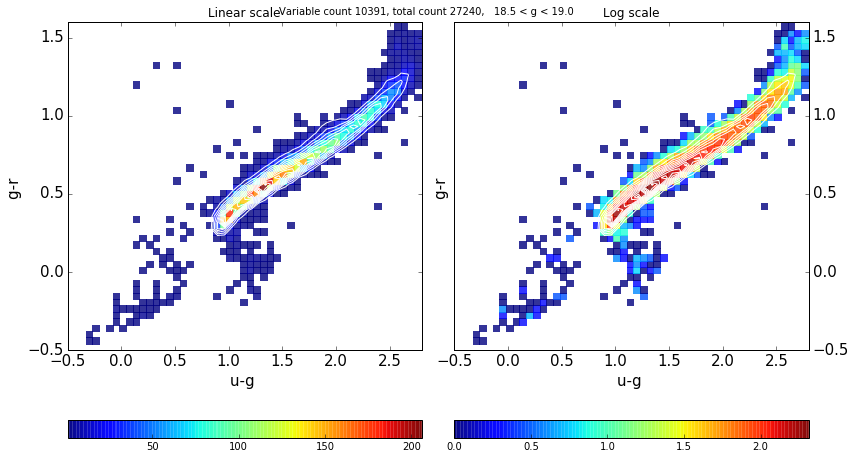

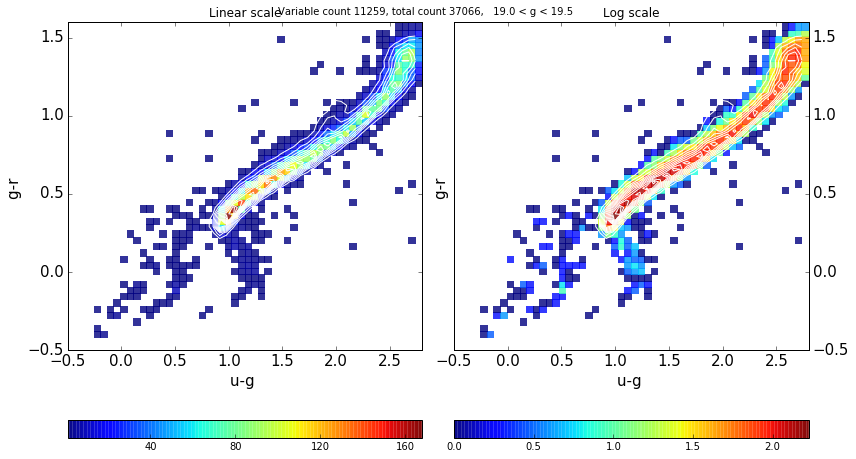

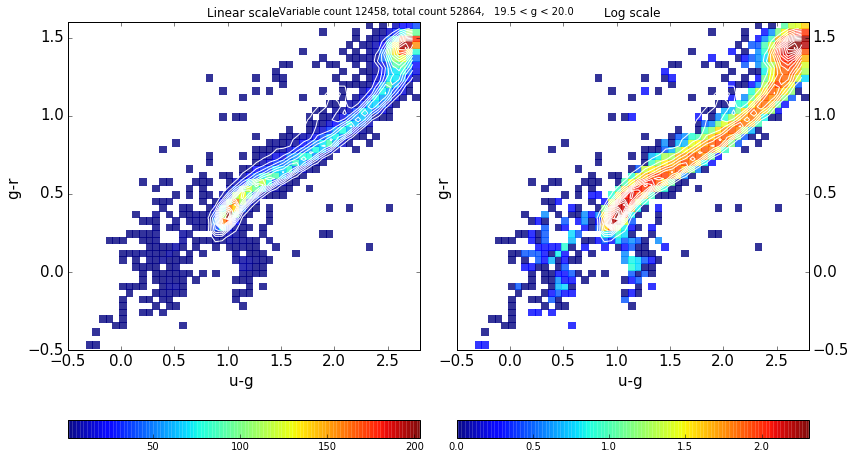

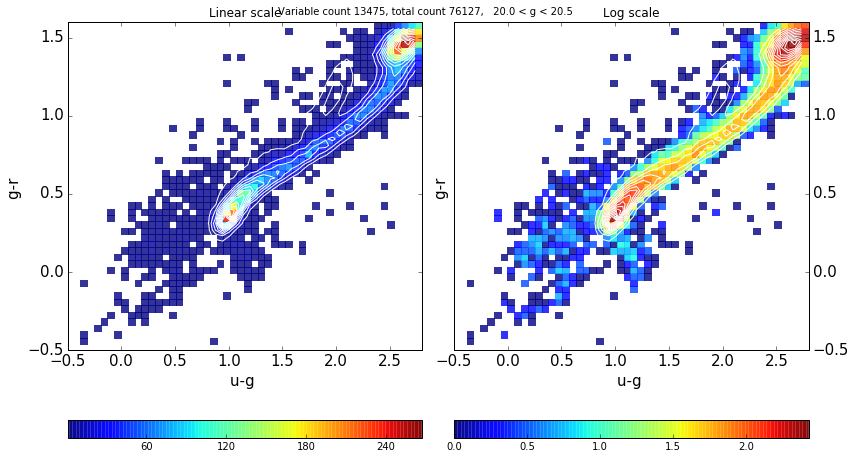

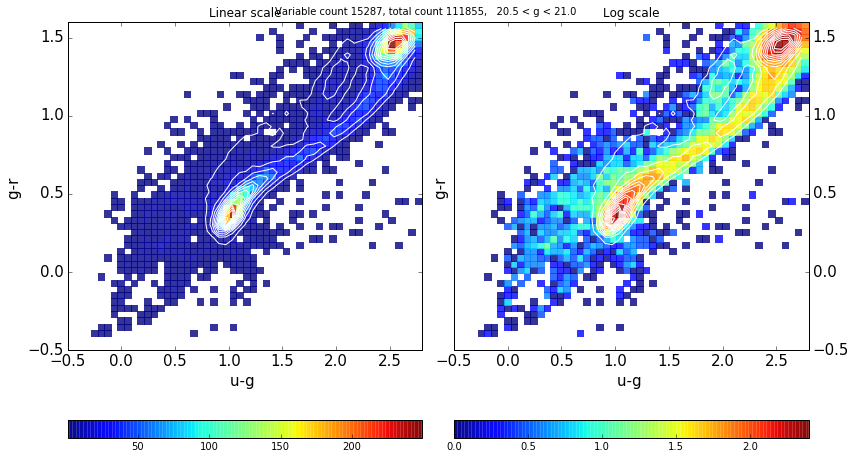

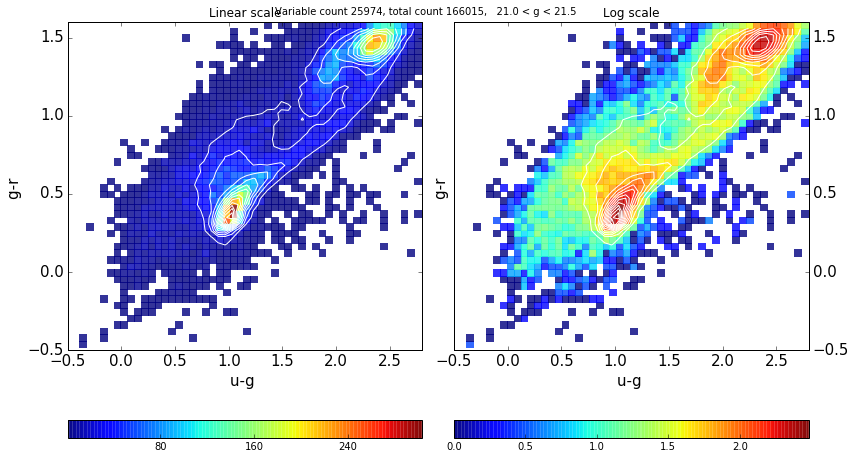

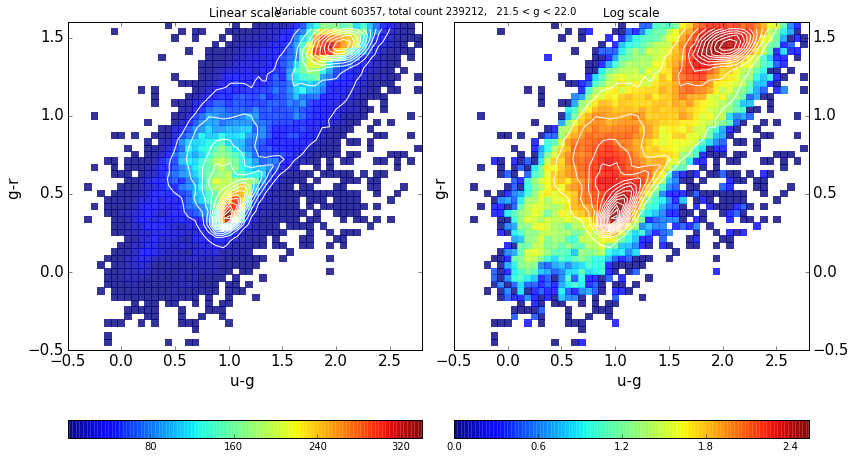

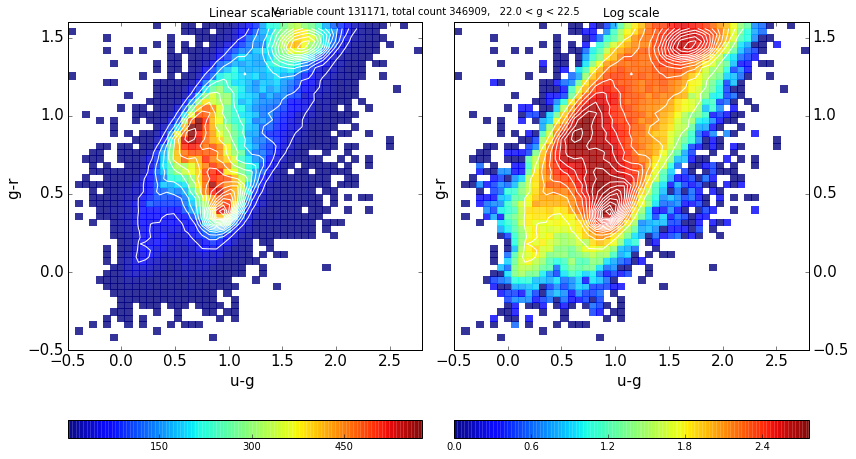

In [224]:
from matplotlib import ticker

gmax_ = [20.5,21.5, 22.5]
sample_ = [1,2] 
chi_boundary_ = [1.5,2]

#for gmax, sample, chi_boundary in product(gmax_, sample_,chi_ ):
print('Using gmax=%.1f,sample=%d, chi_boundary=%.1f'%(gmax, sample,chi_boundary))  

glim = np.arange(17,23,0.5)
for i in range(len(glim)-1) : 
    gmin, gmax = glim[i], glim[i+1]

    mask_brightness = (gmin < g) &  (g < gmax)
    xmin,xmax = -0.5, 2.8
    ymin,ymax = -0.5, 1.6 
    mask_ug = (xmin < (u-g)) & ((u-g) < xmax)
    mask_gr = (ymin < (g-r)) & ((g-r) < ymax)

    if sample == 1 : 
        mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data > chi_boundary)
    if sample == 2 :
        mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data < chi_boundary)

    # initialize the figure
    fig,axs = plt.subplots(1,2,figsize=(12,7))
    ax = np.ravel(axs)

    ################################
    # LEFT PANEL : LINEAR COUNTS 
    ################################


    # 1) plot contours of the full sample 

    mask_total = mask_ug & mask_gr & mask_brightness
    stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                                values=ug[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    contours = ax[0].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, 15, colors='white')


    # 2) overplot  variable count ... 

    mask_total = mask_ug & mask_gr & mask_brightness & mask_sample
    nObj = np.sum(mask_total)

    stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                                values=ug[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip <1  , z_rot_flip)

    # Plot 2D histogram using pcolor
    image = ax[0].pcolormesh(x_edges,y_edges,z_masked,  cmap='jet', alpha=0.8)

    # try using imshow.... 
    #image = ax.imshow(z_masked, alpha=0.6, origin='lower')
    ax[0].set_xlabel('u-g ', fontsize=15)
    ax[0].set_ylabel('g-r ', fontsize=15)
    ax[0].set_title('Linear scale')
    ax[0].tick_params(axis='both', which='major', labelsize=15) 

    #colorbar_ax = fig.add_axes([0.2, 0.82, 0.4, 0.05])
    colorbar = fig.colorbar(image,  ax=ax[0], orientation='horizontal')
    #colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()



    ################################
    # RIGHT PANEL : LOG COUNTS 
    ################################


    # plot contours of total 
    mask_total = mask_ug & mask_gr & mask_brightness # & mask_sample
    nTot = np.sum(mask_total)

    stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                                values=ug[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    contours = ax[1].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, 15, colors='white')


    # plot colormesh of variable ... 
    mask_total = mask_ug & mask_gr & mask_brightness  & mask_sample
    nVar = np.sum(mask_total)

    stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                                values=ug[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip <1  , z_rot_flip)

    # Plot 2D histogram using pcolor
    image = ax[1].pcolormesh(x_edges,y_edges,np.log10(z_masked),  cmap='jet', alpha=0.8)


    # try using imshow.... 
    #image = ax.imshow(z_masked, alpha=0.6, origin='lower')
    ax[1].set_xlabel('u-g ', fontsize=15)
    ax[1].set_ylabel('g-r ', fontsize=15)
    ax[1].set_title('Log scale')
    ax[1].tick_params(axis='both', which='major', labelsize=15) 
    ax[1].yaxis.set_ticks_position('right')

    #colorbar_ax = fig.add_axes([0.2, 0.82, 0.4, 0.05])
    colorbar = fig.colorbar(image,  ax=ax[1], orientation='horizontal')
    #colorbar = fig.colorbar(image, use_gridspec=True,orientation='horizontal')

    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()

    for i in range(len(ax)):
        ax[i].set_xlim(xmin,xmax)
        ax[i].set_ylim(ymin,ymax)

    #fig.subplots_adjust(hspace=0.8)
    fig.suptitle('Variable count %d, total count %d,   %.1f < g < %.1f '%(nVar, nTot, gmin, gmax))
    plt.tight_layout()

    fname = outDir+'Fig3_slices_sample'+str(sample)+'_chi_bound-'+str(chi_boundary)+'_g-'+str(gmin)+'_'+str(gmax)+'.png'
    plt.savefig(fname)
    print('Saved as %s '%fname)

Using gmax=21.5,sample=1, chi_boundary=2.0
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig3_bridge_cutout_sample1_chi_bound-2_gmax-21.5_ext_1.png 


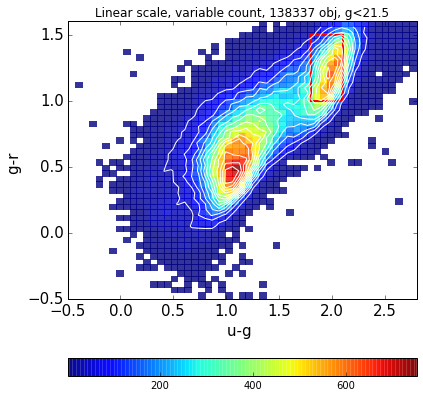

In [263]:
from matplotlib import ticker
import matplotlib.patches as patches

gmax_ = [20.5,21.5, 22.5]
sample_ = [1,2] 
chi_boundary_ = [1.5,2]

#for gmax, sample, chi_boundary in product(gmax_, sample_,chi_ ):

gmax = 21.5
sample = 1 
chi_boundary = 2 

print('Using gmax=%.1f,sample=%d, chi_boundary=%.1f'%(gmax, sample,chi_boundary))  

mask_brightness = g < gmax
xmin,xmax = -0.5, 2.8
ymin,ymax = -0.5, 1.6 
mask_ug = (xmin < (u-g)) & ((u-g) < xmax)
mask_gr = (ymin < (g-r)) & ((g-r) < ymax)

if sample == 1 : 
    mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data > chi_boundary)
if sample == 2 :
    mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data < chi_boundary)

ext = 1
mask_ext = data['extendedness'].data.data == ext

# initialize the figure
fig,ax = plt.subplots(1,1,figsize=(6,6))


################################
# LEFT PANEL : LINEAR COUNTS 
################################


# 1) plot contours of the full sample 

mask_total = mask_ug & mask_gr & mask_brightness & mask_ext
stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
contours = ax.contour(x_edges[:-1], y_edges[:-1], z_rot_flip, 15, colors='white')


# 2) overplot  variable count ... 

mask_total = mask_ug & mask_gr & mask_brightness & mask_sample & mask_ext
nObj = np.sum(mask_total)

stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip <1  , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges,z_masked,  cmap='jet', alpha=0.8)

# try using imshow.... 
#image = ax.imshow(z_masked, alpha=0.6, origin='lower')
ax.set_xlabel('u-g ', fontsize=15)
ax.set_ylabel('g-r ', fontsize=15)
ax.set_title('Linear scale, variable count, %d obj, g<%.1f'%(nObj,gmax))
ax.tick_params(axis='both', which='major', labelsize=15) 



#colorbar_ax = fig.add_axes([0.2, 0.82, 0.4, 0.05])
colorbar = fig.colorbar(image,  ax=ax, orientation='horizontal')
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

tick_locator = ticker.MaxNLocator(nbins=5)
colorbar.locator = tick_locator
colorbar.update_ticks()

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

ax.add_patch(patches.Rectangle((1.8, 1),0.3,0.5,fill=False,linewidth=2,edgecolor='r',facecolor='none'))

plt.tight_layout()

fname = outDir+'Fig3_bridge_cutout_sample'+str(sample)+'_chi_bound-'+str(chi_boundary)+'_gmax-'+str(gmax)+'_ext_'+str(ext)+'.png'
plt.savefig(fname)
print('Saved as %s '%fname)

In [ ]:

################################
# RIGHT PANEL : LOG COUNTS 
################################


# plot contours of total 
mask_total = mask_ug & mask_gr & mask_brightness # & mask_sample


stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
contours = ax[1].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, 15, colors='white')


# plot colormesh of variable ... 
mask_total = mask_ug & mask_gr & mask_brightness  & mask_sample
nObj = np.sum(mask_total)

stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip <1  , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax[1].pcolormesh(x_edges,y_edges,np.log10(z_masked),  cmap='jet', alpha=0.8)


# try using imshow.... 
#image = ax.imshow(z_masked, alpha=0.6, origin='lower')
ax[1].set_xlabel('u-g ', fontsize=15)
ax[1].set_ylabel('g-r ', fontsize=15)
ax[1].set_title('Log scale, variable count, %d obj, g<%.1f'%(nObj,gmax))
ax[1].tick_params(axis='both', which='major', labelsize=15) 
ax[1].yaxis.set_ticks_position('right')

#colorbar_ax = fig.add_axes([0.2, 0.82, 0.4, 0.05])
colorbar = fig.colorbar(image,  ax=ax[1], orientation='horizontal')
#colorbar = fig.colorbar(image, use_gridspec=True,orientation='horizontal')

tick_locator = ticker.MaxNLocator(nbins=5)
colorbar.locator = tick_locator
colorbar.update_ticks()



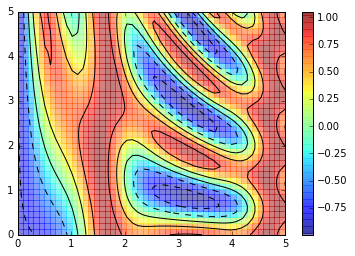

In [174]:
def f(x, y):
    return np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)

x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 40)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)


contours = plt.contour(X,Y,Z, 5, colors='black')
plt.pcolormesh(X,Y,Z, alpha=0.5)
#plt.clabel(contours, inline=True, fontsize=8)

# works : imshow smears the pixels so that it's not so sharp...
#plt.imshow(Z, extent=[0, 5, 0, 5], origin='lower',        cmap='RdGy', alpha=0.5)

# works less nice:  if transparency is on, the edges of pixels make a gridding suddenly appear...
# here I see almost no difference between pcolor and pcolormesh ... 
#plt.pcolor(X,Y,Z, alpha=0.5)

plt.colorbar();


### Sesar 2007 , Fig.4

Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-15/Fig4_test_g_lt21.png 


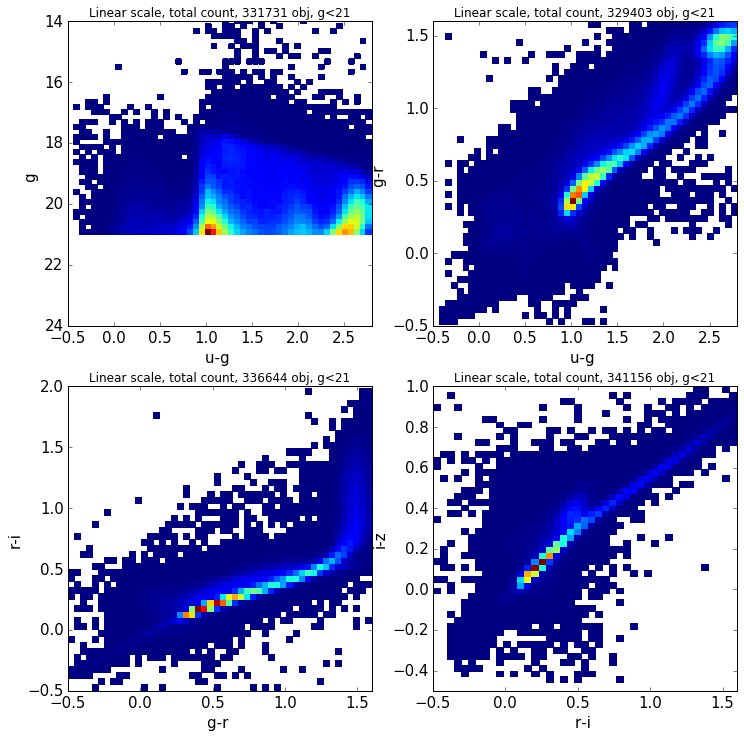

In [19]:
%matplotlib inline
u = data['upsfMean_corr'].data.data
g = data['gpsfMean_corr'].data.data
r = data['rpsfMean_corr'].data.data
i = data['ipsfMean_corr'].data.data
z = data['zpsfMean_corr'].data.data

ug = u-g
gr = g-r
ri = r-i
iz = i-z

# limits below based on Sesar 2007 Fig.4
gmax = 21
mask_g = g < gmax
mask_ug = ((ug)<2.8) & ((ug)>-0.5)
mask_gr = ((gr)<1.6) & ((gr)>-0.5)
mask_ri = ((ri)<2.0) & ((ri)>-0.5)
mask_iz = ((iz)<1.0) & ((iz)>-0.5)

# use some variability measure...


fig, axs = plt.subplots(2,2, figsize=(12,12))
ax = np.ravel(axs)
ax[0].invert_yaxis()
ax[0].set_xlim(-0.5,2.8)
ax[0].set_ylim(24,14)

ax[1].set_xlim(-0.5,2.8)
ax[1].set_ylim(-0.5,1.6)

ax[2].set_xlim(-0.5, 1.6)
ax[2].set_ylim(-0.5, 2.0)

ax[3].set_xlim(-0.5,1.6)
ax[3].set_ylim(-0.5, 1.0)

# TOP_LEFT  : g vs u-g  

mask_total = mask_g  & mask_ug
nObj = len(g[mask_total])
stats = binned_statistic_2d(x=ug[mask_total], y=g[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax[0].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
ax[0].set_xlabel('u-g ', fontsize=15)
ax[0].set_ylabel('g ', fontsize=15)
ax[0].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
ax[0].tick_params(axis='both', which='major', labelsize=15) 


#colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')


# TOP_RIGHT  : u-g vs g-r
mask_total = mask_g & mask_gr  & mask_ug
nObj = len(gr[mask_total])
stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax[1].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
ax[1].set_xlabel('u-g ', fontsize=15)
ax[1].set_ylabel('g-r ', fontsize=15)
ax[1].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
ax[1].tick_params(axis='both', which='major', labelsize=15) 
#ax[0].invert_yaxis()
#colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')


# BOTTOM_LEFT :  g-r vs r-i
mask_total = mask_g & mask_gr  & mask_ri
nObj = len(gr[mask_total])
stats = binned_statistic_2d(x=gr[mask_total], y=ri[mask_total], 
                            values=gr[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax[2].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
ax[2].set_xlabel('g-r ', fontsize=15)
ax[2].set_ylabel('r-i', fontsize=15)
ax[2].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
ax[2].tick_params(axis='both', which='major', labelsize=15) 
#ax[0].invert_yaxis()
#colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')



# BOTTOM_RIGHT :   r-i vs i-z
mask_total = mask_g & mask_iz  & mask_ri
nObj = len(ri[mask_total])
stats = binned_statistic_2d(x=ri[mask_total], y=iz[mask_total], 
                            values=ri[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
j = 3
image = ax[j].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
ax[j].set_xlabel('r-i ', fontsize=15)
ax[j].set_ylabel('i-z', fontsize=15)
ax[j].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
ax[j].tick_params(axis='both', which='major', labelsize=15) 
#ax[0].invert_yaxis()
#colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')




fname = outDir+'Fig4_test_g_lt'+str(gmax)+'.png'
plt.savefig(fname)
print('Saved as %s '%fname)






### Sesar 2007 , Fig.4, sample1 and sample2 , contour the full distr

Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig4_test_sample1_chi_bound-1.5_gmax-20.5.png 
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig4_test_sample1_chi_bound-2_gmax-20.5.png 
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig4_test_sample2_chi_bound-1.5_gmax-20.5.png 
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig4_test_sample2_chi_bound-2_gmax-20.5.png 
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig4_test_sample1_chi_bound-1.5_gmax-21.5.png 
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig4_test_sample1_chi_bound-2_gmax-21.5.png 
Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig4_test_sample2_chi_bound-1.5_gmax-21.5.png 
Saved as /Us

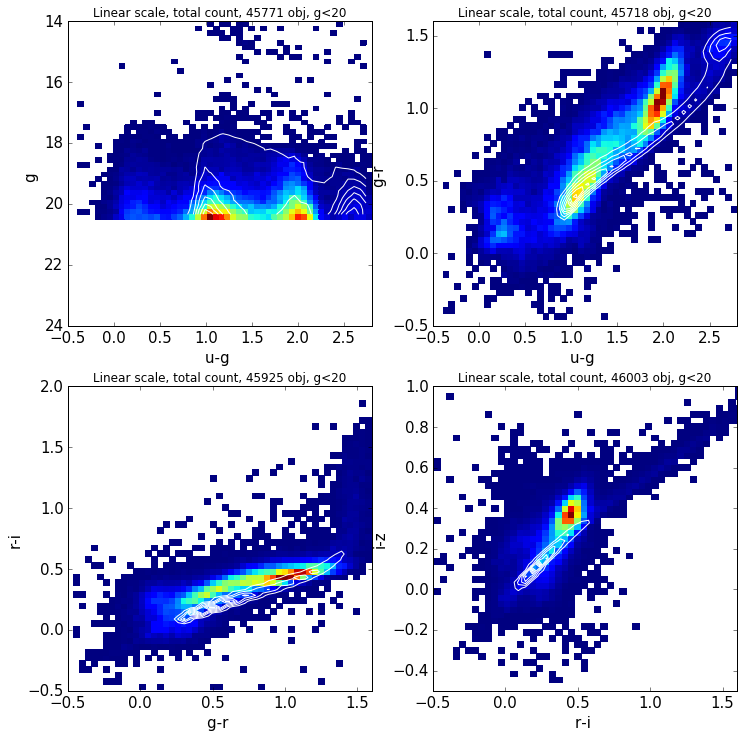

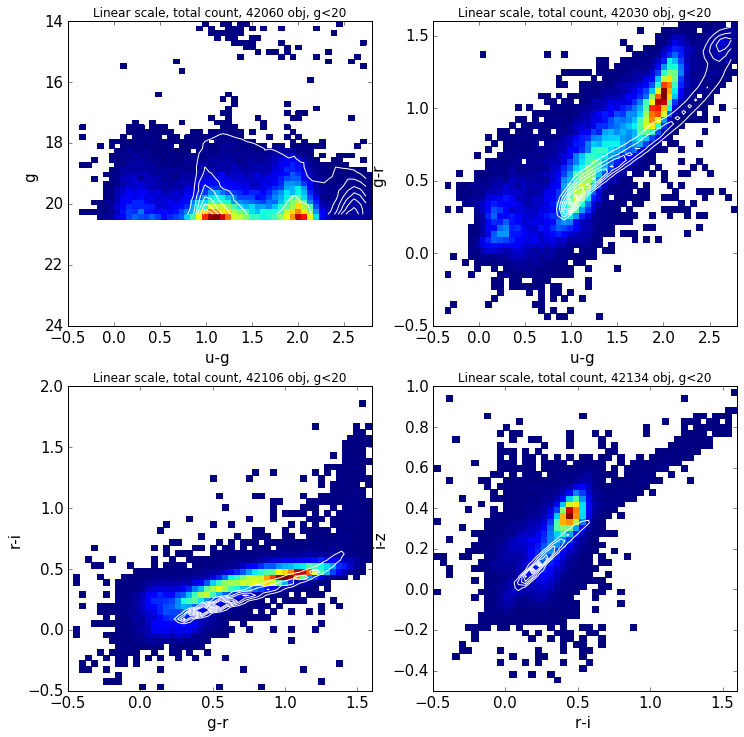

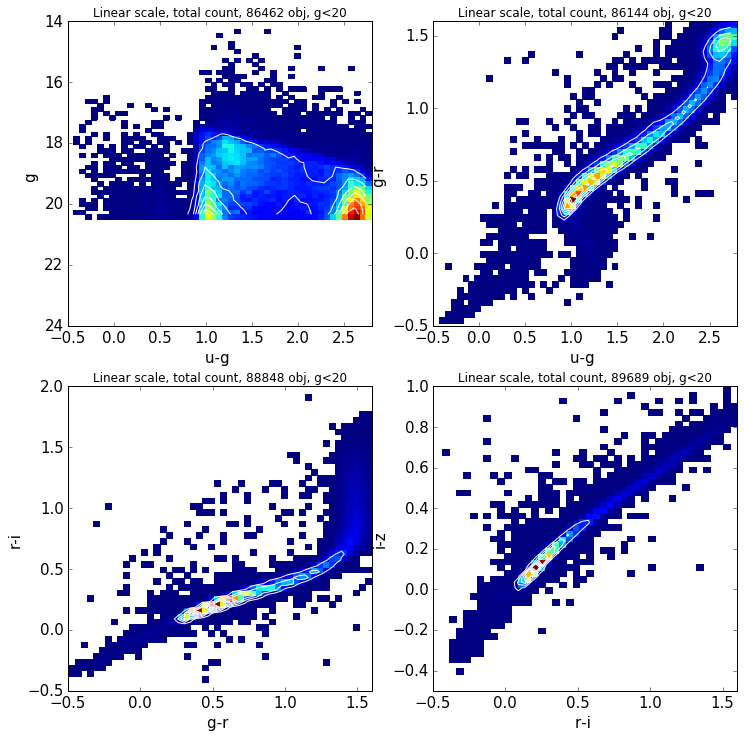

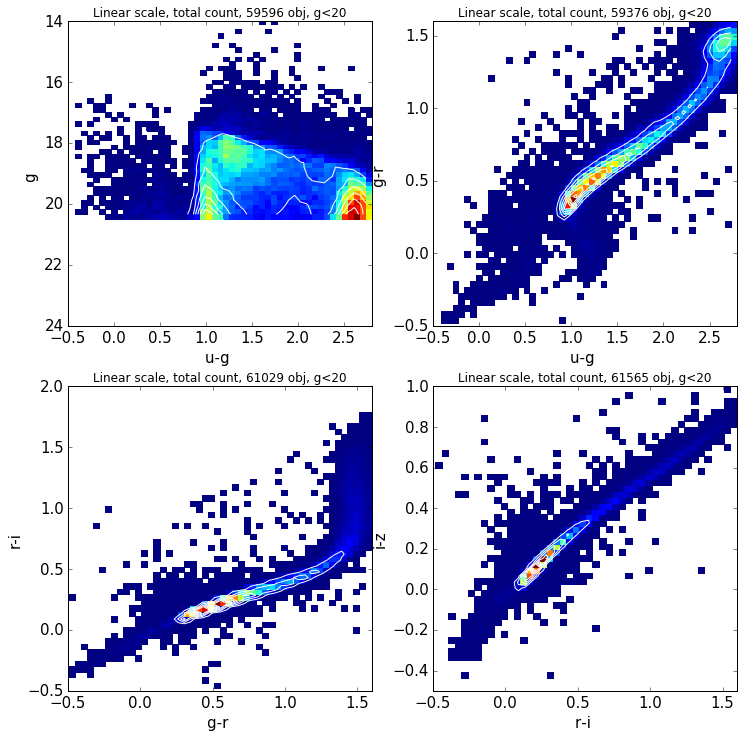

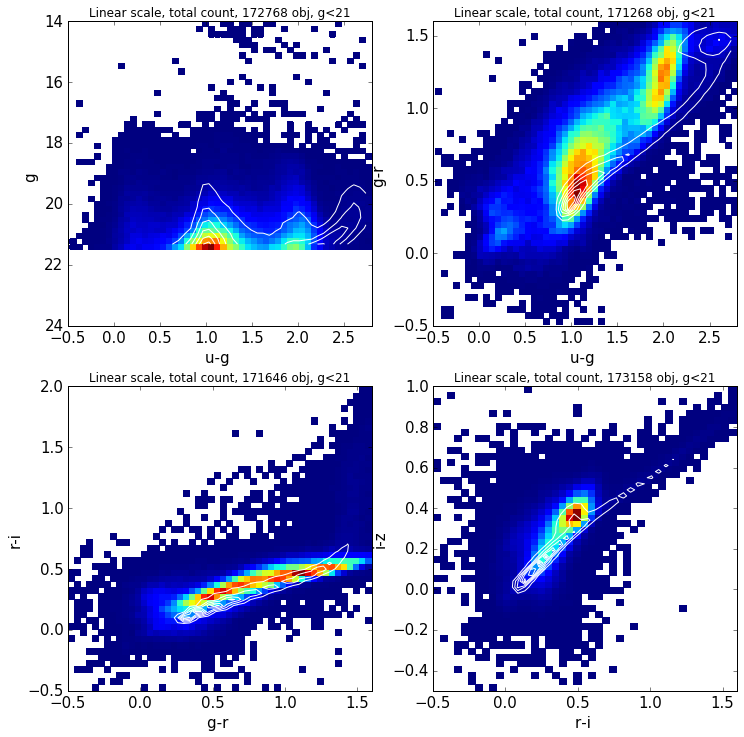

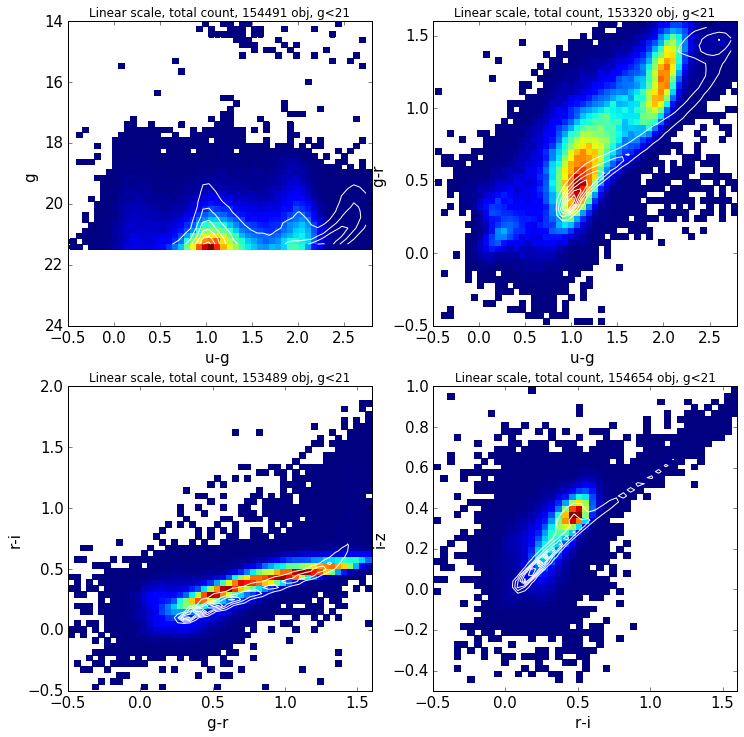

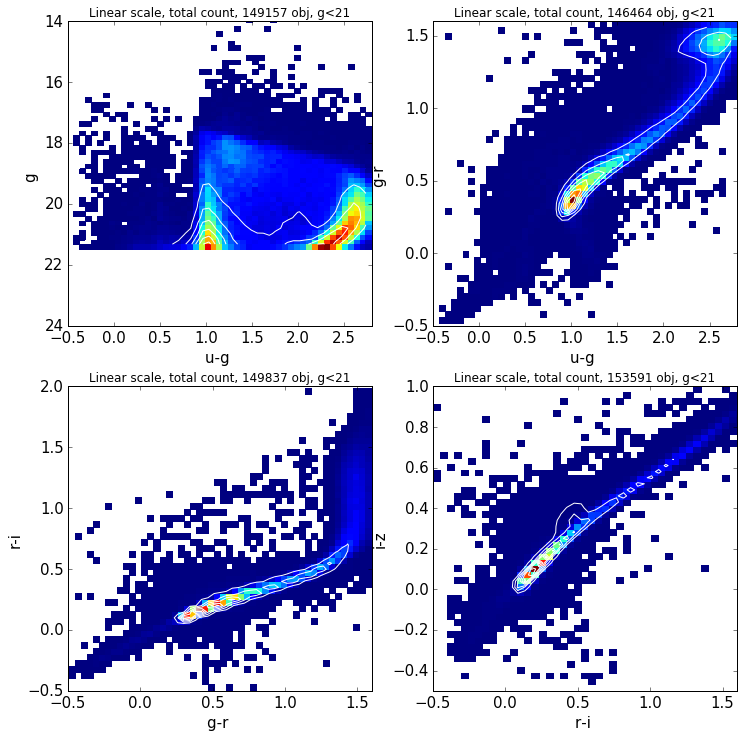

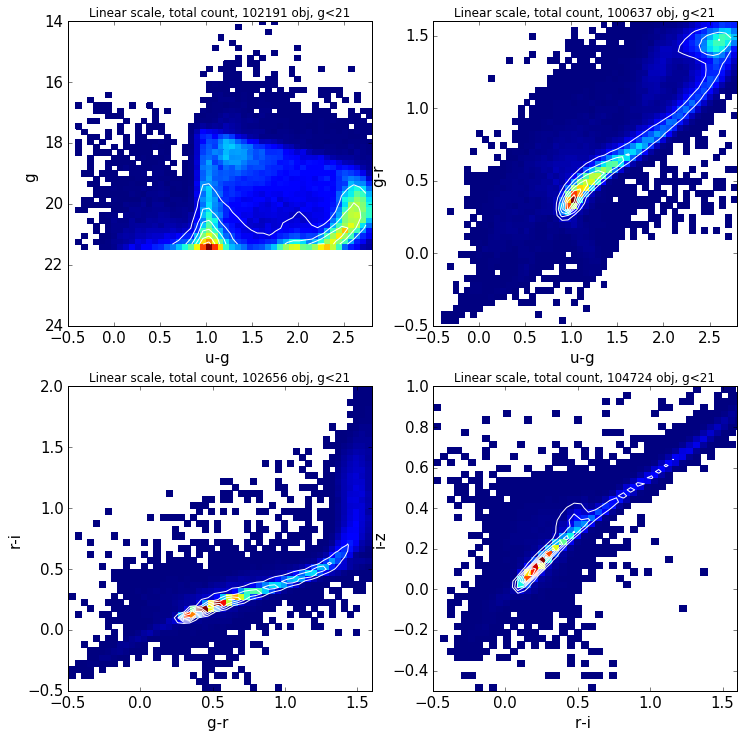

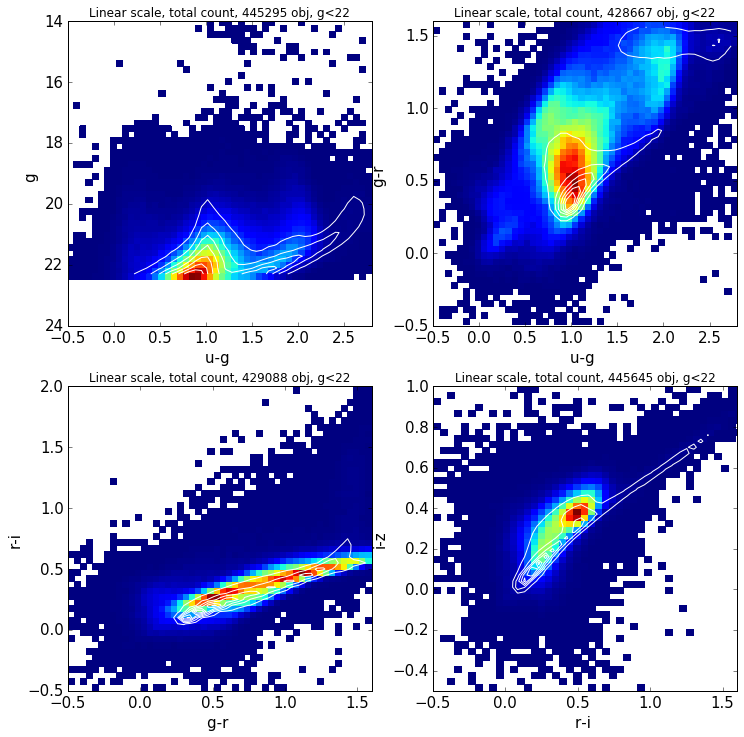

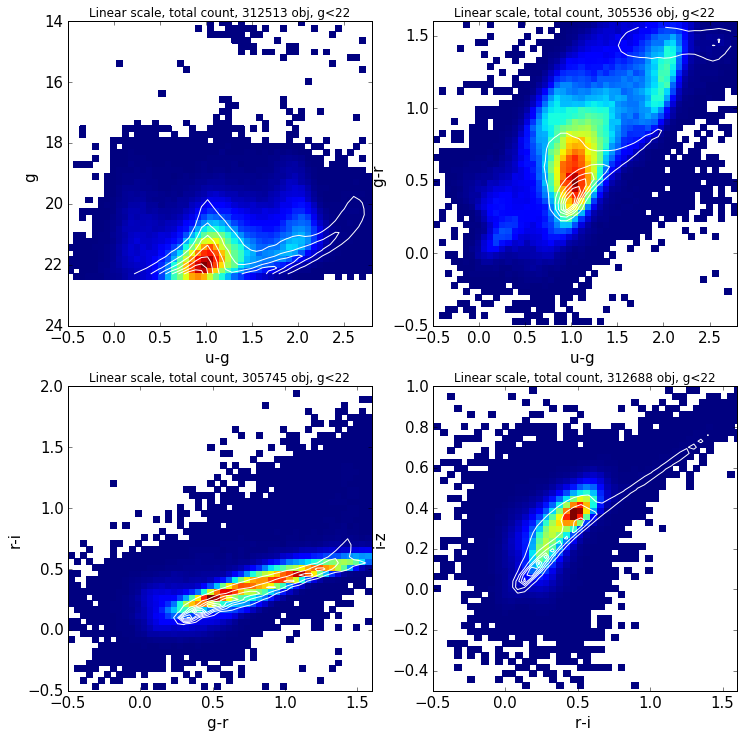

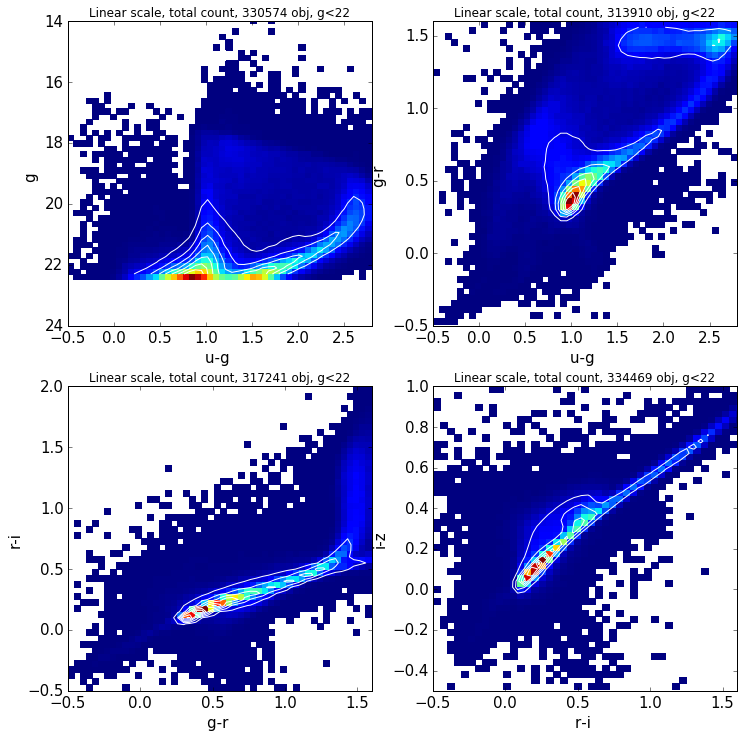

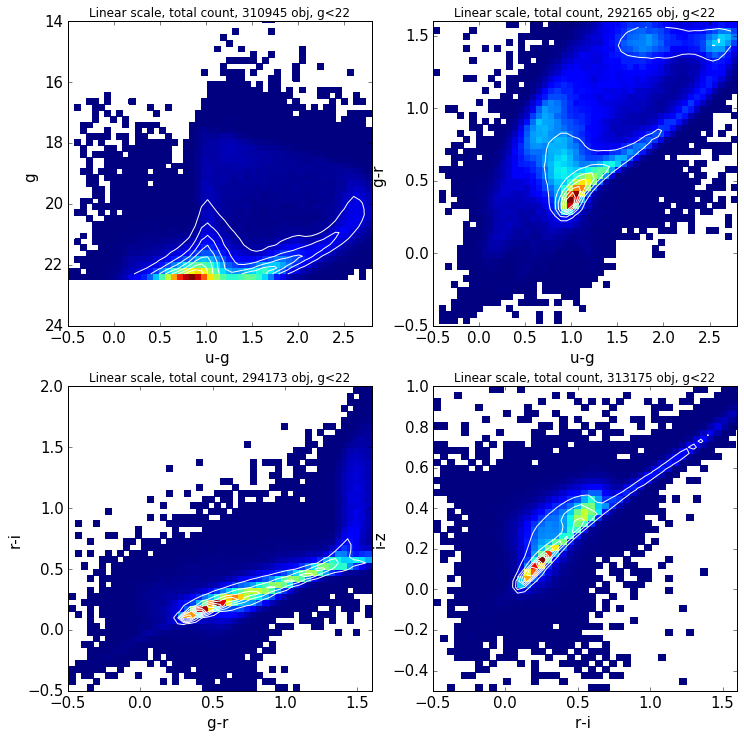

In [181]:
%matplotlib inline
u = data['upsfMean_corr'].data.data
g = data['gpsfMean_corr'].data.data
r = data['rpsfMean_corr'].data.data
i = data['ipsfMean_corr'].data.data
z = data['zpsfMean_corr'].data.data

ug = u-g
gr = g-r
ri = r-i
iz = i-z

# limits below based on Sesar 2007 Fig.4
# these are applied to both the contours of the full data, 
# as well as the variability subsample 

gmax_ = [20.5,21.5, 22.5]
sample_ = [1,2] 
chi_boundary_ = [1.5,2]

for gmax, sample, chi_boundary in product(gmax_, sample_,chi_ ):

    mask_g = g < gmax
    mask_ug = ((ug)<2.8) & ((ug)>-0.5)
    mask_gr = ((gr)<1.6) & ((gr)>-0.5)
    mask_ri = ((ri)<2.0) & ((ri)>-0.5)
    mask_iz = ((iz)<1.0) & ((iz)>-0.5)


    # these are variability selection criteria for the colormap

    if sample == 1 : 
        mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data > chi_boundary)
    if sample == 2 :
        mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data < chi_boundary)

    # parameters for the contours .... 
    contourColor = 'white'
    nlevels = 7

    # initialize the plots, set limits  
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    ax = np.ravel(axs)
    ax[0].invert_yaxis()
    ax[0].set_xlim(-0.5,2.8)
    ax[0].set_ylim(24,14)

    ax[1].set_xlim(-0.5,2.8)
    ax[1].set_ylim(-0.5,1.6)

    ax[2].set_xlim(-0.5, 1.6)
    ax[2].set_ylim(-0.5, 2.0)

    ax[3].set_xlim(-0.5,1.6)
    ax[3].set_ylim(-0.5, 1.0)

    ###########################
    # TOP_LEFT  : g vs u-g  
    ###########################

    # 1) plot contours of the full sample 

    mask_total = mask_g  & mask_ug
    nObj = len(g[mask_total])
    stats = binned_statistic_2d(x=ug[mask_total], y=g[mask_total], 
                                values=ug[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    contours = ax[0].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, nlevels, colors=contourColor)

    # 2) Plot 2D histogram of the chosen variable sample 

    mask_total = mask_g & mask_ug & mask_sample
    nObj = len(g[mask_total])
    stats = binned_statistic_2d(x=ug[mask_total], y=g[mask_total], 
                                values=ug[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax[0].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')


    # 3) set labels,  etc.  
    ax[0].set_xlabel('u-g ', fontsize=15)
    ax[0].set_ylabel('g ', fontsize=15)
    ax[0].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
    ax[0].tick_params(axis='both', which='major', labelsize=15) 


    #colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
    #colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

    ###########################
    # TOP_RIGHT  : u-g vs g-r
    ###########################


    # 1) plot contours of the full sample 

    mask_total = mask_g & mask_gr  & mask_ug
    nObj = len(gr[mask_total])
    stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                                values=ug[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    contours = ax[1].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, nlevels, colors=contourColor)

    # 2) Plot 2D histogram of the chosen variable sample 

    mask_total = mask_g & mask_gr  & mask_ug & mask_sample
    nObj = len(gr[mask_total])
    stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                                values=ug[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

    image = ax[1].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')


    # 3) set labels,  etc.  

    ax[1].set_xlabel('u-g ', fontsize=15)
    ax[1].set_ylabel('g-r ', fontsize=15)
    ax[1].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
    ax[1].tick_params(axis='both', which='major', labelsize=15) 
    #ax[0].invert_yaxis()
    #colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
    #colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')



    ###########################
    # BOTTOM_LEFT :  g-r vs r-i
    ###########################


    # 1) plot contours of the full sample 

    mask_total = mask_g & mask_gr  & mask_ri
    nObj = len(gr[mask_total])
    stats = binned_statistic_2d(x=gr[mask_total], y=ri[mask_total], 
                                values=gr[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    contours = ax[2].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, nlevels, colors=contourColor)

    # 2) Plot 2D histogram of the chosen variable sample 

    mask_total = mask_g & mask_gr  & mask_ri & mask_sample
    nObj = len(gr[mask_total])
    stats = binned_statistic_2d(x=gr[mask_total], y=ri[mask_total], 
                                values=gr[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax[2].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')


    # 3) set labels,  etc.  
    ax[2].set_xlabel('g-r ', fontsize=15)
    ax[2].set_ylabel('r-i', fontsize=15)
    ax[2].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
    ax[2].tick_params(axis='both', which='major', labelsize=15) 
    #ax[0].invert_yaxis()
    #colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
    #colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')


    ###########################
    # BOTTOM_RIGHT :   r-i vs i-z
    ###########################


    # 1) plot contours of the full sample 
    j = 3
    mask_total = mask_g & mask_iz  & mask_ri
    nObj = len(ri[mask_total])
    stats = binned_statistic_2d(x=ri[mask_total], y=iz[mask_total], 
                                values=ri[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    contours = ax[j].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, nlevels, colors=contourColor)

    # 2) Plot 2D histogram of the chosen variable sample 
    mask_total = mask_g & mask_iz  & mask_ri & mask_sample
    nObj = len(ri[mask_total])
    stats = binned_statistic_2d(x=ri[mask_total], y=iz[mask_total], 
                                values=ri[mask_total], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

    image = ax[j].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')


    # 3) set labels,  etc.  
    ax[j].set_xlabel('r-i ', fontsize=15)
    ax[j].set_ylabel('i-z', fontsize=15)
    ax[j].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
    ax[j].tick_params(axis='both', which='major', labelsize=15) 
    #ax[0].invert_yaxis()
    #colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
    #colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')




    fname = outDir+'Fig4_test_sample'+str(sample)+'_chi_bound-'+str(chi_boundary)+'_gmax-'+str(gmax)+'.png'
    plt.savefig(fname,bbox_inches='tight')
    print('Saved as %s '%fname)







### Fig.4 for the bridge region : contour the full distr, color the selection

Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-16/Fig4_bridge_sample1_chi_bound-2_gmax-21.5.png 


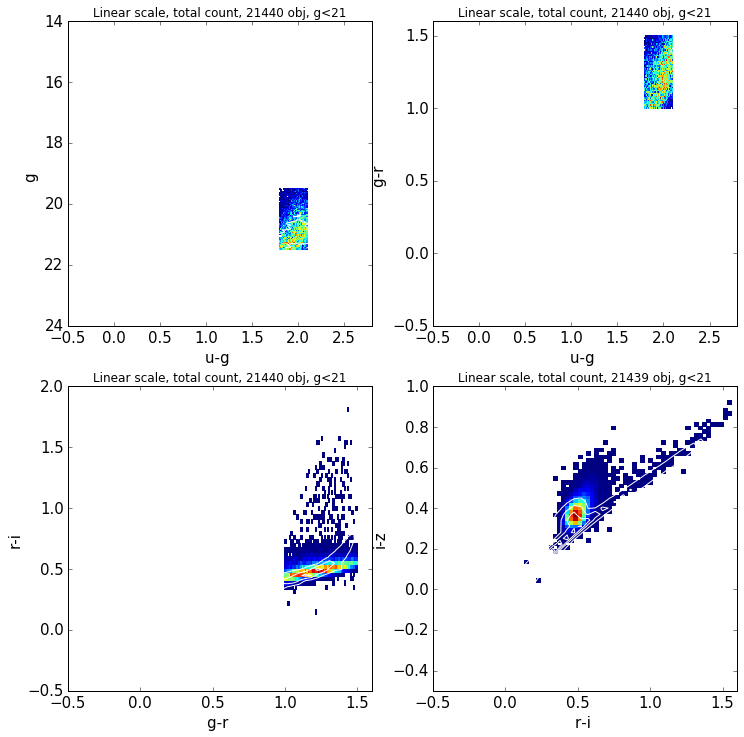

In [240]:
%matplotlib inline
u = data['upsfMean_corr'].data.data
g = data['gpsfMean_corr'].data.data
r = data['rpsfMean_corr'].data.data
i = data['ipsfMean_corr'].data.data
z = data['zpsfMean_corr'].data.data

ug = u-g
gr = g-r
ri = r-i
iz = i-z

# limits below based on Sesar 2007 Fig.4
gmin = 19.5
gmax = 21.5
mask_g = (gmin < g) & (g < gmax)
mask_ug = ((ug)<2.8) & ((ug)>-0.5)
mask_gr = ((gr)<1.6) & ((gr)>-0.5)
mask_ri = ((ri)<2.0) & ((ri)>-0.5)
mask_iz = ((iz)<1.0) & ((iz)>-0.5)


chi_boundary = 2 
mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data > chi_boundary)
mask_ug_gr = (1.8 < ug ) & (ug < 2.1) & (1.0 < gr) & ( gr < 1.5)

mask_bridge = mask_sample & mask_ug_gr
# use some variability measure...


fig, axs = plt.subplots(2,2, figsize=(12,12))
ax = np.ravel(axs)
ax[0].invert_yaxis()
ax[0].set_xlim(-0.5,2.8)
ax[0].set_ylim(24,14)

ax[1].set_xlim(-0.5,2.8)
ax[1].set_ylim(-0.5,1.6)

ax[2].set_xlim(-0.5, 1.6)
ax[2].set_ylim(-0.5, 2.0)

ax[3].set_xlim(-0.5,1.6)
ax[3].set_ylim(-0.5, 1.0)

# parameters for the contours .... 
contourColor = 'white'
nlevels = 7


###########################
# TOP_LEFT  : g vs u-g  
###########################

# 1) plot contours of the full sample 

mask_total = mask_g  & mask_ug
nObj = len(g[mask_total])
stats = binned_statistic_2d(x=ug[mask_total], y=g[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
contours = ax[0].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, nlevels, colors=contourColor)

# 2) Plot 2D histogram of the chosen variable sample in the bridge  

mask_total = mask_g & mask_ug &  mask_bridge
nObj = len(g[mask_total])
stats = binned_statistic_2d(x=ug[mask_total], y=g[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
image = ax[0].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')


# 3) set labels,  etc.  
ax[0].set_xlabel('u-g ', fontsize=15)
ax[0].set_ylabel('g ', fontsize=15)
ax[0].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
ax[0].tick_params(axis='both', which='major', labelsize=15) 


#colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

###########################
# TOP_RIGHT  : u-g vs g-r
###########################


# 1) plot contours of the full sample 

mask_total = mask_g & mask_gr  & mask_ug
nObj = len(gr[mask_total])
stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
contours = ax[1].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, nlevels, colors=contourColor)

# 2) Plot 2D histogram of the chosen variable sample 

mask_total = mask_g & mask_gr  & mask_ug &  mask_bridge
nObj = len(gr[mask_total])
stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

image = ax[1].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')


# 3) set labels,  etc.  

ax[1].set_xlabel('u-g ', fontsize=15)
ax[1].set_ylabel('g-r ', fontsize=15)
ax[1].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
ax[1].tick_params(axis='both', which='major', labelsize=15) 
#ax[0].invert_yaxis()
#colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')



###########################
# BOTTOM_LEFT :  g-r vs r-i
###########################


# 1) plot contours of the full sample 

mask_total = mask_g & mask_gr  & mask_ri
nObj = len(gr[mask_total])
stats = binned_statistic_2d(x=gr[mask_total], y=ri[mask_total], 
                            values=gr[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
contours = ax[2].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, nlevels, colors=contourColor)

# 2) Plot 2D histogram of the chosen variable sample 

mask_total = mask_g & mask_gr  & mask_ri &  mask_bridge
nObj = len(gr[mask_total])
stats = binned_statistic_2d(x=gr[mask_total], y=ri[mask_total], 
                            values=gr[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
image = ax[2].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')


# 3) set labels,  etc.  
ax[2].set_xlabel('g-r ', fontsize=15)
ax[2].set_ylabel('r-i', fontsize=15)
ax[2].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
ax[2].tick_params(axis='both', which='major', labelsize=15) 
#ax[0].invert_yaxis()
#colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')


###########################
# BOTTOM_RIGHT :   r-i vs i-z
###########################


# 1) plot contours of the full sample 
j = 3
mask_total = mask_g & mask_iz  & mask_ri
nObj = len(ri[mask_total])
stats = binned_statistic_2d(x=ri[mask_total], y=iz[mask_total], 
                            values=ri[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
contours = ax[j].contour(x_edges[:-1], y_edges[:-1], z_rot_flip, nlevels, colors=contourColor)

# 2) Plot 2D histogram of the chosen variable sample 
mask_total = mask_g & mask_iz  & mask_ri & mask_bridge
nObj = len(ri[mask_total])
stats = binned_statistic_2d(x=ri[mask_total], y=iz[mask_total], 
                            values=ri[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

image = ax[j].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')


# 3) set labels,  etc.  
ax[j].set_xlabel('r-i ', fontsize=15)
ax[j].set_ylabel('i-z', fontsize=15)
ax[j].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
ax[j].tick_params(axis='both', which='major', labelsize=15) 
#ax[0].invert_yaxis()
#colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')




fname = outDir+'Fig4_bridge_sample'+str(sample)+'_chi_bound-'+str(chi_boundary)+'_gmax-'+str(gmax)+'.png'
plt.savefig(fname,bbox_inches='tight')
print('Saved as %s '%fname)

313

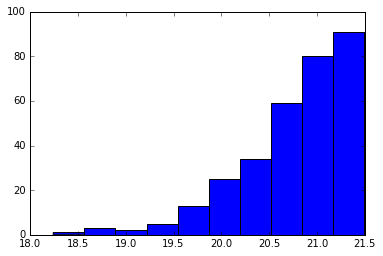

In [257]:
mask_g = (g < gmax)
chi_boundary = 2 
mask_sample = (data['gchi2DOF'].data.data > chi_boundary) * (data['gchi2R'].data.data > chi_boundary)
mask_ug_gr = (1.8 < ug ) & (ug < 2.1) & (1.0 < gr) & ( gr < 1.5)
mask_ext = data['extendedness'].data.data == 0
mask_bridge = mask_g & mask_sample & mask_ug_gr & mask_ext
plt.hist(g[mask_bridge])
np.sum(mask_bridge)

(array([   313.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  21906.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

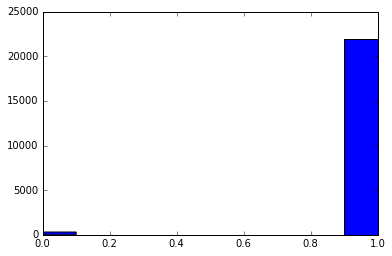

In [250]:
plt.hist(data['extendedness'].data.data[mask_bridge])

In [243]:
data.colnames

['col0',
 'uN',
 'uchi2DOF',
 'uchi2R',
 'umuFull',
 'upsfMeanErr',
 'upsfMean_corr',
 'gN',
 'gchi2DOF',
 'gchi2R',
 'gmuFull',
 'gpsfMeanErr',
 'gpsfMean_corr',
 'rN',
 'rchi2DOF',
 'rchi2R',
 'rmuFull',
 'rpsfMeanErr',
 'rpsfMean_corr',
 'iN',
 'ichi2DOF',
 'ichi2R',
 'imuFull',
 'ipsfMeanErr',
 'ipsfMean_corr',
 'zN',
 'zchi2DOF',
 'zchi2R',
 'zmuFull',
 'zpsfMeanErr',
 'zpsfMean_corr',
 'ebv',
 'objectId',
 'patch',
 'deepSourceId',
 'extendedness',
 'ra',
 'decl']

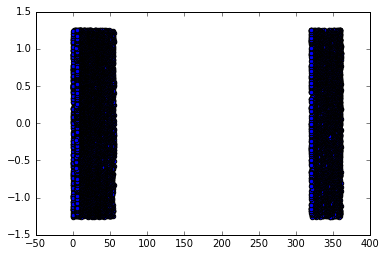

In [252]:
plt.scatter(data['ra'].data.data[mask_bridge],data['decl'].data.data[mask_bridge])

## Plot    $\chi^{2}_{DOF}$   vs   $\chi^{2}_{R}$ for {ugri} filters

Note : here initially there is no distinction for extendedness, i.e. all objects are included on these plots, then I make the same plots (chi2-chi2, per band), but selecting by extendedness (separate plots for stars and for quasars)

In [283]:
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_chi2_space',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)


We will save this figure in  /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_chi2_space/2017-03-20/



In u filter, 
There are 7961043 objects total
Of these: 7961043 are not NaNs
          7939941 have chi2dof<10 and chi2R < 10 
          603399 have psfMean_corr < 23 
These 3 criteria are simultaneously met by 587442 objects, 
from which 361786 satisfy chi2dof > 1+3 sqrt(2/N) 

In g filter, 
There are 7961043 objects total
Of these: 7961043 are not NaNs
          7653553 have chi2dof<10 and chi2R < 10 
          1720496 have psfMean_corr < 23 
These 3 criteria are simultaneously met by 1501834 objects, 
from which 977252 satisfy chi2dof > 1+3 sqrt(2/N) 

In r filter, 
There are 7961043 objects total
Of these: 7961043 are not NaNs
          7487647 have chi2dof<10 and chi2R < 10 
          3680614 have psfMean_corr < 23 
These 3 criteria are simultaneously met by 3273065 objects, 
from which 1861814 satisfy chi2dof > 1+3 sqrt(2/N) 

In i filter, 
There are 7961043 objects total
Of these: 7961043 are not NaNs
          7458026 have chi2dof<10 and chi2R < 10 
          5911263 have psfM

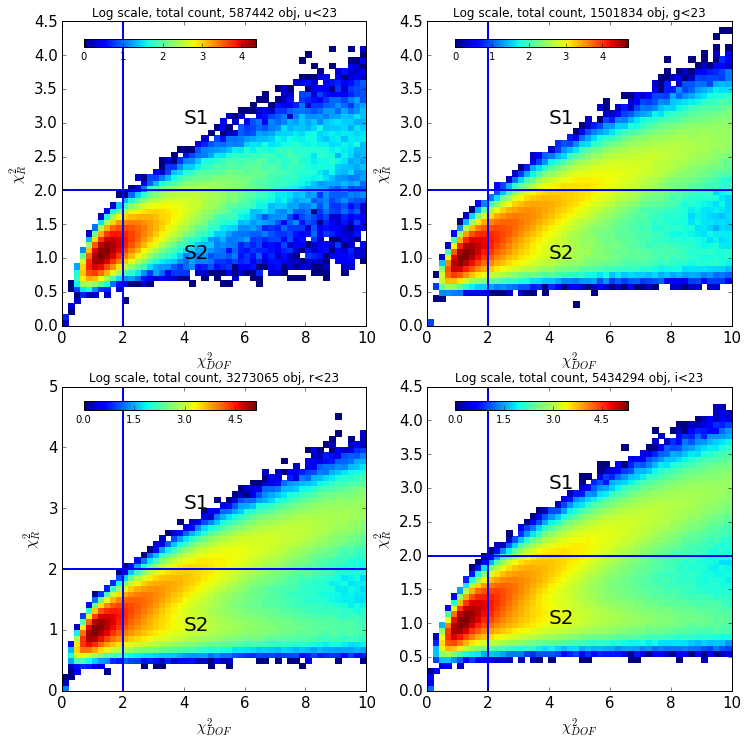

In [312]:
filters = 'ugri'

fig, axs = plt.subplots(2,2, figsize=(12,12))
ax = np.ravel(axs)

colorbar_axs  = {}
colorbar_axs[0] =   fig.add_axes([0.15, 0.87, 0.2, 0.01]) 
colorbar_axs[1] =   fig.add_axes([0.58, 0.87, 0.2, 0.01])
colorbar_axs[2] =   fig.add_axes([0.15, 0.45, 0.2, 0.01])
colorbar_axs[3] =   fig.add_axes([0.58, 0.45, 0.2, 0.01])


gmax = 23

for j in range(len(filters)):
#j=1
    f = filters[j]
    stdev = np.sqrt(2.0 / data[f+'N'])
    chi2dof = data[f+'chi2DOF'].data.data
    chi2R = data[f+'chi2R'].data.data
    m1 = (~np.isnan(chi2dof))&(~np.isnan(chi2R))
    m2 = (chi2dof < 10) & (chi2R < 10 )
    m3 = data[f+'psfMean_corr'].data.data < gmax 

    m = m1 & m2 &m3
    mask_chi2dof = chi2dof[m] > 1 +  3 * stdev[m]
    print('\nIn %s filter, '%f )
    print('There are %d objects total'%len(chi2dof))
    print('Of these: %d are not NaNs'%np.sum(m1))
    print('          %d have chi2dof<10 and chi2R < 10 '% np.sum(m2))
    print('          %d have psfMean_corr < %d '% (np.sum(m3), gmax))
    print('These 3 criteria are simultaneously met by %d objects, '%np.sum(m))
    print('from which %d satisfy chi2dof > 1+3 sqrt(2/N) '%np.sum(mask_chi2dof))

    nObj = len(chi2dof[m])
    stats = binned_statistic_2d(x=chi2dof[m], y=chi2R[m], 
                            values=chi2dof[m], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

    # Plot 2D histogram using pcolor
    image = ax[j].pcolormesh(x_edges,y_edges, np.log10(z_masked), cmap='jet')
    ax[j].set_xlabel(r'$\chi^{2}_{DOF}$', fontsize=15)
    ax[j].set_ylabel(r'$\chi^{2}_{R}$', fontsize=15)
    ax[j].set_title('Log scale, total count, %d obj, %s<%d'%(nObj,f,gmax))
    ax[j].tick_params(axis='both', which='major', labelsize=15) 

    thickness = 2 
    ax[j].axvline(2, lw=thickness)
    ax[j].axhline(2, lw=thickness)
    ax[j].text(4,1,'S2', fontsize=20)
    ax[j].text(4,3,'S1', fontsize=20)
    colorbar = fig.colorbar(image,  cax=colorbar_axs[j], orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()

plt.savefig(outDir+'chi2_ugri_lt-'+str(gmax)+'.png')

## RA vs DEC coverage... 

First I plot the ra , dec coverage of the full NCSA-IN2P3 combined dataset (all lightcurves that have been processed...)

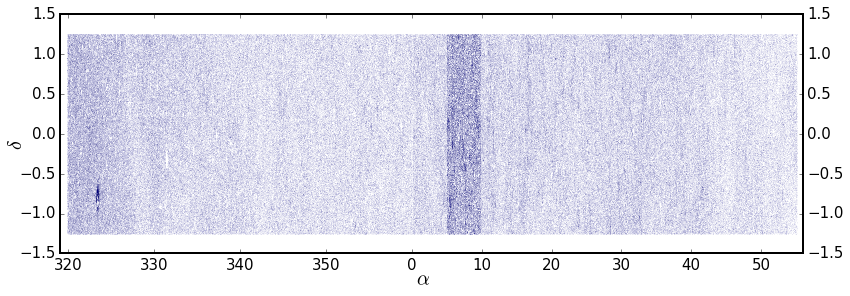

In [151]:
m1 = data['gpsfMean_corr'] < gmax 

fig = plt.figure(figsize=(12,4 ))

ax = dict()
number_of_rows  = 1 
number_of_columns = 19  # because I have 320:360, and then 0:55 degrees, which in total spans 
# 40 on the left,  and 55 on the right , 
# 40:55 = 8:11,  8+11 = 19 will give the right aspect ratio 
gs = gridspec.GridSpec(number_of_rows,  number_of_columns)
#ax = plt.subplot(gs[rowspan, colspan])
ax[0] = plt.subplot(gs[:, :9])  # span all rows but the last one (bottom), and first 5 col
ax[1] = plt.subplot(gs[:, 9:])  # span all rows but the last one (bottom), and last 5 cols

fig.subplots_adjust(wspace=0)

dotsize = 0.02

# left part 
m2 = data['ra'] > 60
m = m1 & m2 
ax[0].scatter(data['ra'][m], data['decl'][m], lw=0, s=dotsize)
ax[0].set_xlim(319, 360)
ax[0].yaxis.set_ticks_position('left')
xticks = ax[0].get_xticks()
ax[0].set_xticks(xticks[:-1][1::2])

# right part 
m2 = data['ra'] < 60
m = m1 & m2 
ax[1].scatter(data['ra'][m], data['decl'][m], lw=0, s=dotsize)
ax[1].set_xlim(0,56)

ax[1].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].yaxis.set_ticks_position('right')

# make labels through figure rather than axs... 
Xlabel = r'$\alpha$'
Ylabel = r'$\delta$'
fig.text(0.5, 0.03, Xlabel, ha='center', va='center', fontsize=20)
fig.text(0.03, 0.5, Ylabel, ha='center', va='center', rotation='vertical', fontsize=20)

fig.subplots_adjust(wspace=0, hspace=0.36, left=0.08, right=0.94, bottom=0.12, top=0.95)
plt.savefig('../data_products/Fig_ra_dec/Fig_radec_test_g_lt'+str(gmax)+'.png')

Now, we see that there is a region with some structure - zoom in, and see what it is. 

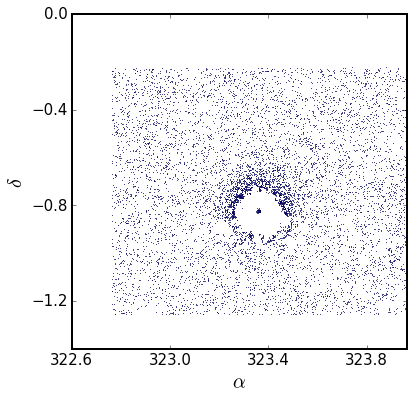

In [179]:
# zoom -in on the region with some structure ....
gmax = 22
m2_ra = 323.36258
m2_dec  = -0.82325

m1 = data['gpsfMean_corr'] < gmax

margin = 0.6 # degree 
m2 = ( m2_ra - margin < data['ra'] ) & ( data['ra'] < m2_ra + margin)
m3 = (data['decl'] < m2_dec + margin) & (data['decl'] > m2_dec-margin)
m = m1 & m2 & m3 

fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(data['ra'][m], data['decl'][m], lw=0, s=0.6)
ax.set_xlim(m2_ra - margin,  m2_ra + margin)

xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])

yticks = ax.get_yticks()
ax.set_yticks(yticks[2::2])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')

plt.savefig('../data_products/Fig_ra_dec/Fig_radec_zoom_M2_cluster.png')

In [402]:
data[:10]['site'].data.data == 'NCSA'

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [529]:
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_overlap_compare',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)

We will save this figure in  /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_overlap_compare/2017-03-21/


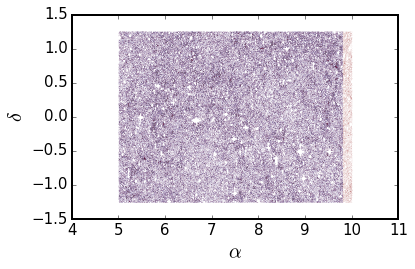

In [821]:
m1 = (5 < data['ra'].data.data) & (data['ra'].data.data < 10 )


fig,ax = plt.subplots(1,1, figsize=(6,4))

m2 = data['site'].data.data == 'NCSA'
m = m1 * m2 
ax.scatter(data['ra'][m], data['decl'][m], lw=0, s=0.01, c='blue')

m2 = data['site'].data.data == 'IN2P3'
m = m1 * m2 
ax.scatter(data['ra'][m], data['decl'][m], lw=0, s=0.01, c='red')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')
plt.tight_layout()
plt.savefig(outDir + 'NCSA_IN2P3_overlap_5-10_deg.png')


### RA vs Dec : compare NCSA-IN2P3 overlap 

Select objects that have   5 < ra < 10  from NCSA, and from IN2P3. Treat them as two separate catalogs, and match positionally 

In [959]:
# Try to match the objects by ra,dec :  match the catalog to self, eg. with 2 arcsec matching radius... 
from astropy.coordinates import SkyCoord
from astropy import units as u


# the NCSA catalog  , match to IN2P3  

# select the right ra ...
mask_ra = (5 < data['ra'].data.data) * (data['ra'].data.data < 9.5 )


# select the left side ... 
mask_site =  data['site'].data.data == 'NCSA'
# combine the masks 
m = mask_ra * mask_site 

# extract one part of data : only NCSA ones
overlap_NCSA = data[m]

# select the right side ... 
mask_site =  data['site'].data.data == 'IN2P3'
# combine the masks 
m = mask_ra * mask_site 
overlap_IN2P3 = data[m]

# make a SkyCoord object for matching ... 
cat_NCSA = SkyCoord(ra=overlap_NCSA['ra']*u.degree, dec=overlap_NCSA['decl']*u.degree)
cat_IN2P3 = SkyCoord(ra=overlap_IN2P3['ra']*u.degree, dec=overlap_IN2P3['decl']*u.degree)

# Perform matching : 
# nthneighbor = 1 for matching two separate catalogs, 
# nthneighbor = 2 for matching catalog to self for duplicates 
# so that each point will find a closest match apart from self
 
idx, sep2d, dist3d = cat_NCSA.match_to_catalog_sky(cat_IN2P3,nthneighbor=1)  
match_angle_arcsec = sep2d.value * 3600  # sep2d is in degrees 

#  indices for objects matching to cat_NCSA are  into cat_IN2P3 
#  so we select matching rows from IN2P3 : 
overlap_IN2P3_matched = overlap_IN2P3[idx]

# add a column with match angle ...
match_angle = Column(name='match_angle_arcsec',data= match_angle_arcsec)
overlap_IN2P3_matched.add_column(match_angle)

Given that we are done with matching, stack the tables horizontally.... 

In [960]:
# Stack the two tables horizontally, since they are already matched...
overlap_matched = hstack([overlap_NCSA, overlap_IN2P3_matched])

# the NCSA data has _1,  and  IN2P3 : _2  suffix 

And now for the entire table, focus on the matching angle : how many sources had a match within a certain radius ? I'm looking for some kind of saturation ... 

In [966]:
np.ravel(overlap_matched.colnames)

array(['col0_1', 'uN_1', 'uchi2DOF_1', 'uchi2R_1', 'umuFull_1',
       'upsfMeanErr_1', 'upsfMean_corr_1', 'gN_1', 'gchi2DOF_1',
       'gchi2R_1', 'gmuFull_1', 'gpsfMeanErr_1', 'gpsfMean_corr_1', 'rN_1',
       'rchi2DOF_1', 'rchi2R_1', 'rmuFull_1', 'rpsfMeanErr_1',
       'rpsfMean_corr_1', 'iN_1', 'ichi2DOF_1', 'ichi2R_1', 'imuFull_1',
       'ipsfMeanErr_1', 'ipsfMean_corr_1', 'zN_1', 'zchi2DOF_1',
       'zchi2R_1', 'zmuFull_1', 'zpsfMeanErr_1', 'zpsfMean_corr_1',
       'ebv_1', 'objectId_1', 'patch_1', 'deepSourceId_1',
       'extendedness_1', 'ra_1', 'decl_1', 'site_1', 'col0_2', 'uN_2',
       'uchi2DOF_2', 'uchi2R_2', 'umuFull_2', 'upsfMeanErr_2',
       'upsfMean_corr_2', 'gN_2', 'gchi2DOF_2', 'gchi2R_2', 'gmuFull_2',
       'gpsfMeanErr_2', 'gpsfMean_corr_2', 'rN_2', 'rchi2DOF_2',
       'rchi2R_2', 'rmuFull_2', 'rpsfMeanErr_2', 'rpsfMean_corr_2', 'iN_2',
       'ichi2DOF_2', 'ichi2R_2', 'imuFull_2', 'ipsfMeanErr_2',
       'ipsfMean_corr_2', 'zN_2', 'zchi2DOF_2', 'zchi2R_

In [975]:
# select only those that have the same objectIds... 
indices1 = np.where((overlap_matched['objectId_1'] - overlap_matched['objectId_2']) == 0 )[0]
print(len(indices1))

indices = np.where((overlap_matched['deepSourceId_1'] - overlap_matched['deepSourceId_2']) == 0 )[0]
print(len(indices2))

print(len(overlap_matched))

267802
267802
436788


We see that at least exactly the same number of objects share objectId and deepSourceId ... Roughly a half! 

In [985]:
mask = (overlap_matched['deepSourceId_1'].data.data - overlap_matched['deepSourceId_2'].data.data) == 0 

In [992]:
# What number of  objects from NCSA have IN2P3 counterparts in the overlap within  max_separation  radius  ?
max_separation = np.logspace(-6, 1, 1000)
N_within_sep = np.zeros_like(max_separation)
for i in range(len(max_separation)): 
    max_sep = max_separation[i] 
    m = overlap_matched['match_angle_arcsec'][mask] < max_sep
    #print('there are %d  NCSA objects that have IN2P3 counterpart within %.4f arcsec'%(np.sum(m), max_sep))
    N_within_sep[i] = np.sum(m)

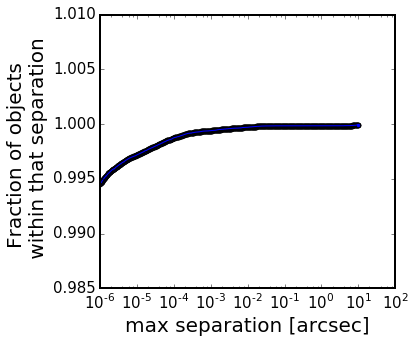

In [993]:
# Plot showing a fraction of objects that have a match within   a certain separation ... 
N_tot = len(indices)

fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.scatter(max_separation[1:], N_within_sep[1:]/N_tot)
ax.semilogx(max_separation[1:], N_within_sep[1:]/N_tot)
ax.set_xlabel('max separation [arcsec]')
ax.set_ylabel('Fraction of objects \n within that separation')
plt.tight_layout()
plt.savefig(outDir+'NCSA_IN2P3_fraction_of_objects_within_r_same_deepSourceId.png')

Now I use this parameter : separation to the nearest match (matching_radius), to find out if there is any spatial correlation with the proximity of NCSA vs IN2P3 match .... 

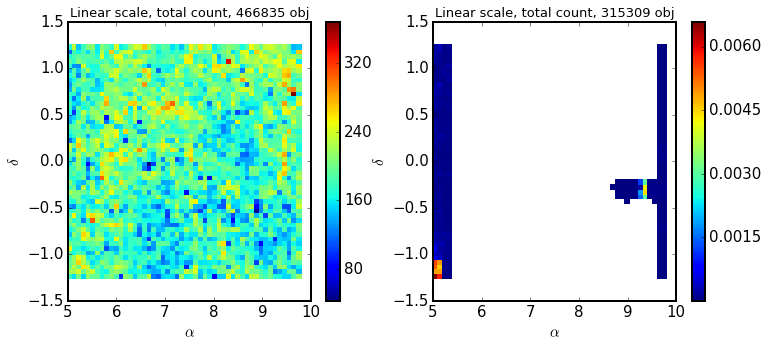

In [908]:
# plot ra,dec, and color by count ...
m = NCSA_IN2P3_matched['ra_1'].data.data < 10 

nObj = np.sum(m)


fig,ax = plt.subplots(1,2, figsize=(12,5))


# Left panel 
stats = binned_statistic_2d(x=overlap_matched[m]['ra_1'], y=overlap_matched[m]['decl_1'], 
                        values=overlap_matched[m]['ra_1'], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

j= 0 
image = ax[j].pcolormesh(x_edges,y_edges, z_masked, cmap='jet')
ax[j].set_xlabel(r'$\alpha$', fontsize=15)
ax[j].set_ylabel(r'$\delta$', fontsize=15)
ax[j].set_title('Linear scale, total count, %d obj'%nObj)
ax[j].tick_params(axis='both', which='major', labelsize=15) 

colorbar = fig.colorbar(image,  ax=ax[j], orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=5)
colorbar.locator = tick_locator
colorbar.update_ticks()

# plot ra,dec, and color by separation to the nearest partner....
m1 = NCSA_IN2P3_matched['ra_1'].data.data < 10 
m2  = NCSA_IN2P3_matched['match_angle_arcsec'].data.data < 2

m = m1 * m2 
nObj = np.sum(m)

stats = binned_statistic_2d(x=overlap_matched[m]['ra_1'], y=overlap_matched[m]['decl_1'], 
                        values=overlap_matched[m]['match_angle_arcsec'], statistic='median', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor

j= 1
image = ax[j].pcolormesh(x_edges,y_edges, z_masked, cmap='jet')
ax[j].set_xlabel(r'$\alpha$', fontsize=15)
ax[j].set_ylabel(r'$\delta$', fontsize=15)
ax[j].set_title('Linear scale, total count, %d obj'%nObj)
ax[j].tick_params(axis='both', which='major', labelsize=15) 


colorbar = fig.colorbar(image,  ax=ax[j], orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=5)
colorbar.locator = tick_locator
colorbar.update_ticks()


There isn't much structure : left panel is colored by object count,  and right : by separation. 

Plot all objects that have a match within 1 arcsec, color by the distance to the nearest neighbor (matching radius)  : 

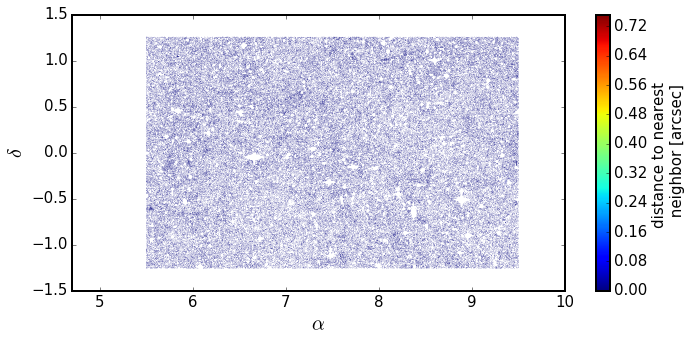

In [592]:
m1 = (5.5 < NCSA_IN2P3_matched['ra_1'].data.data ) * (NCSA_IN2P3_matched['ra_1'].data.data < 9.5) 
m2 = (-1.5 < NCSA_IN2P3_matched['decl_1'].data.data ) * (NCSA_IN2P3_matched['decl_1'].data.data < 1.5) 
m3  = NCSA_IN2P3_matched['match_angle_arcsec'].data.data < 1
m = m1 * m2 * m3

z = NCSA_IN2P3_matched['match_angle_arcsec'].data.data[m]

fig,ax = plt.subplots(1,1, figsize=(10,5))
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')
ax.set_xlim(4.7, 10)
image = ax.scatter(NCSA_IN2P3_matched['ra_1'].data.data[m], NCSA_IN2P3_matched['decl_1'].data.data[m], 
                   s=0.1, lw=0, c = z )
cb = plt.colorbar(image)
cb.set_label('distance to nearest \n neighbor [arcsec]', fontsize=15)
plt.tight_layout()
plt.savefig(outDir + 'NCSA_distance_to_nearest_IN2P3_neighbor_1.png')

Now given that there is no spatial structure, compare objectIds, and deepSourceIds :  are they the same for all matches ? Are they the same for at least those objects that have a match within 1 arcsec ? 

In [910]:
# With separations less than 1 arcsec,  287046 objects have also exactly the same objectId... 
m1 = NCSA_IN2P3_matched['match_angle_arcsec'].data.data <  1 
len(np.where((NCSA_IN2P3_matched[m1]['objectId_1'] - NCSA_IN2P3_matched[m1]['objectId_2']).data.data == 0 )[0] )

# Yusra said they don't have to be the same, so I would be careful about doing anything with that ... 

287025

In [615]:
# With separations less than 1 arcsec,  287046 objects have also exactly the same deepSourceId... 
m1 = NCSA_IN2P3_matched['match_angle_arcsec'].data.data <  1 
indices = np.where((NCSA_IN2P3_matched[m1]['deepSourceId_1'] - NCSA_IN2P3_matched[m1]['deepSourceId_2']).data.data == 0 )[0]
len(indices)

# Yusra said they don't have to be the same, so I would be careful about doing anything with that ... 

287046

### Check Deep Source files ! 

I go back to the Deep Source files, and check if there are similar trends ... 

In [933]:
# Go back to DeepSource files - those that have DeepSourceIds,  ra, dec.   
# Read them in,  and find out whether exactly the same behavior persists...
# (i.e. that of objects from NCSA vs IN2P3 in the overlap region that are closer than
# 1 arcsec,  also 2/3  of them share identical deepObjectIds....)

dir_info = '../raw_data/repo_fls/'


## 
## Read - in NCSA  
## 

site = 'NCSA'

good_sources = np.load(dir_info+site+'_source_without_bright_parent.npy')
# Add ra, dec info  
#
DS_NCSA = pd.read_csv(dir_info+'DeepSource'+site+'_i_lt235_narrow.csv.gz', compression='gzip', 
                         index_col=0)
# np.ravel(deep_source_radec.columns) = array(['parentDeepSourceId', 'deepCoaddId', 'ra', 'decl', 'psfMag',
#      'psfMagSigma', 'tract', 'patch', 'detect_is_primary'], dtype=object)

# only choose these two columns 
#DS_NCSA_radec = DS_NCSA[['ra','decl']]

# only keep the rows corresponding to objects that 
# do not have a bright parent ..... 
mask_keep = np.in1d(DS_NCSA.index.values, good_sources)
N_good = np.sum(mask_keep)
N_remove = np.sum(~mask_keep)
print('Good points from %s : %d'%(site, N_good))
print('Too bright parent  points:  %d'%N_remove)

DS_NCSA_good = DS_NCSA[mask_keep]

## 
## Read - in IN2P3  
## 

site = 'IN2P3'
good_sources = np.load(dir_info+site+'_source_without_bright_parent.npy')
# Add ra, dec info  
#
DS_IN2P3 = pd.read_csv(dir_info+'DeepSource'+site+'_i_lt235_narrow.csv.gz', compression='gzip', 
                         index_col=0)
# np.ravel(deep_source_radec.columns) = array(['parentDeepSourceId', 'deepCoaddId', 'ra', 'decl', 'psfMag',
#      'psfMagSigma', 'tract', 'patch', 'detect_is_primary'], dtype=object)

# only choose these two columns 
#DS_IN2P3_radec = DS_IN2P3[['ra','decl']]

# only keep the rows corresponding to objects that 
# do not have a bright parent ..... 
mask_keep = np.in1d(DS_IN2P3.index.values, good_sources)
N_good = np.sum(mask_keep)
N_remove = np.sum(~mask_keep)
print('Good points from %s : %d'%(site, N_good))
print('Too bright parent  points:  %d'%N_remove)

DS_IN2P3_good = DS_IN2P3[mask_keep]



Good points from NCSA : 4888430
Too bright parent  points:  585920
Good points from IN2P3 : 4602931
Too bright parent  points:  395970


In [935]:
DS_NCSA

parentDeepSourceId  deepCoaddId          ra      decl  \
deepSourceId                                                                
217773674667705145                  -1   1622540315  319.919107 -0.629259   
217773674667705156                  -1   1622540315  320.001261 -0.628664   
217773674667705160                  -1   1622540315  319.881801 -0.628521   
217773674667705162                  -1   1622540315  320.003983 -0.628222   
217773674667705163                  -1   1622540315  319.911802 -0.628504   
217773674667705165                  -1   1622540315  319.846006 -0.628477   
217773674667705169                  -1   1622540315  319.958190 -0.628117   
217773674667705171                  -1   1622540315  320.005971 -0.628042   
217773674667705177                  -1   1622540315  319.940607 -0.627714   
217773674667705180                  -1   1622540315  319.902490 -0.627296   
217773674667705183                  -1   1622540315  320.022315 -0.627151   
217773674667705188                  -1   1622540315  319.962866 -0.626655   
217773674667705190                  -1   1622540315  319.954245 -0.626188   
217773674667705191                  -1   1622540315  319.855253 -0.626432   
217773674667705192                  -1   1622540315  320.051620 -0.625979   
217773674667705193                  -1   1622540315  320.000223 -0.625916   
217773674667705199                  -1   1622540315  319.933443 -0.625487   
217773674667705203                  -1   1622540315  319.889771 -0.625524   
217773674667705208                  -1   1622540315  319.912139 -0.625273   
217773674667705209                  -1   1622540315  319.880765 -0.625294   
217773674667705214                  -1   1622540315  319.985173 -0.624578   
217773674667705215                  -1   1622540315  319.969874 -0.624617   
217773674667705219                  -1   1622540315  319.930103 -0.624446   
217773674667705222                  -1   1622540315  319.885279 -0.624246   
217773674667705225                  -1   1622540315  319.996441 -0.623914   
217773674667705232                  -1   1622540315  319.845370 -0.623615   
217773674667705239                  -1   1622540315  319.987358 -0.623183   
217773674667705241                  -1   1622540315  319.872099 -0.623207   
217773674667705254                  -1   1622540315  320.040244 -0.622569   
217773674667705260                  -1   1622540315  319.916150 -0.622482   
...                                ...          ...         ...       ...   
3201778262745916      3201778262741681     23855107    9.928749 -1.058413   
3201778262745917      3201778262741681     23855107    9.935396 -1.055940   
3201778262745918      3201778262741681     23855107    9.926499 -1.050953   
3201778262745921      3201778262741681     23855107    9.934747 -1.055659   
3201778262745922      3201778262741681     23855107    9.931379 -1.054678   
3201778262745923      3201778262741681     23855107    9.920985 -1.050051   
3201778262745924      3201778262741681     23855107    9.935508 -1.058249   
3201778262745931      3201778262741681     23855107    9.923608 -1.056944   
3201778262745950      3201778262741681     23855107    9.936843 -1.058122   
3201778262745955      3201778262741686     23855107    9.853789 -1.050423   
3201778262745958      3201778262741687     23855107   10.003955 -1.049321   
3201778262745962      3201778262741698     23855107    9.833735 -1.058676   
3201778262745963      3201778262741698     23855107    9.833722 -1.059410   
3201778262745964      3201778262741698     23855107    9.843258 -1.072745   
3201778262745965      3201778262741698     23855107    9.848825 -1.067207   
3201778262745966      3201778262741698     23855107    9.816624 -1.057053   
3201778262745967      3201778262741698     23855107    9.834030 -1.049351   
3201778262745968      3201778262741698     23855107    9.841933 -1.055698   
3201778262745969      3201778262741698     23855107    9.841515 -1.061018   
3201778262745970

So based on the Deep Source files ,  there is a similar number of objects in total from NCSA and from IN2P3.  But I don't have the same number of lightcurves from these data processing centers ... 

In [998]:
m = data['site'].data.data== 'IN2P3'
max(data['gpsfMean_corr'][m].data.data)

26.533230584872399

In [865]:
# Compare to objects from forced photometry...
N_NCSA = np.sum(data['site'].data.data== 'NCSA')
N_IN2P3 = np.sum(data['site'].data.data== 'IN2P3')
print('Number of objects w/lightcurves NCSA %d '%N_NCSA)
print('Number of objects w/lightcurves IN2P3 %d '%N_IN2P3)

Number of objects w/lightcurves NCSA 4867169 
Number of objects w/lightcurves IN2P3 3093874 


See - I'm missing 1/3 of IN2P3 lightcurves ! Why ??? 

In the meantime, plot the overlap region for NCSA and IN2P3 :

In [921]:
m = (5 < DS_NCSA_good['ra'].values) * (DS_NCSA_good['ra'].values < 10 )
print('NCSA has %d objects with  5 < RA < 10'% np.sum(m))

m = (5 < DS_IN2P3_good['ra'].values) * (DS_IN2P3_good['ra'].values < 10 )
print('IN2P3 has %d objects with  5 < RA < 10'% np.sum(m))

NCSA has 486175 objects with  5 < RA < 10
IN2P3 has 486125 objects with  5 < RA < 10


In [777]:
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (500,-1))


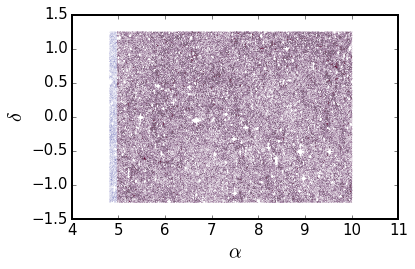

In [922]:
fig,ax = plt.subplots(1,1, figsize=(6,4))

# NCSA 
m1 = (4.8 < DS_NCSA_good['ra'].values) & (DS_NCSA_good['ra'].values < 10 )
ax.scatter(DS_NCSA_good['ra'].values[m1], DS_NCSA_good['decl'].values[m1], lw=0, s=0.01, c='blue')

# IN2P3 
m1 = (4.8 < DS_IN2P3_good['ra'].values) & (DS_IN2P3_good['ra'].values < 10 )
ax.scatter(DS_IN2P3_good['ra'].values[m1], DS_IN2P3_good['decl'].values[m1], lw=0, s=0.01, c='red')


ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')
plt.tight_layout()
plt.savefig(outDir + 'DeepSource_NCSA_IN2P3_overlap.png')



The only weird thing : the RA of NCSA data (blue points) extend here all the way to RA=10 deg.  Why my data only goes up to RA = 9.8 ? 

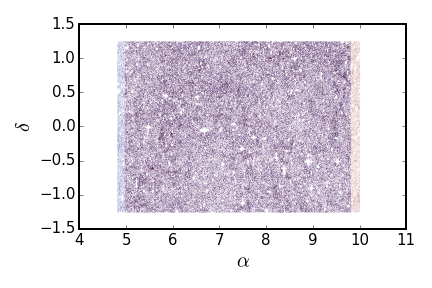

In [779]:
from IPython.display import Image
Image(filename ="../data_products/Fig_overlap_compare/2017-03-21/NCSA_IN2P3_overlap.png" )
#<img src="../data_products/Fig_overlap_compare/2017-03-21/NCSA_IN2P3_overlap.png">

In [781]:
max(DS_NCSA_good['ra'][DS_NCSA_good['ra'] <10])

9.9999892118615037

In [782]:
# which patches does it correspond to ? 
dir_info_files = '../raw_data/repo_fls/'
patch_bounds = pd.read_table(dir_info_files+'coaddBounds.txt', delim_whitespace=True)

In [788]:
m = (5<patch_bounds['minRA'].values)*(patch_bounds['minRA'].values < 10 )
patch_bounds[m]['patchI'].values

array([365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 366,
       366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 367, 367,
       367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 368, 368, 368,
       368, 368, 368, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369,
       369, 369, 369, 369, 369, 369, 369, 369, 370, 370, 370, 370, 370,
       370, 370, 370, 370, 370, 370, 370, 371, 371, 371, 371, 371, 371,
       371, 371, 371, 371, 371, 371, 372, 372, 372, 372, 372, 372, 372,
       372, 372, 372, 372, 372, 373, 373, 373, 373, 373, 373, 373, 373,
       373, 373, 373, 373, 374, 374, 374, 374, 374, 374, 374, 374, 374,
       374, 374, 374, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
       375, 375, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376,
       376, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377,
       378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 379,
       379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 38

Exactly what I would expect : patch 365_387 is definitely present in NCSA_IN2P3_matched

In [937]:
# Calculate separations, plot the cumulative seeparation plot , check the DeepSourceIds.... 

# make a Table from overlapping rows of IN2P3  Deep Source data 
m1 = (5 < DS_NCSA_good['ra'].values) * (DS_NCSA_good['ra'].values < 10 )
DS_NCSA_good_overlap = Table.from_pandas(DS_NCSA_good[m1])

# since DeepSourceId is an index,  need to add a column manually 
indices = Column(name = 'DeepSourceId', data = DS_NCSA_good[m1].index )
DS_NCSA_good_overlap.add_column(indices)


# make a Table from overlapping rows of IN2P3  Deep Source data 
m2 = (5 < DS_IN2P3_good['ra'].values) & (DS_IN2P3_good['ra'].values < 10 )
DS_IN2P3_good_overlap = Table.from_pandas(DS_IN2P3_good[m2])

# since DeepSourceId is an index,  need to add a column manually 
indices = Column(name = 'DeepSourceId', data = DS_IN2P3_good[m2].index )
DS_IN2P3_good_overlap.add_column(indices)


cat_DS_NCSA = SkyCoord(ra=DS_NCSA_good_overlap['ra'].data.data*u.degree, 
                       dec=DS_NCSA_good_overlap['decl'].data.data*u.degree)
cat_DS_IN2P3 = SkyCoord(ra=DS_IN2P3_good_overlap['ra'].data.data*u.degree, 
                        dec=DS_IN2P3_good_overlap['decl'].data.data*u.degree)

# nthneighbor = 1 for matching two separate catalogs, 
# nthneighbor = 2 for matching catalog to self for duplicates 
# so that each point will find a closest match apart from self
idx, sep2d, dist3d = cat_DS_NCSA.match_to_catalog_sky(cat_DS_IN2P3, nthneighbor=1)  
 
match_angle_arcsec = sep2d.value * 3600

# indices into cat_IN2P3 
# select matching rows from IN2P3
DS_IN2P3_good_overlap_match = DS_IN2P3_good_overlap[idx]

# add a column with match angle ...
match_angle = Column(name='match_angle_arcsec',data= match_angle_arcsec)
DS_IN2P3_good_overlap_match.add_column(match_angle)

In [1001]:
DS_NCSA_good_overlap[:5]

<Table length=5>
parentDeepSourceId deepCoaddId ... detect_is_primary   DeepSourceId  
      int64           int64    ...       int64            int64      
------------------ ----------- ... ----------------- ----------------
                -1    24641587 ...                 1 3307337821454775
                -1    24641587 ...                 1 3307337821454777
                -1    24641587 ...                 1 3307337821454784
                -1    24641587 ...                 1 3307337821454788
                -1    24641587 ...                 1 3307337821454792

In [938]:
# Stack the two tables horizontally, since they are already matched...
DS_overlap_match = hstack([DS_NCSA_good_overlap, DS_IN2P3_good_overlap_match])
# the NCSA data has _1,  and  IN2P3 : _2  suffix 

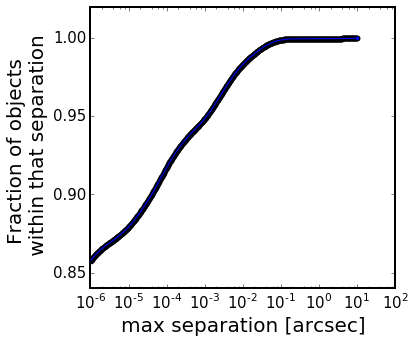

In [939]:
#How many objects from NCSA have IN2P3 counterparts in the overlap within ....

max_separation = np.logspace(-6, 1, 1000)
N_within_sep = np.zeros_like(max_separation)
for i in range(len(max_separation)): 
    max_sep = max_separation[i] 
    m = DS_overlap_match['match_angle_arcsec'] < max_sep
    #print('there are %d  NCSA objects that have IN2P3 counterpart within %.4f arcsec'%(np.sum(m), max_sep))
    N_within_sep[i] = np.sum(m)
    
    
# Plot showing how many objects are within a certain separation ... 

N_tot= len(DS_overlap_match)

fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.scatter(max_separation[1:], N_within_sep[1:] / N_tot)
ax.semilogx(max_separation[1:], N_within_sep[1:] / N_tot)
ax.set_xlabel('max separation [arcsec]')
ax.set_ylabel('Fraction of objects \n within that separation')
plt.tight_layout()
plt.savefig(outDir+'Deep_Source_NCSA_IN2P3_fraction_of_objects_within_radius.png')

In [999]:
outDir

'/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_overlap_compare/2017-03-21/'

In [836]:
np.sum(DS_overlap_match['match_angle_arcsec'] <  1 )

485933

In [927]:
m= DS_overlap_match['match_angle_arcsec'] <  1

indices = np.where((DS_overlap_match[m]['DeepSourceId_1'].data - DS_overlap_match[m]['DeepSourceId_2'].data) == 0 )[0]

In [928]:
#485933 objects have separation < 1 arcsec 
# of these,  426377 have identical DeepSourceIds !  
len(DS_overlap_match[m][indices])



426377

In [941]:
# Compare their magnitudes ...
DS_overlap_match[:10]

<Table length=10>
parentDeepSourceId_1 deepCoaddId_1 ...  DeepSourceId_2  match_angle_arcsec
       int64             int64     ...      int64            float64      
-------------------- ------------- ... ---------------- ------------------
                  -1      24641587 ... 3307337821454775                0.0
                  -1      24641587 ... 3307337821454777                0.0
                  -1      24641587 ... 3307337821454784                0.0
                  -1      24641587 ... 3307337821454788                0.0
                  -1      24641587 ... 3307337821454792                0.0
                  -1      24641587 ... 3307337821454798                0.0
                  -1      24641587 ... 3307337821454799                0.0
                  -1      24641587 ... 3307337821454804                0.0
                  -1      24641587 ... 3307337821454812                0.0
                  -1      24641587 ... 3307337821454814                0.0

Note : in all below,  _1 is NCSA,  and _2 is IN2P3.   Hence we are plotting difference vs _1  , just like before ... 

rms of the u difference is 0.000342 


/Users/chris/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


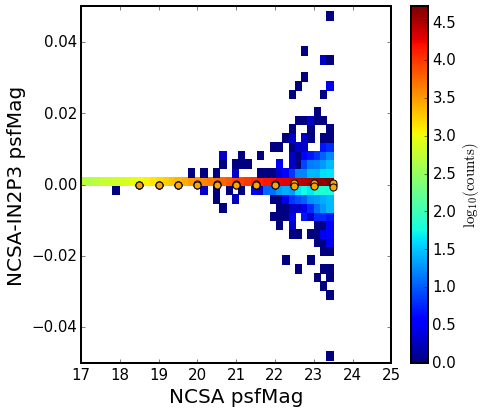

In [1029]:
# First ,  psfMag_1 - psfMag_2  vs  psfMag : magnitude dependence  ?  

m = DS_overlap_match['match_angle_arcsec'].data <  0.1
indices = np.where((DS_overlap_match['DeepSourceId_1'][m] - DS_overlap_match['DeepSourceId_2'][m]) == 0 )[0]

xmin, xmax = 17,25
ymin, ymax = -0.05,0.05


mag1 = DS_overlap_match[m][indices]['psfMag_1'].data
mag2 = DS_overlap_match[m][indices]['psfMag_2'].data
xdata = mag1
xlabel = 'NCSA psfMag'

diff  = mag1 - mag2
ydata = diff
ylabel  ='NCSA-IN2P3 psfMag'

m1 = (xmin < xdata) * (xdata < xmax)
m2 = np.abs(ydata) < ymax 
mask_xy = m1 * m2 

rms = np.sqrt(np.mean(np.power(ydata[mask_xy], 2.0 )))
print('rms of the difference is %.6f ' % (f, rms))

fig ,ax = plt.subplots(1,1, figsize=(7,6))

stats = binned_statistic_2d(x=xdata[mask_xy], y=ydata[mask_xy], 
                        values=ydata[mask_xy], statistic='count', bins=40)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), cmap='jet')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

cb = plt.colorbar(image, ax=ax)
cb.set_label(r'$\log_{10}(\mathrm{counts})$', fontsize=15)

min_x, max_x , step_size = 18.5,24.5,0.5
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size
median_y = np.zeros(len(mean_x))
rms_y = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < xdata[mask_xy] )*(xdata[mask_xy]<  (mean_x[j] + dx))
    median_y[j] = np.median(ydata[mask_xy][mask])
    rms_y[j] = np.sqrt(np.mean(np.power(ydata[mask_xy][mask], 2.0 )))

# Overplot the median y quantity,  and median +/-  rms
ax.scatter(mean_x, median_y, c = 'magenta', s=50)
ax.scatter(mean_x, median_y+rms_y, c = 'orange', s=50)
ax.scatter(mean_x, median_y-rms_y, c = 'orange', s=50)

plt.tight_layout()
plt.savefig(outDir + 'DS_NCSA_IN2P3_identical_objectId_sep_lt_1_arcsec_delta_u_vs_u.png')




It is less spread-out as when using magnitudes based on processed lightcurves  (reaches 0.05 mag instead of 0.1 mag difference at faint end), but the overall shape is the same .. . 

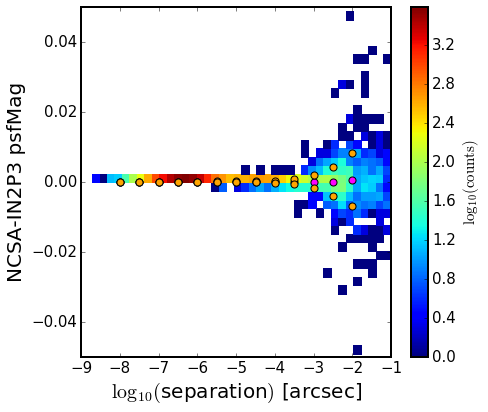

In [954]:
# First ,  psfMag_1 - psfMag_2  vs  psfMag : magnitude dependence  ?  

m = DS_overlap_match['match_angle_arcsec'].data <  1 
indices = np.where((DS_overlap_match['DeepSourceId_1'][m] - DS_overlap_match['DeepSourceId_2'][m]) == 0 )[0]

xmin, xmax = -9,-1
ymin, ymax = -0.05,0.05

mag1 = DS_overlap_match[m][indices]['psfMag_1'].data
mag2 = DS_overlap_match[m][indices]['psfMag_2'].data
ydata = mag1 - mag2
ylabel  ='NCSA-IN2P3 psfMag'

sep = DS_overlap_match[m][indices]['match_angle_arcsec'].data
xdata = np.log10(sep)
xlabel = r'$\log_{10}($'+'separation'+r'$)$'+' [arcsec]'


m1 = (xmin < xdata) * (xdata < xmax)
m2 = np.abs(ydata) < ymax 
mask_xy = m1 * m2 

fig ,ax = plt.subplots(1,1, figsize=(7,6))

stats = binned_statistic_2d(x=xdata[mask_xy], y=ydata[mask_xy], 
                        values=ydata[mask_xy], statistic='count', bins=40)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), cmap='jet')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

cb = plt.colorbar(image, ax=ax)
cb.set_label(r'$\log_{10}(\mathrm{counts})$', fontsize=15)

min_x, max_x , step_size =-8,-2,0.5
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size
median_y = np.zeros(len(mean_x))
rms_y = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < xdata[mask_xy] )*(xdata[mask_xy]<  (mean_x[j] + dx))
    median_y[j] = np.median(ydata[mask_xy][mask])
    rms_y[j] = np.sqrt(np.mean(np.power(ydata[mask_xy][mask], 2.0 )))

# Overplot the median y quantity,  and median +/-  rms
ax.scatter(mean_x, median_y, c = 'magenta', s=50)
ax.scatter(mean_x, median_y+rms_y, c = 'orange', s=50)
ax.scatter(mean_x, median_y-rms_y, c = 'orange', s=50)

plt.tight_layout()
plt.savefig(outDir + 'DS_NCSA_IN2P3_identical_objectId_sep_lt_1_arcsec_delta_psfMag_vs_sep.png')




Again : same structure, but only goes up to 0.05 instead of 0.1 mag in  spread ... 

/Users/chris/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


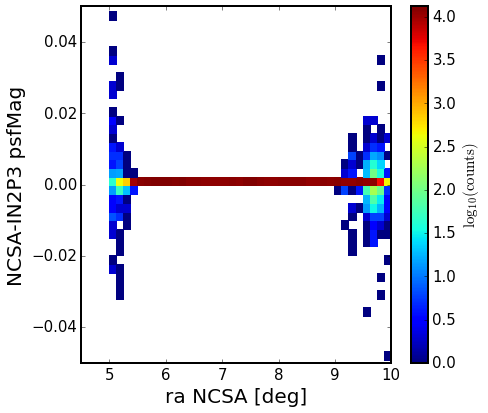

In [955]:
#- delta psfMag vs. ra and vs. dec (with medians and +- rms over plotted to look for trends).


m = DS_overlap_match['match_angle_arcsec'].data <  1 
indices = np.where((DS_overlap_match['DeepSourceId_1'][m] - DS_overlap_match['DeepSourceId_2'][m]) == 0 )[0]

xmin, xmax = 4.5,10
ymin, ymax = -0.05,0.05

mag1 = DS_overlap_match[m][indices]['psfMag_1'].data
mag2 = DS_overlap_match[m][indices]['psfMag_2'].data
ydata = mag1 - mag2
ylabel  ='NCSA-IN2P3 psfMag'

ra = DS_overlap_match[m][indices]['ra_1'].data
xdata = ra 
xlabel = 'ra NCSA [deg]'


m1 = (xmin < xdata) * (xdata < xmax)
m2 = np.abs(ydata) < ymax 
mask_xy = m1 * m2 

fig ,ax = plt.subplots(1,1, figsize=(7,6))

stats = binned_statistic_2d(x=xdata[mask_xy], y=ydata[mask_xy], 
                        values=ydata[mask_xy], statistic='count', bins=40)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), cmap='jet')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

cb = plt.colorbar(image, ax=ax)
cb.set_label(r'$\log_{10}(\mathrm{counts})$', fontsize=15)

min_x, max_x , step_size =-8,-2,0.5
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size
median_y = np.zeros(len(mean_x))
rms_y = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < xdata[mask_xy] )*(xdata[mask_xy]<  (mean_x[j] + dx))
    median_y[j] = np.median(ydata[mask_xy][mask])
    rms_y[j] = np.sqrt(np.mean(np.power(ydata[mask_xy][mask], 2.0 )))

# Overplot the median y quantity,  and median +/-  rms
ax.scatter(mean_x, median_y, c = 'magenta', s=50)
ax.scatter(mean_x, median_y+rms_y, c = 'orange', s=50)
ax.scatter(mean_x, median_y-rms_y, c = 'orange', s=50)

plt.tight_layout()
plt.savefig(outDir + 'DS_NCSA_IN2P3_identical_objectId_sep_lt_1_arcsec_delta_psfMag_vs_ra.png')




Very very different : solely psf-based plot does not reveal any structure ... 

(array([  5.00000000e+00,   1.30000000e+01,   8.40000000e+01,
          3.41000000e+03,   6.12000000e+03,   1.31980000e+04,
          2.86160000e+04,   6.03870000e+04,   1.22548000e+05,
          2.51794000e+05]),
 array([ 14.12554024,  15.06298572,  16.00043119,  16.93787667,
         17.87532215,  18.81276763,  19.75021311,  20.68765858,
         21.62510406,  22.56254954,  23.49999502]),
 <a list of 10 Patch objects>)

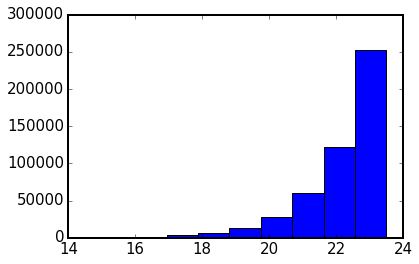

In [1032]:
plt.hist(DS_overlap_match['psfMag_1'].data)

/Users/chris/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


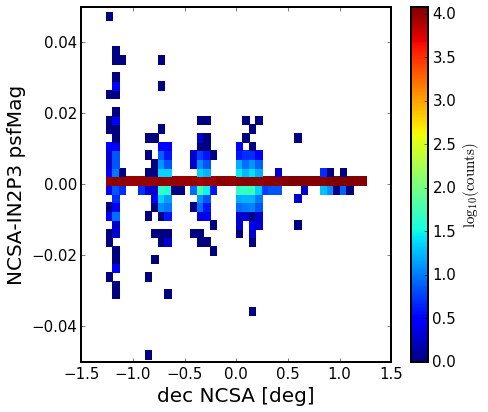

In [958]:
#- delta psfMag vs. dec (with medians and +- rms over plotted to look for trends).


m = DS_overlap_match['match_angle_arcsec'].data <  1 
indices = np.where((DS_overlap_match['DeepSourceId_1'][m] - DS_overlap_match['DeepSourceId_2'][m]) == 0 )[0]

xmin, xmax = -1.5, 1.5 
ymin, ymax = -0.05,0.05

mag1 = DS_overlap_match[m][indices]['psfMag_1'].data
mag2 = DS_overlap_match[m][indices]['psfMag_2'].data
ydata = mag1 - mag2
ylabel  ='NCSA-IN2P3 psfMag'

dec = DS_overlap_match[m][indices]['decl_1'].data
xdata = dec
xlabel = 'dec NCSA [deg]'


m1 = (xmin < xdata) * (xdata < xmax)
m2 = np.abs(ydata) < ymax 
mask_xy = m1 * m2 

fig ,ax = plt.subplots(1,1, figsize=(7,6))

stats = binned_statistic_2d(x=xdata[mask_xy], y=ydata[mask_xy], 
                        values=ydata[mask_xy], statistic='count', bins=40)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), cmap='jet')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

cb = plt.colorbar(image, ax=ax)
cb.set_label(r'$\log_{10}(\mathrm{counts})$', fontsize=15)

min_x, max_x , step_size =-8,-2,0.5
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size
median_y = np.zeros(len(mean_x))
rms_y = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < xdata[mask_xy] )*(xdata[mask_xy]<  (mean_x[j] + dx))
    median_y[j] = np.median(ydata[mask_xy][mask])
    rms_y[j] = np.sqrt(np.mean(np.power(ydata[mask_xy][mask], 2.0 )))

# Overplot the median y quantity,  and median +/-  rms
ax.scatter(mean_x, median_y, c = 'magenta', s=50)
ax.scatter(mean_x, median_y+rms_y, c = 'orange', s=50)
ax.scatter(mean_x, median_y-rms_y, c = 'orange', s=50)

plt.tight_layout()
plt.savefig(outDir + 'DS_NCSA_IN2P3_identical_objectId_sep_lt_1_arcsec_delta_psfMag_vs_dec.png')






That's pretty interesting:  why would this behave so weird , i.e. more spread towards the southern edges than the northern ones ? Could it be related to the number of passes for  north vs south stripes?  

## Find objects in catalog close to desired ra, dec ( like Cone search in PDAC )

In [869]:
# Find objects around RR Lyrae that is behaving funny... i = 41 
# ra,dec, search_radius : 352.469872 ,   -1.171239 ,  2 arcsec ....

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column

coords_data = SkyCoord(data['ra']*u.deg, data['decl']*u.deg)
coords_search =  SkyCoord(352.469872*u.deg, -1.171239*u.deg)

# Calculate distances between all entries in stellar catalog 
# and the desired coords 
d2d = coords_search.separation(coords_data)  

# choose the search radius ...
search_radius_arcsec = 2.0
catalogmsk = d2d < search_radius_arcsec*u.arcsec
print('There are %d objects within %d arcsec from the chosen coords'%(np.sum(catalogmsk), search_radius_arcsec))
nearby_obj_coords = coords_data[catalogmsk]

# isolate found objects ....
nearby_obj = data[catalogmsk]

# if needed, can save the distances between the chosen quasar 
# and stars within search radius … 
dist2d =  Column(data=d2d[catalogmsk], name='sep2d_deg' )



There are 1 objects within 2 arcsec from the chosen coords


In [870]:
nearby_obj

<Table masked=True length=1>
 col0     uN      uchi2DOF       uchi2R    ...       ra           decl      site
int64  float64    float64       float64    ...    float64       float64     str7
------ ------- ------------- ------------- ... ------------- -------------- ----
732483    71.0 2.98880762777 1.66724819917 ... 352.469880144 -1.17124224429 NCSA

In [871]:
# Do the same against DeepSource catalog...
# Before bright parents are removed - perhaps this is the issue ? 

dir_info = '../raw_data/repo_fls/'
site = 'NCSA'
good_sources = np.load(dir_info+site+'_source_without_bright_parent.npy')
deep_source_radec = pd.read_csv(dir_info+'DeepSource'+site+'_i_lt235_narrow.csv.gz', compression='gzip', 
                         index_col=0)



In [874]:
deep_source_radec['ra'].values

array([ 319.91910652,  320.00126091,  319.88180056, ...,    9.84124081,
          9.80934081,    9.97205067])

In [875]:
# Find objects around RR Lyrae that is behaving funny... i = 41 
# ra,dec, search_radius : 352.469872 ,   -1.171239 ,  2 arcsec ....

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column

coords_data = SkyCoord(deep_source_radec['ra'].values*u.deg, deep_source_radec['decl'].values*u.deg)
coords_search =  SkyCoord(352.469872*u.deg, -1.171239*u.deg)

# Calculate distances between all entries in stellar catalog 
# and the desired coords 
d2d = coords_search.separation(coords_data)  

# choose the search radius ...
search_radius_arcsec = 2.0
catalogmsk = d2d < search_radius_arcsec*u.arcsec
print('There are %d objects within %d arcsec from the chosen coords'%(np.sum(catalogmsk), search_radius_arcsec))
nearby_obj_coords = coords_data[catalogmsk]

# isolate found objects ....
nearby_obj = deep_source_radec[catalogmsk]

# if needed, can save the distances between the chosen quasar 
# and stars within search radius … 
dist2d =  Column(data=d2d[catalogmsk], name='sep2d_deg' )




There are 1 objects within 2 arcsec from the chosen coords


In [876]:
nearby_obj

parentDeepSourceId  deepCoaddId         ra      decl  \
deepSourceId                                                               
216471849679198456  216471849679194073   1612840963  352.46988 -1.171242   

                       psfMag  psfMagSigma  tract patch  detect_is_primary  
deepSourceId                                                                
216471849679198456  20.135373     0.012916      3  34,0                  1

In [849]:
data.colnames

['col0',
 'uN',
 'uchi2DOF',
 'uchi2R',
 'umuFull',
 'upsfMeanErr',
 'upsfMean_corr',
 'gN',
 'gchi2DOF',
 'gchi2R',
 'gmuFull',
 'gpsfMeanErr',
 'gpsfMean_corr',
 'rN',
 'rchi2DOF',
 'rchi2R',
 'rmuFull',
 'rpsfMeanErr',
 'rpsfMean_corr',
 'iN',
 'ichi2DOF',
 'ichi2R',
 'imuFull',
 'ipsfMeanErr',
 'ipsfMean_corr',
 'zN',
 'zchi2DOF',
 'zchi2R',
 'zmuFull',
 'zpsfMeanErr',
 'zpsfMean_corr',
 'ebv',
 'objectId',
 'patch',
 'deepSourceId',
 'extendedness',
 'ra',
 'decl',
 'site']

rms of the u difference is 0.010386 
rms of the g difference is 0.002844 
rms of the r difference is 0.002097 
rms of the i difference is 0.001541 
rms of the z difference is 0.002413 


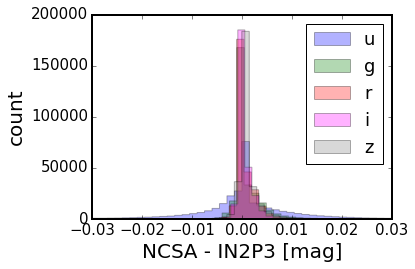

In [648]:
# Select by separation , and require identical deepSourceIds 

#rms of the u difference is 0.010386 
#rms of the g difference is 0.002844 
#rms of the r difference is 0.002097 
#rms of the i difference is 0.001541 
#rms of the z difference is 0.002413


colors = ['blue', 'green', 'red', 'magenta', 'gray']
filters = 'ugriz'
fig ,ax = plt.subplots(1,1)


m1 = NCSA_IN2P3_matched['match_angle_arcsec'].data.data <  1 
 

indices = np.where((NCSA_IN2P3_matched['deepSourceId_1'][m1] - NCSA_IN2P3_matched['deepSourceId_2'][m1]).data.data == 0 )[0]



xlim = 0.03
for i in range(len(colors)):
    f = filters[i]
      
    color1 = NCSA_IN2P3_matched[m1][indices][f+'psfMean_corr_1'].data.data
    color2 = NCSA_IN2P3_matched[m1][indices][f+'psfMean_corr_2'].data.data
    diff  = color1 - color2
    mask = np.abs(diff) < 0.03
    
    rms = np.sqrt(np.mean(np.power(diff, 2.0 )))
    print('rms of the %s difference is %.6f ' % (f, rms))
    ax.hist(diff[mask], histtype='stepfilled',  bins=40, alpha=0.3, color=colors[i], label=f)
ax.set_xlim(-xlim, xlim)
ax.set_xlabel('NCSA - IN2P3 [mag]')
ax.set_ylabel('count')
ax.legend()
plt.tight_layout()
plt.savefig(outDir + 'NCSA_IN2P3_identical_objectId_sep_lt_1_arcsec_residuals.png')

rms of the u difference is 0.005142 
rms of the g difference is 0.002723 
rms of the r difference is 0.002584 
rms of the i difference is 0.001983 
rms of the z difference is 0.004661 


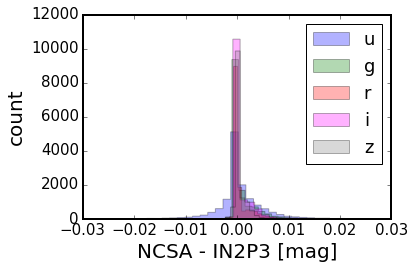

In [647]:
# Select by separation ,  gmax < 21 , and require identical deepSourceIds 
# rms of the u difference is 0.005142 
# rms of the g difference is 0.002723 
# rms of the r difference is 0.002584 
# rms of the i difference is 0.001983 
# rms of the z difference is 0.004661 

colors = ['blue', 'green', 'red', 'magenta', 'gray']
filters = 'ugriz'
fig ,ax = plt.subplots(1,1)


m1 = NCSA_IN2P3_matched['match_angle_arcsec'].data.data <  1 
m2 = NCSA_IN2P3_matched['gpsfMean_corr_1'].data.data < 21
m = m1 * m2 

indices = np.where((NCSA_IN2P3_matched['deepSourceId_1'][m] - NCSA_IN2P3_matched['deepSourceId_2'][m]).data.data == 0 )[0]



xlim = 0.03
for i in range(len(colors)):
    f = filters[i]
      
    color1 = NCSA_IN2P3_matched[m][indices][f+'psfMean_corr_1'].data.data
    color2 = NCSA_IN2P3_matched[m][indices][f+'psfMean_corr_2'].data.data
    diff  = color1 - color2
    mask = np.abs(diff) < 0.03
    
    rms = np.sqrt(np.mean(np.power(diff, 2.0 )))
    print('rms of the %s difference is %.6f ' % (f, rms))
    ax.hist(diff[mask], histtype='stepfilled',  bins=40, alpha=0.3, color=colors[i], label=f)
ax.set_xlim(-xlim, xlim)
ax.set_xlabel('NCSA - IN2P3 [mag]')
ax.set_ylabel('count')
ax.legend()
plt.tight_layout()
plt.savefig(outDir + 'NCSA_IN2P3_identical_objectId_sep_lt_1_arcsec_residuals_each_f_lt_21.png')

rms of the u difference is 0.003850 


/Users/chris/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


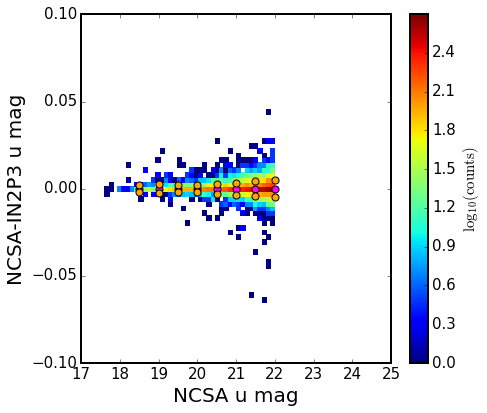

In [1025]:
# delta u vs. u (from one of the reductions), to see if it’s magnitude dependent

# Select by separation ,  gmax < 21 , and require identical deepSourceIds 
# rms of the u difference is 0.005142 
# rms of the g difference is 0.002723 
# rms of the r difference is 0.002584 
# rms of the i difference is 0.001983 
# rms of the z difference is 0.004661 

colors = ['blue', 'green', 'red', 'magenta', 'gray']
filters = 'ugriz'



m1 = NCSA_IN2P3_matched['match_angle_arcsec'].data.data <  1 
m2 = NCSA_IN2P3_matched['upsfMean_corr_1'].data.data < 22
m = m1  * m2 

indices = np.where((NCSA_IN2P3_matched['deepSourceId_1'][m] - NCSA_IN2P3_matched['deepSourceId_2'][m]).data.data == 0 )[0]



xmin, xmax = 17,25
ymin, ymax = -0.1,0.1
#for i in range(len(colors)):
i=0
f = filters[i]

mag1 = NCSA_IN2P3_matched[m][indices][f+'psfMean_corr_1'].data.data
mag2 = NCSA_IN2P3_matched[m][indices][f+'psfMean_corr_2'].data.data
xdata = mag1
xlabel = 'NCSA '+f+' mag'

diff  = mag1 - mag2
ydata = diff
ylabel  ='NCSA-IN2P3 '+f+' mag'

m1 = (xmin < xdata) * (xdata < xmax)
m2 = np.abs(ydata) < ymax 
mask_xy = m1 * m2 

rms = np.sqrt(np.mean(np.power(ydata[mask_xy], 2.0 )))
print('rms of the %s difference is %.6f ' % (f, rms))

fig ,ax = plt.subplots(1,1, figsize=(7,6))

stats = binned_statistic_2d(x=xdata[mask_xy], y=ydata[mask_xy], 
                        values=ydata[mask_xy], statistic='count', bins=40)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor

j= 0
image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), cmap='jet')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#ax.scatter(color1, diff, s=0.01)
#ax.hist(diff[mask], histtype='stepfilled',  bins=40, alpha=0.3, color=colors[i], label=f)
#ax.set_xlim(-xlim, xlim)
#ax.set_xlabel('NCSA - IN2P3 [mag]')
#ax.set_ylabel('count')
#ax.legend()

cb = plt.colorbar(image, ax=ax)
cb.set_label(r'$\log_{10}(\mathrm{counts})$', fontsize=15)

min_x, max_x , step_size = 18.5,24.5,0.5
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size
median_y = np.zeros(len(mean_x))
rms_y = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < xdata[mask_xy] )*(xdata[mask_xy]<  (mean_x[j] + dx))
    median_y[j] = np.median(ydata[mask_xy][mask])
    rms_y[j] = np.sqrt(np.mean(np.power(ydata[mask_xy][mask], 2.0 )))

# Overplot the median y quantity,  and median +/-  rms
ax.scatter(mean_x, median_y, c = 'magenta', s=50)
ax.scatter(mean_x, median_y+rms_y, c = 'orange', s=50)
ax.scatter(mean_x, median_y-rms_y, c = 'orange', s=50)

plt.tight_layout()
plt.savefig(outDir + 'NCSA_IN2P3_identical_objectId_sep_lt_1_arcsec_delta_'+f+'_vs_'+f+'.png')



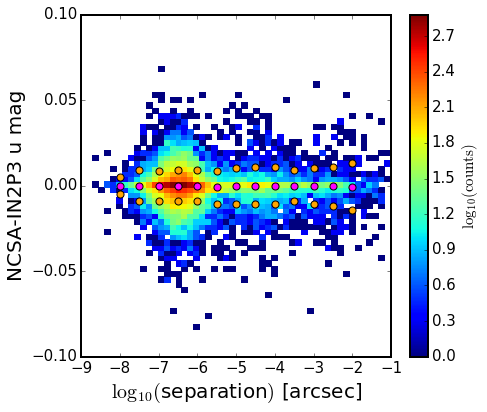

In [1026]:
#- delta u vs. separation

colors = ['blue', 'green', 'red', 'magenta', 'gray']
filters = 'ugriz'



mask = NCSA_IN2P3_matched['match_angle_arcsec'].data.data <  1 
#m2 = NCSA_IN2P3_matched['gpsfMean_corr_1'].data.data < 29


indices = np.where((NCSA_IN2P3_matched['deepSourceId_1'][mask] - NCSA_IN2P3_matched['deepSourceId_2'][mask]).data.data == 0 )[0]



xmin, xmax = -9,-1
ymin, ymax = -0.1,0.1
#for i in range(len(colors)):
i=0
f = filters[i]

mag1 = NCSA_IN2P3_matched[mask][indices][f+'psfMean_corr_1'].data.data
mag2 = NCSA_IN2P3_matched[mask][indices][f+'psfMean_corr_2'].data.data
diff  = mag1 - mag2
ydata = diff
ylabel = 'NCSA-IN2P3 '+f+' mag'

sep = NCSA_IN2P3_matched[mask][indices]['match_angle_arcsec'].data.data
xdata = np.log10(sep)
xlabel = r'$\log_{10}($'+'separation'+r'$)$'+' [arcsec]'

m1 = (xmin < xdata) * (xdata < xmax)
m2 = np.abs(ydata) < ymax 
mask_xy =  m1 * m2 

#rms = np.sqrt(np.mean(np.power(diff[m], 2.0 )))
#print('rms of the %s difference is %.6f ' % (f, rms))

fig ,ax = plt.subplots(1,1, figsize=(7,6))

stats = binned_statistic_2d(x=xdata[mask_xy], y=ydata[mask_xy], 
                        values=ydata[mask_xy], statistic='count', bins=50)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor

image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), cmap='jet')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
cb = plt.colorbar(image, ax=ax)
cb.set_label(r'$\log_{10}(\mathrm{counts})$', fontsize=15)


min_x, max_x , step_size = -8,-2,0.5
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size
median_y = np.zeros(len(mean_x))
rms_y = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < xdata[mask_xy] )*(xdata[mask_xy]<  (mean_x[j] + dx))
    median_y[j] = np.median(ydata[mask_xy][mask])
    rms_y[j] = np.sqrt(np.mean(np.power(ydata[mask_xy][mask], 2.0 )))

# Overplot the median y quantity,  and median +/-  rms
ax.scatter(mean_x, median_y, c = 'magenta', s=50)
ax.scatter(mean_x, median_y+rms_y, c = 'orange', s=50)
ax.scatter(mean_x, median_y-rms_y, c = 'orange', s=50)

plt.tight_layout()
plt.savefig(outDir + 'NCSA_IN2P3_identical_objectId_sep_lt_1_arcsec_delta_'+f+'_vs_sep.png')



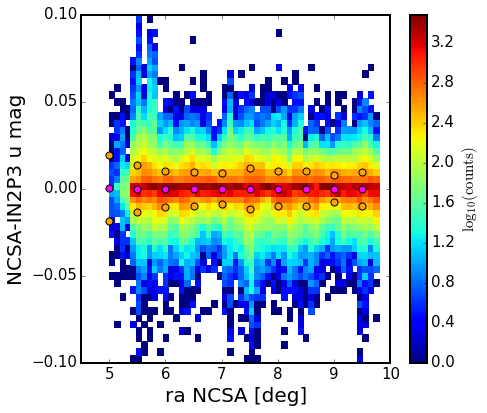

In [1027]:
#- delta u vs. ra and vs. dec (with medians and +- rms over plotted to look for trends).

colors = ['blue', 'green', 'red', 'magenta', 'gray']
filters = 'ugriz'



mask = NCSA_IN2P3_matched['match_angle_arcsec'].data.data <  1 
#m2 = NCSA_IN2P3_matched['gpsfMean_corr_1'].data.data < 29
indices = np.where((NCSA_IN2P3_matched['deepSourceId_1'][mask] - NCSA_IN2P3_matched['deepSourceId_2'][mask]).data.data == 0 )[0]



xmin, xmax = 4.5,10
ymin, ymax = -0.1,0.1

i=0
f = filters[i]

mag1 = NCSA_IN2P3_matched[mask][indices][f+'psfMean_corr_1'].data.data
mag2 = NCSA_IN2P3_matched[mask][indices][f+'psfMean_corr_2'].data.data

diff  = mag1 - mag2
ydata = diff
ylabel = 'NCSA-IN2P3 '+f+' mag' 

ra = NCSA_IN2P3_matched[mask][indices]['ra_1'].data.data
xdata = ra 
xlabel = 'ra NCSA [deg]'

m1 = (xmin < xdata) * (xdata < xmax)
m2 = np.abs(ydata) < ymax 
mask_xy = m1 * m2 

fig ,ax = plt.subplots(1,1, figsize=(7,6))

stats = binned_statistic_2d(x=xdata[mask_xy], y=ydata[mask_xy], 
                        values=ydata[mask_xy], statistic='count', bins=50)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor

j= 0
image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), cmap='jet')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
plt.tight_layout()
cb = plt.colorbar(image, ax=ax)
cb.set_label(r'$\log_{10}(\mathrm{counts})$', fontsize=15)

min_x, max_x , step_size = 5,9.5,0.5
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size
median_y = np.zeros(len(mean_x))
rms_y = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < xdata[mask_xy] )*(xdata[mask_xy]<  (mean_x[j] + dx))
    median_y[j] = np.median(ydata[mask_xy][mask])
    rms_y[j] = np.sqrt(np.mean(np.power(ydata[mask_xy][mask], 2.0 )))

# Overplot the median y quantity,  and median +/-  rms
ax.scatter(mean_x, median_y, c = 'magenta', s=50)
ax.scatter(mean_x, median_y+rms_y, c = 'orange', s=50)
ax.scatter(mean_x, median_y-rms_y, c = 'orange', s=50)

plt.tight_layout()
plt.savefig(outDir + 'NCSA_IN2P3_identical_objectId_sep_lt_1_arcsec_delta_'+f+'_vs_ra.png')



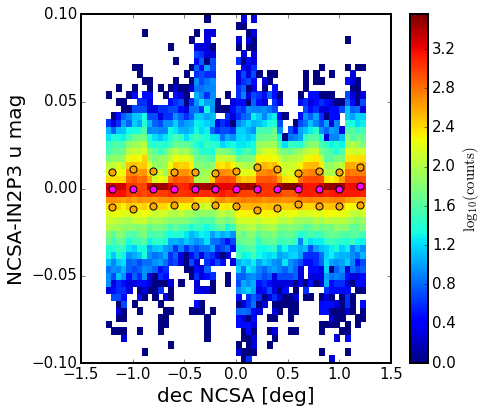

In [1028]:
#- delta u vs. dec (with medians and +- rms over plotted to look for trends).

colors = ['blue', 'green', 'red', 'magenta', 'gray']
filters = 'ugriz'

mask = NCSA_IN2P3_matched['match_angle_arcsec'].data.data <  1 
#m2 = NCSA_IN2P3_matched['gpsfMean_corr_1'].data.data < 29


indices = np.where((NCSA_IN2P3_matched['deepSourceId_1'][mask] - NCSA_IN2P3_matched['deepSourceId_2'][mask]).data.data == 0 )[0]

xmin, xmax = -1.5, 1.5 
ymin, ymax = -0.1,0.1

i=0
f = filters[i]

mag1 = NCSA_IN2P3_matched[mask][indices][f+'psfMean_corr_1'].data.data
mag2 = NCSA_IN2P3_matched[mask][indices][f+'psfMean_corr_2'].data.data

diff  = mag1 - mag2
ydata = diff
ylabel = 'NCSA-IN2P3 '+f+' mag'

dec = NCSA_IN2P3_matched[mask][indices]['decl_1'].data.data
xdata = dec 
xlabel = 'dec NCSA [deg]' 

m1 = (xmin < xdata) * (xdata < xmax)
m2 = np.abs(diff) < ymax 
mask_xy =   m2 

fig ,ax = plt.subplots(1,1, figsize=(7,6))

stats = binned_statistic_2d(x=xdata[mask_xy], y=ydata[mask_xy], 
                        values=ydata[mask_xy], statistic='count', bins=50)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor

j= 0
image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), cmap='jet')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

cb = plt.colorbar(image, ax=ax)
cb.set_label(r'$\log_{10}(\mathrm{counts})$', fontsize=15)


min_x, max_x , step_size = -1.2,1.2,0.2
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size
median_y = np.zeros(len(mean_x))
rms_y = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < xdata[mask_xy] )*(xdata[mask_xy]<  (mean_x[j] + dx))
    median_y[j] = np.median(ydata[mask_xy][mask])
    rms_y[j] = np.sqrt(np.mean(np.power(ydata[mask_xy][mask], 2.0 )))

# Overplot the median y quantity,  and median +/-  rms
ax.scatter(mean_x, median_y, c = 'magenta', s=50)
ax.scatter(mean_x, median_y+rms_y, c = 'orange', s=50)
ax.scatter(mean_x, median_y-rms_y, c = 'orange', s=50)

plt.tight_layout()
plt.savefig(outDir + 'NCSA_IN2P3_identical_objectId_sep_lt_1_arcsec_delta_'+f+'_vs_dec.png')



In [859]:
2.6*50

130.0

### Plot Ivezic+2003  g-r vs g .... 

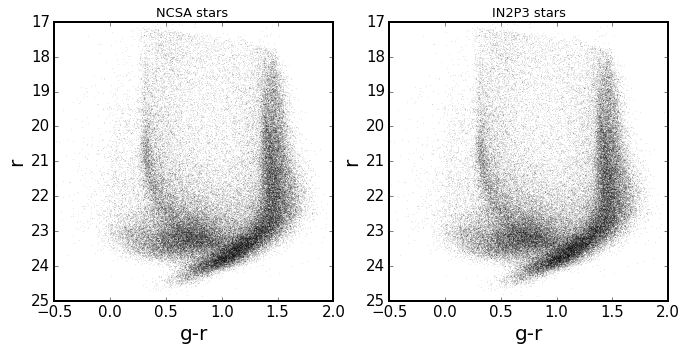

In [596]:
m1 = NCSA_IN2P3_matched['match_angle_arcsec'].data.data < 1
#NCSA_IN2P3_matched[m][['ra_1','ra_2']]


fig,axs = plt.subplots(1,2,figsize=(11,5))

# NCSA ... 

m2 = NCSA_IN2P3_matched['extendedness_1'].data.data == 0  # pick only stars... 
m = m1 & m2 

g = NCSA_IN2P3_matched['gpsfMean_corr_1'].data.data[m]
r = NCSA_IN2P3_matched['rpsfMean_corr_1'].data.data[m]
gr = g-r
axs[0].scatter(gr,r, s=0.001)
axs[0].set_xlim(-0.5,2)
axs[0].set_ylim(17,25)
axs[0].invert_yaxis()

# IN2P3 ... 
m2 = NCSA_IN2P3_matched['extendedness_2'].data.data == 0  # pick only stars... 
m = m1 & m2 

g = NCSA_IN2P3_matched['gpsfMean_corr_2'].data.data[m]
r = NCSA_IN2P3_matched['rpsfMean_corr_2'].data.data[m]
gr = g-r
axs[1].scatter(gr,r, s=0.001)
axs[1].set_xlim(-0.5,2)
axs[1].set_ylim(17,25)
axs[1].invert_yaxis()

axs[0].set_title('NCSA stars ')
axs[1].set_title('IN2P3 stars')
axs[0].set_xlabel('g-r')
axs[0].set_ylabel('r')
axs[1].set_xlabel('g-r')
axs[1].set_ylabel('r')

plt.savefig(outDir + 'Fig_1_Ivezic_2002_NCSA_vs_IN2P3_ug')




In [522]:
outDir

'/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_chi2_space/2017-03-20/'

In [ ]:
np.sum()

In [412]:

orig_obj


<Table masked=True length=98133>
  col0     uN      uchi2DOF    ...       ra           decl       site
 int64  float64    float64     ...    float64       float64      str7
------- ------- -------------- ... ------------- -------------- -----
4444512    71.0 0.995189487405 ... 9.65941309357 -1.25576531578  NCSA
4444513    71.0  0.90962802418 ... 9.63979249003 -1.25545891552  NCSA
4444514    68.0  1.60879786393 ... 9.58198167947 -1.25500866371  NCSA
4444516    69.0  1.00825975862 ... 9.78228000143  -1.2534531244  NCSA
4444520    73.0  1.05515900985 ... 9.74048905409 -1.25141098708  NCSA
4444522    70.0  1.13799486761 ... 9.73515299058  -1.2504682799  NCSA
4444525    69.0  1.01085822458 ... 9.60239210335 -1.24983572084  NCSA
4444526    72.0 0.923140964104 ... 9.72518288582 -1.24910574177  NCSA
4444530    73.0  1.68016949604 ... 9.59745539465 -1.24758452963  NCSA
4444531    69.0  1.48061341616 ... 9.61799128221 -1.24751486561  NCSA
    ...     ...            ... ...           ...            ...   ...
3426238    82.0  1.39340356187 ... 5.00914584929  1.25532551702 IN2P3
3426239    81.0  2.09569149147 ... 5.01147490581  1.24619479718 IN2P3
3426240    83.0 0.824088767887 ... 5.00888050224  1.24699899499 IN2P3
3426241    81.0  1.87773788272 ... 5.00698518193  1.24483781235 IN2P3
3426242    81.0 0.689913793434 ...  5.0285292817  1.25431475652 IN2P3
3426243    79.0 0.660405558479 ... 5.02656851259  1.25650931883 IN2P3
3426244    83.0 0.909029812544 ... 5.01379392458  1.25560753705 IN2P3
3426245    81.0 0.820216501967 ... 5.00529348019  1.25381964671 IN2P3
3426246    79.0  1.04180778851 ... 4.96343221606  1.25259713057 IN2P3
3426247    80.0 0.717868113198 ... 4.96557309584  1.24939853358 IN2P3

In [359]:


#from astropy.table import vstack
#vstack(orig_obj[:10], match_obj[:10])

In [409]:
#orig_obj[:2]

In [408]:
#np.unique(match_obj['patch'])

## Fig. 23 : g-i vs r 

In [20]:
figDir = 'Fig_Sesar2010'
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+figDir,
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)

We will save this figure in  /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2010/2017-03-15/


j=0
j=1
j=2
j=3
j=0
j=1
j=2
j=3


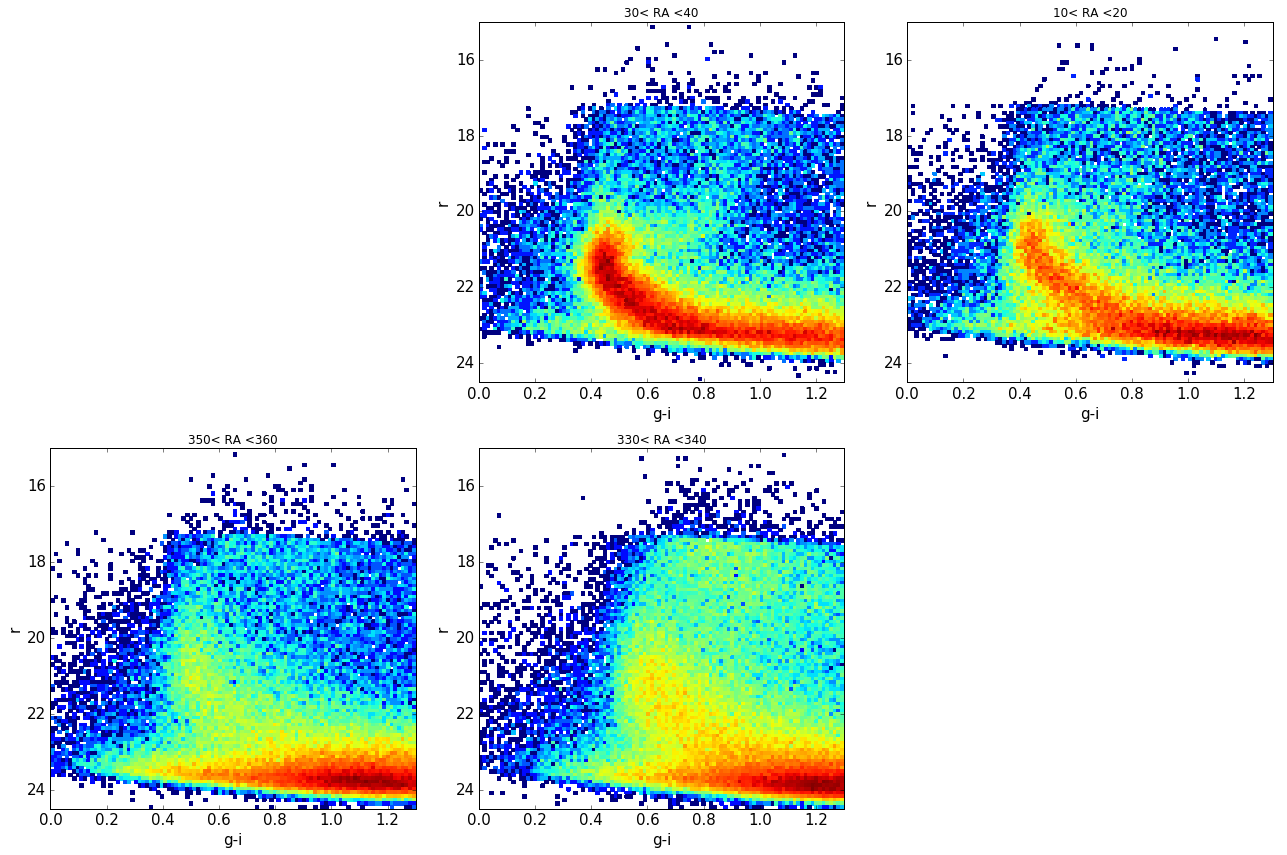

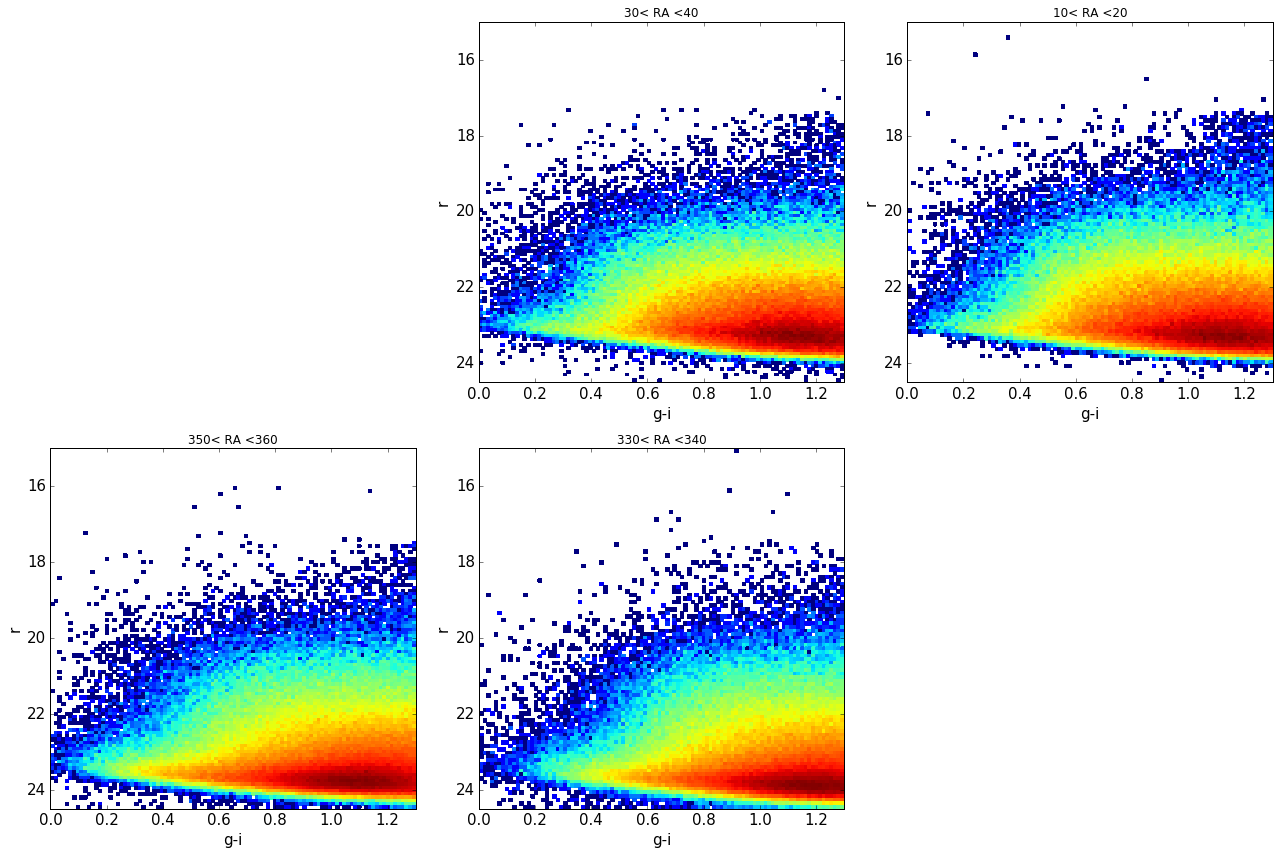

In [21]:
# make the plot ... 
raMin = [30, 10, 350,330]
raMax = [40, 20, 360,340]


#####   g-i vs r (like Fig.23)   

# Select a range of gi,  r  for the histogram....  
gi_lim = [0,1.3]
r_lim = [15,24.5] 
#nbinsArr = [100,100,50]

nbins = 100

for i in range(2):
    ext=i # choose extendedness 
    fig, axs = plt.subplots(2,3, figsize=(18,12))
    ax = np.ravel(axs) 

    for j in range(len(raMin)):
        print('j=%d'%j)
        maskRa =  (raMin[j] < data['ra'])  & (data['ra'] < raMax[j])
        maskExtend = data['extendedness'] == ext
        maskTot = maskRa * maskExtend
        gi = data['gpsfMean_corr'][maskTot] - data['ipsfMean_corr'][maskTot]
        r =  data['rpsfMean_corr'][maskTot]
        maskCol = (gi < gi_lim[1])&(gi>gi_lim[0])&(r<r_lim[1])&(r > r_lim[0])
        H, xedges, yedges = np.histogram2d(gi[maskCol],r[maskCol],bins=nbins)
        # H needs to be rotated and flipped
        H = np.rot90(H)
        H = np.flipud(H)
        # Mask zeros
        Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
        # Plot 2D histogram using pcolor
        ax[j+1].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
        ax[j+1].set_xlabel('g-i', fontsize=15)
        ax[j+1].set_ylabel('r', fontsize=15)
        ax[j+1].set_xlim(gi_lim[0],gi_lim[1])
        ax[j+1].set_ylim(r_lim[0], r_lim[1])
        ax[j+1].set_title(str(raMin[j])+'< RA <' + str(raMax[j]))
        ax[j+1].invert_yaxis()
        
        ax[j+1].tick_params(axis = 'both', labelsize=15) 
    ax[0].axis('off')
    ax[5].axis('off')
    plt.tight_layout()
    plt.savefig(outDir + 'Fig_23_test_ext-'+str(ext)+'.png')

## Fig. 23- like : g-r vs r-i  steps

In [22]:
figDir = 'Fig_Sesar2010'
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+figDir,
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)

We will save this figure in  /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2010/2017-03-15/


In [40]:

frameDir0 = outDir + 'ext0_frames/'
frameDir1 = outDir + 'ext1_frames/'
if not os.path.exists(frameDir0): os.system('mkdir %s' % frameDir0)
if not os.path.exists(frameDir1): os.system('mkdir %s' % frameDir1)

print('Individual frames are saved in \n\n %s and \n %s '%(frameDir0, frameDir1))

Individual frames are saved in 

 /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2010/2017-03-15/ext0_frames/ and 
 /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2010/2017-03-15/ext1_frames/ 


In [28]:
np.ravel(data.colnames)

array(['col0', 'uN', 'uchi2DOF', 'uchi2R', 'umuFull', 'upsfMeanErr',
       'upsfMean_corr', 'gN', 'gchi2DOF', 'gchi2R', 'gmuFull',
       'gpsfMeanErr', 'gpsfMean_corr', 'rN', 'rchi2DOF', 'rchi2R',
       'rmuFull', 'rpsfMeanErr', 'rpsfMean_corr', 'iN', 'ichi2DOF',
       'ichi2R', 'imuFull', 'ipsfMeanErr', 'ipsfMean_corr', 'zN',
       'zchi2DOF', 'zchi2R', 'zmuFull', 'zpsfMeanErr', 'zpsfMean_corr',
       'ebv', 'objectId', 'patch', 'deepSourceId', 'extendedness', 'ra',
       'decl'], 
      dtype='<U13')

In [41]:
raMin = [320, 330, 340,350,0, 10,20,30,40]
raMax = [330, 340, 350,360,10,20,30,40,55]

# Select a range of r-i,  g-r  for the histogram.... 
xlim = [-1,3]
ylim = [-1,3]

mag_lims = [5,19.0,19.2,19.4,19.6,19.8, 20.0, 20.2, 20.4, 20.6, 20.8,
            21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22.4,22.6,22.8,23,23.2,23.4,23.6,24]
#mag_lims = [22.0, 22.4, 22.6]
#dir_save = '../data_products/Fig_Sesar2010/'

        
nbins = 100
count=0
#for i in range(2):
ext=1 # choose extendedness 
print('extendedness=%d'%ext)

for k in range(len(mag_lims)-1):
    mask_band = (mag_lims[k] < data['ipsfMean_corr']) & (data['ipsfMean_corr'] < mag_lims[k+1])

    print('i_mag_min=%.2f, i_mag_max=%.2f'%(mag_lims[k], mag_lims[k+1]))
    # make a plot for each extendedness and mag range 
    count+=1
    fig, axs = plt.subplots(3,3, figsize=(12,12))
    ax = np.ravel(axs) 

    for j in range(len(raMin)):
        #print('j=%d'%j)
        mask_ra =  (raMin[j] < data['ra'])  & (data['ra'] < raMax[j])
        mask_extendedness = data['extendedness'] == ext

        mask_total = mask_ra & mask_extendedness & mask_band & mask_chi2
        ri = data['rpsfMean_corr'][mask_total] - data['ipsfMean_corr'][mask_total]
        gr = data['gpsfMean_corr'][mask_total] - data['rpsfMean_corr'][mask_total]
        #grri = pd.concat([gr,ri], axis=1)
        #grri_dropna = grri.dropna()
        #gr = grri_dropna[0]
        #ri = grri_dropna[1]
        maskCol = (gr < xlim[1])&(gr>xlim[0])&(ri<ylim[1])&(ri>ylim[0])
        H, xedges, yedges = np.histogram2d(gr[maskCol],ri[maskCol],bins=nbins)
        #H, xedges, yedges = np.histogram2d(grri_dropna[1],grri_dropna[0],bins=nbins)
        # H needs to be rotated and flipped
        H = np.rot90(H)
        H = np.flipud(H)
        # Mask zeros
        Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
        # Plot 2D histogram using pcolor
        ax[j].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
        #ax[j].set_ylabel('r-i', fontsize=15)
        #ax[j].set_xlabel('g-r', fontsize=15)
        ax[j].set_xlim(xlim[0],xlim[1])
        ax[j].set_ylim(ylim[0],ylim[1])
        ax[j].set_title(str(raMin[j])+'< RA <' + str(raMax[j]))
        #ax[j].invert_yaxis()
        ax[j].tick_params(axis = 'both', labelsize=15) 

    #fig.subplots_adjust(wspace=0, hspace=0, left=0.1, bottom=0.20, top=0.95)

    #ax[j+1].axis('off')
    fig.text(0.5, 0.96, 'Extendedness='+str(ext)+' , '+str(mag_lims[k])+' < iPsfMean < '+str(mag_lims[k+1]), ha='center', va='center',fontsize=20)
    fig.text(0.5, 0.04, 'g-r', ha='center', va='center',fontsize=20)
    fig.text(0.03, 0.5, 'r-i', ha='center', va='center', rotation='vertical',fontsize=20)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.26, hspace=0.26, left=0.12, right=0.94, bottom=0.10, top=0.9)
    if ext == 0 : 
        figname =  frameDir0+ 'Fig_23_like_test'+str(count).zfill(2)+'_Fig_g-r_vs_r-i_ext_'+\
                    str(ext)+'_'+str(mag_lims[k])+'-i-'+str(mag_lims[k+1])+'.png'
    else : 
        figname =  frameDir1+ 'Fig_23_like_test'+str(count).zfill(2)+'_Fig_g-r_vs_r-i_ext_'+\
                    str(ext)+'_'+str(mag_lims[k])+'-i-'+str(mag_lims[k+1])+'.png'

    plt.savefig(figname)
    plt.close(fig)



extendedness=1
i_mag_min=5.00, i_mag_max=19.00
i_mag_min=19.00, i_mag_max=19.20
i_mag_min=19.20, i_mag_max=19.40
i_mag_min=19.40, i_mag_max=19.60
i_mag_min=19.60, i_mag_max=19.80
i_mag_min=19.80, i_mag_max=20.00
i_mag_min=20.00, i_mag_max=20.20
i_mag_min=20.20, i_mag_max=20.40
i_mag_min=20.40, i_mag_max=20.60
i_mag_min=20.60, i_mag_max=20.80
i_mag_min=20.80, i_mag_max=21.00
i_mag_min=21.00, i_mag_max=21.20
i_mag_min=21.20, i_mag_max=21.40
i_mag_min=21.40, i_mag_max=21.60
i_mag_min=21.60, i_mag_max=21.80
i_mag_min=21.80, i_mag_max=22.00
i_mag_min=22.00, i_mag_max=22.40
i_mag_min=22.40, i_mag_max=22.60
i_mag_min=22.60, i_mag_max=22.80
i_mag_min=22.80, i_mag_max=23.00
i_mag_min=23.00, i_mag_max=23.20
i_mag_min=23.20, i_mag_max=23.40
i_mag_min=23.40, i_mag_max=23.60


/Users/chris/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


i_mag_min=23.60, i_mag_max=24.00


array([  9.71430225e-01,   5.32088379e-01,   1.05845462e-01,
         8.84520837e-01,   5.14506603e-01,   1.75005529e-01,
         5.66103788e-01,   9.04131896e-01,   7.17932750e-01,
         5.52600107e-01,   9.06386407e-01,   2.22572468e-02,
         7.28798399e-01,   7.03040763e-01,   8.11878660e-01,
         5.47998319e-01,   5.72802160e-01,   4.49382143e-04,
         5.20069289e-01,   5.14052336e-02,   3.79857308e-01,
         5.69478904e-01,   5.42407679e-01,   3.45921407e-01,
         4.74902199e-01,   3.71238717e-01,   4.99427457e-01,
         9.04013716e-01,   1.55611455e-01,   1.86837371e-01,
         6.47830126e-01,   4.66557436e-01,   7.35601543e-01,
         4.58013411e-02,   1.89655472e-01,   2.54242171e-01,
         4.69872609e-01,   6.64972089e-01,   4.10452210e-01,
         4.13597504e-01,   6.37139278e-01,   8.44940941e-01,
         8.32604847e-01,   5.78510722e-01,   9.08098089e-01,
         5.21559117e-01,   7.05443064e-01,   9.74967873e-01,
         9.89574831e-01,

In [729]:
outDir

'/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_overlap_compare/2017-03-21/'

## Ivezic+2003 : g-r vs r 

In [192]:
np.ravel(data.colnames)

array(['col0', 'uN', 'uchi2DOF', 'uchi2R', 'umuFull', 'upsfMeanErr',
       'upsfMean_corr', 'gN', 'gchi2DOF', 'gchi2R', 'gmuFull',
       'gpsfMeanErr', 'gpsfMean_corr', 'rN', 'rchi2DOF', 'rchi2R',
       'rmuFull', 'rpsfMeanErr', 'rpsfMean_corr', 'iN', 'ichi2DOF',
       'ichi2R', 'imuFull', 'ipsfMeanErr', 'ipsfMean_corr', 'zN',
       'zchi2DOF', 'zchi2R', 'zmuFull', 'zpsfMeanErr', 'zpsfMean_corr',
       'ebv', 'objectId', 'patch', 'deepSourceId', 'extendedness', 'ra',
       'decl'], 
      dtype='<U13')

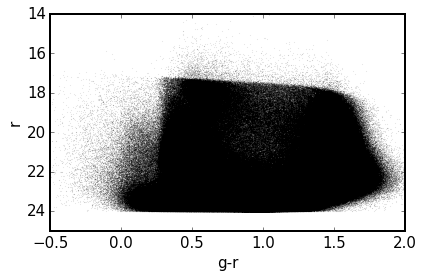

In [197]:
%matplotlib inline 

g = data['gpsfMean_corr'].data.data
r = data['rpsfMean_corr'].data.data

m1 = r < 24
m2 = data['extendedness'] == 0 # choose only stars ...

m = m1 & m2 

gr = g[m]-r[m]
r = r[m]
plt.scatter(gr,r, s=0.001)
plt.xlim(-0.5,2)
plt.ylim(14,25)
plt.xlabel('g-r', fontsize=15)
plt.ylabel('r', fontsize=15)
plt.gca().invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

plt.savefig('../data_products/Fig_Ivezic2003/Fig_2_test.png')
plt.show()



In [102]:
outDir

'/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-10/'

In [1038]:
# Check what data is available for a single object at a specific location ...

mask = np.in1d(data['deepSourceId'].data.data , 3588818166880604)

In [1039]:
data['deepSourceId'][mask]

<MaskedColumn name='deepSourceId' dtype='int64' length=0>